# Import Libraries

In [13]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import seaborn as sns
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
from scipy import stats
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score , classification_report , accuracy_score , confusion_matrix 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
import catboost as cb
import tensorflow as tf
from keras import callbacks
from keras.layers import Dense, Input, Dropout, Normalization, BatchNormalization
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
tf.random.set_seed(42)
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RandomizedSearchCV

# Data Cleaning

## Load the dataset
This dataset is taken from the Kaggle page 'https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package/data'.

This dataset comprises about 10 years of daily weather observations from numerous locations across Australia. The observations were gathered from a multitude of weather stations. You can access daily observations from 'http://www.bom.gov.au/climate/data'.

In [14]:
# Load the dataset into a dataframe
df = pd.read_csv('weatherAUS.csv')

## Information about the data
Let's see the first 5 rows of the dataset.

In [15]:
df.head()

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2         WSW           46.0          W  ...        38.0         30.0   
3          NE           24.0         SE  ...        45.0         16.0   
4           W           41.0        ENE  ...        82.0         33.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1007.7       1007.1       8.0       NaN     16.9     21.8         No   
1       1010.6       1007.8       NaN       NaN     17.2     24.3         No   
2       1007.6       1008.7       NaN       2.0     21.0     23.2         No   
3       1017.6       1012.8       NaN       NaN     18.1     26.5         No   
4       1010.8       1006.0       7.0       8.0     17.8     29.7         No   

   RainTomorrow  
0            No  
1            No  
2            No  
3            No  
4            No  

[5 rows x 23 columns]

Now, we can plot the features of this dataset. In particular, we can understand that the target column is **RainTomorrow**. So, in the *Machine Learning* part we are going to predict this column.

In [16]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

We can print the shape of the dataset

In [17]:
number_of_rows = df.shape[0]
number_of_features = df.shape[1]
print(f'The dataset contains {number_of_rows} rows')
print(f'The dataset contains {number_of_features} columns')

The dataset contains 145460 rows
The dataset contains 23 columns


## Data Cleaning
We can now focus our attention on the data cleaning part in order to discover:
- **NaN values**
- **Outliers**
- **Multicollinearity Problem**

Firstly, we can plot the number of unique values.

In [18]:
for col in df.columns:
    unique_values = df[col].unique()
    print(f"Column '{col}' has {len(unique_values)} unique values")

Column 'Date' has 3436 unique values
Column 'Location' has 49 unique values
Column 'MinTemp' has 390 unique values
Column 'MaxTemp' has 506 unique values
Column 'Rainfall' has 682 unique values
Column 'Evaporation' has 359 unique values
Column 'Sunshine' has 146 unique values
Column 'WindGustDir' has 17 unique values
Column 'WindGustSpeed' has 68 unique values
Column 'WindDir9am' has 17 unique values
Column 'WindDir3pm' has 17 unique values
Column 'WindSpeed9am' has 44 unique values
Column 'WindSpeed3pm' has 45 unique values
Column 'Humidity9am' has 102 unique values
Column 'Humidity3pm' has 102 unique values
Column 'Pressure9am' has 547 unique values
Column 'Pressure3pm' has 550 unique values
Column 'Cloud9am' has 11 unique values
Column 'Cloud3pm' has 11 unique values
Column 'Temp9am' has 442 unique values
Column 'Temp3pm' has 503 unique values
Column 'RainToday' has 3 unique values
Column 'RainTomorrow' has 3 unique values


In particular we can see that columns **RainToday** and **RainTomorrow** contains 3 unique values. Probably they are boolean features. Let's see:

In [19]:
for col in ['RainToday', 'RainTomorrow']:
    unique_values = df[col].unique()
    print(f"Column '{col}' has {len(unique_values)} unique values: {unique_values}\n")

Column 'RainToday' has 3 unique values: ['No' 'Yes' nan]

Column 'RainTomorrow' has 3 unique values: ['No' 'Yes' nan]



So, we can convert our columns into boolean $0$ and $1$

In [20]:
df['RainTomorrow'] = df['RainTomorrow'].map({'Yes': 1, 'No': 0})
df['RainToday'] = df['RainToday'].map({'Yes': 1, 'No': 0})

Now we can check null values

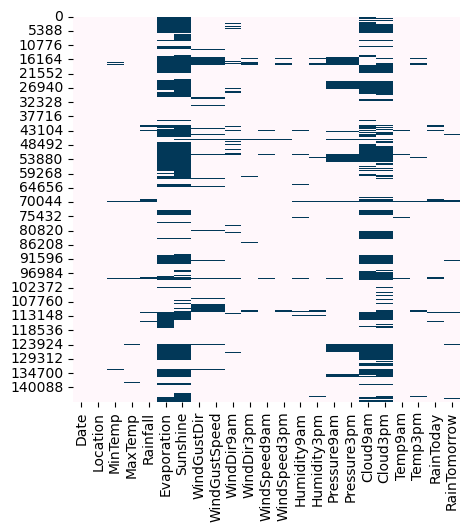

In [21]:
plt.figure(figsize=(5,5))
sns.heatmap(df.isnull(), cbar=False, cmap='PuBu')
plt.show()

From this plot we can understand that columns **Evaporation**, **Sunshine**, **Pressure3pm**, **Pressure9am**, **Cloud9am** and **Cloud3pm** contain a lot of NaN values. Other columns also contain them but in a smaller percentage.

Let's see the percentage of null values for each column.

In [22]:
# create a table with data missing 
missing_values = df.isnull().sum() # missing values

percent_missing = df.isnull().sum()/df.shape[0]*100 # missing value %

value = {
    'missing_values ':missing_values,
    'percent_missing %':percent_missing , 
     'data type' : df.dtypes
}
frame=pd.DataFrame(value)
frame

missing_values   percent_missing % data type
Date                         0           0.000000    object
Location                     0           0.000000    object
MinTemp                   1485           1.020899   float64
MaxTemp                   1261           0.866905   float64
Rainfall                  3261           2.241853   float64
Evaporation              62790          43.166506   float64
Sunshine                 69835          48.009762   float64
WindGustDir              10326           7.098859    object
WindGustSpeed            10263           7.055548   float64
WindDir9am               10566           7.263853    object
WindDir3pm                4228           2.906641    object
WindSpeed9am              1767           1.214767   float64
WindSpeed3pm              3062           2.105046   float64
Humidity9am               2654           1.824557   float64
Humidity3pm               4507           3.098446   float64
Pressure9am              15065          10.356799   float64
Pressure3pm              15028          10.331363   float64
Cloud9am                 55888          38.421559   float64
Cloud3pm                 59358          40.807095   float64
Temp9am                   1767           1.214767   float64
Temp3pm                   3609           2.481094   float64
RainToday                 3261           2.241853   float64
RainTomorrow              3267           2.245978   float64

Now, we distinguish categorical and numerical features. In this we work separately with them.

In [23]:
categorical, contin=[],[]

for i in df.columns:
    
    if df[i].dtype == 'object':
        categorical.append(i)
    else:
        contin.append(i)
        
print(categorical)
print(contin)

['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow']


Now, we explore problems on categorical features.

Missing values in categorical features:

In [24]:
(df[categorical].isnull().sum()/len(df[categorical])*100)

Date           0.000000
Location       0.000000
WindGustDir    7.098859
WindDir9am     7.263853
WindDir3pm     2.906641
dtype: float64

We can fill missing values in categorical features with the mode

In [25]:
for i in categorical:
    df[i].fillna(df[i].mode()[0], inplace=True)

And we convert them into continuous by using *LabelEncoder* function.

In [26]:
lencoders = {}
for col in df.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    df[col] = lencoders[col].fit_transform(df[col])

Now, we can consider problems in numerical features:

In [27]:
(df[contin].isnull().sum()/len(df[contin])*100)

MinTemp           1.020899
MaxTemp           0.866905
Rainfall          2.241853
Evaporation      43.166506
Sunshine         48.009762
WindGustSpeed     7.055548
WindSpeed9am      1.214767
WindSpeed3pm      2.105046
Humidity9am       1.824557
Humidity3pm       3.098446
Pressure9am      10.356799
Pressure3pm      10.331363
Cloud9am         38.421559
Cloud3pm         40.807095
Temp9am           1.214767
Temp3pm           2.481094
RainToday         2.241853
RainTomorrow      2.245978
dtype: float64

Since columns **RainToday** and **RainTomorrow** contain only $2$% of null values, I prefer to drop them.

In [28]:
df = df.dropna(subset=['RainToday', 'RainTomorrow'])

For the other values we use the **Multiple Imputation by Chained Equations (MICE)** of *Scikit-Learn* library. 

This is a strategy for imputing missing values by modeling each feature with missing values as a function of other features in a round-robin fashion.
- You basically take the variable that contains missing values as a response $Y$ and other variables as predictors $X$.
- Build a model with rows where $Y$ is not missing
- Then predict the missing observations by using the trained model

Do this multiple times by doing random draws of the data and taking the mean of the predictions.

In [29]:
# Multiple Imputation by Chained Equations
mice_imputer = IterativeImputer(max_iter=1000)
df.iloc[:,:] = mice_imputer.fit_transform(df)

#for i in contin:
    #df[i].fillna(df[i].median(), inplace=True)

Final check

In [30]:
# create a table with data missing 
missing_values=df.isnull().sum() # missing values

percent_missing = df.isnull().sum()/df.shape[0]*100 # missing value %

value = {
    'missing_values ':missing_values,
    'percent_missing %':percent_missing , 
     'data type' : df.dtypes
}
frame=pd.DataFrame(value)
frame

missing_values   percent_missing % data type
Date                         0                0.0     int64
Location                     0                0.0     int64
MinTemp                      0                0.0   float64
MaxTemp                      0                0.0   float64
Rainfall                     0                0.0   float64
Evaporation                  0                0.0   float64
Sunshine                     0                0.0   float64
WindGustDir                  0                0.0     int64
WindGustSpeed                0                0.0   float64
WindDir9am                   0                0.0     int64
WindDir3pm                   0                0.0     int64
WindSpeed9am                 0                0.0   float64
WindSpeed3pm                 0                0.0   float64
Humidity9am                  0                0.0   float64
Humidity3pm                  0                0.0   float64
Pressure9am                  0                0.0   float64
Pressure3pm                  0                0.0   float64
Cloud9am                     0                0.0   float64
Cloud3pm                     0                0.0   float64
Temp9am                      0                0.0   float64
Temp3pm                      0                0.0   float64
RainToday                    0                0.0   float64
RainTomorrow                 0                0.0   float64

Let's find **outliers**

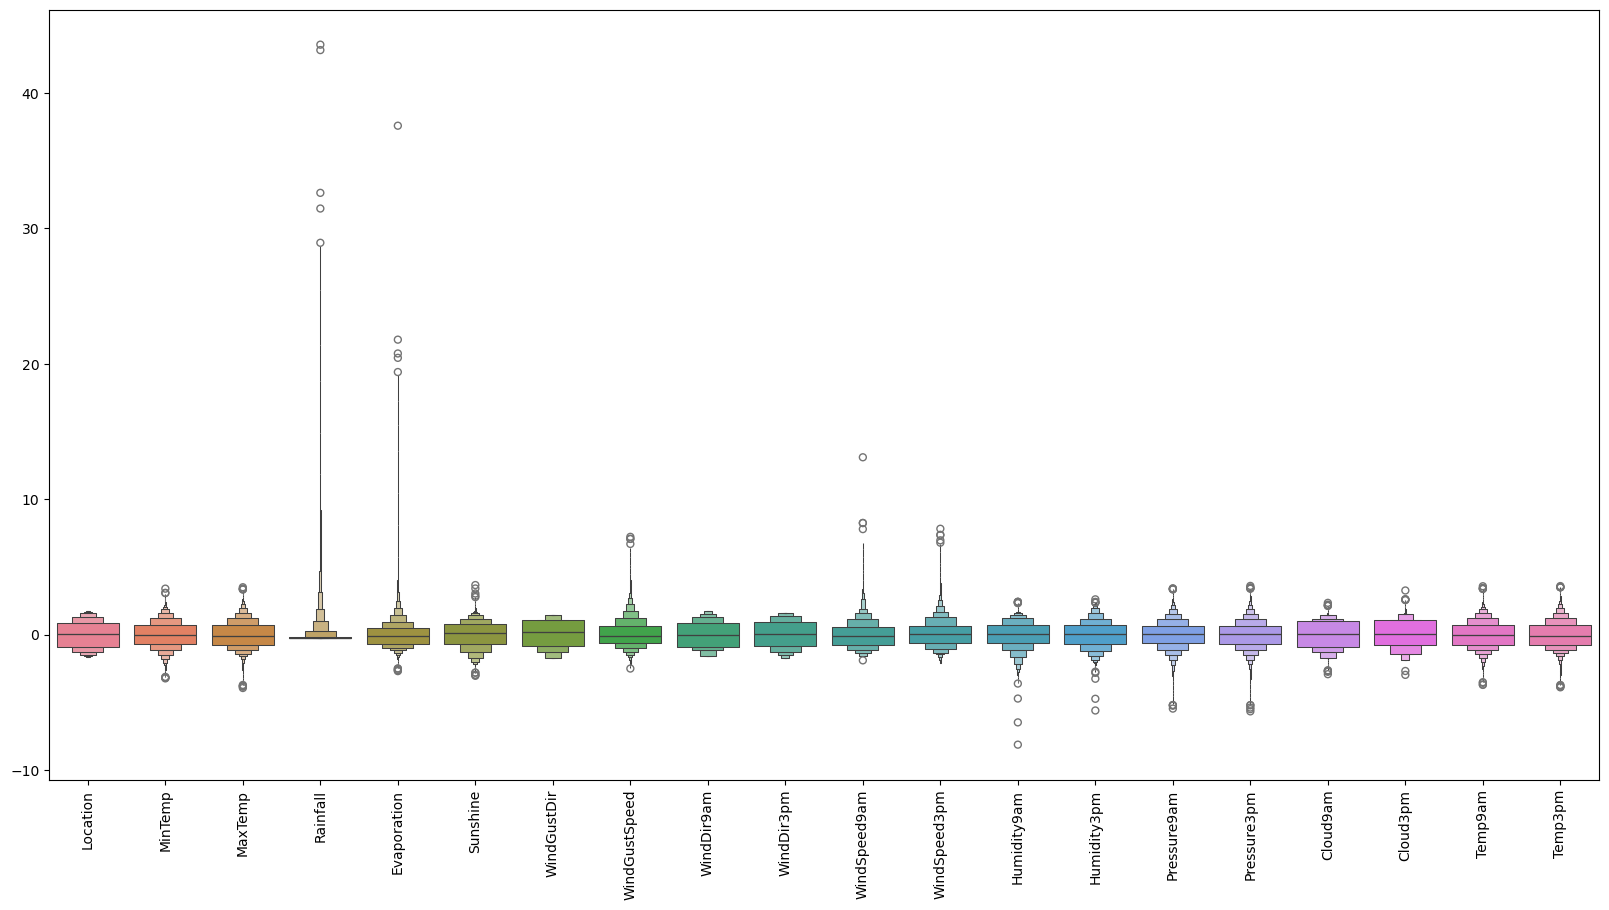

In [31]:
# Prepairing attributes of scale data

features = df.drop(['RainTomorrow','RainToday','Date'], axis=1) # dropping target and extra columns

# Set up a standard scaler for the features
col_names = list(features.columns)
s_scaler = StandardScaler()
features = s_scaler.fit_transform(features)
features = pd.DataFrame(features, columns=col_names) 


plt.figure(figsize=(20,10))
sns.boxenplot(data = features)
plt.xticks(rotation=90)
plt.show()

From this first chart we can see that, in particular, columns **Rainfall**, **Evaporation** and **WindSpeed9am** are caracterised with an high value of outliers.

Now, in order to fix outliers, we add three functions, which use $IQR$ method:
- **outlier_thresholds**: this function calculates, for the specific column of the dataset, its first and third quantile and the Interquantile Range. $IQR$ is defined as the range between the first quartile ($Q1$) and the third quartile ($Q3$) in a dataset. To find the boundaries for identifying potential outliers based on the $IQR$, a common rule of thumb is to consider values outside the range: 
$$[Q1 - 1.5 * IQR,\quad Q3 + 1.5 * IQR]$$

- **check_outliers**: this function verifies that in a specific column there are outliers by checking if there are values outside the previous range. It returns True if there are outliers in that specific column otherwise False

- **replace_with_thresholds**: a common practice is to replace outliers with the specific threshold. In particular, values that are lower than the lower bound are substituted with the lower bound and values that are bigger than the upper bound are replaced with the upper bound.

In [32]:
# Outlier Equation
def outlier_thresholds (dataframe, column, q1=0.25, q3=0.75) :
    quartile1 = dataframe[column].quantile(q1)
    quartile3 = dataframe[column].quantile(q3)
    interquartile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquartile_range
    low_limit = quartile1 - 1.5 * interquartile_range
    return low_limit, up_limit

# Checking Outliers
def check_outlier(dataframe, column):
    low_limit, up_limit = outlier_thresholds(dataframe, column)
    outliers = (dataframe[column] > up_limit) | (dataframe[column] < low_limit)
    if outliers.any():
        return True
    else:
        return False

# Replace with threshold
def replace_with_thresholds (dataframe, column) :
    low_limit , up_limit = outlier_thresholds(dataframe, column)
    dataframe.loc[(dataframe[column] < low_limit), column] = low_limit
    dataframe.loc[(dataframe[column] > up_limit), column] = up_limit

# Replace with median
def replace_with_median(dataframe, column):
    low_limit, up_limit = outlier_thresholds(dataframe, column)
    median_value = dataframe[column].mean()
    dataframe.loc[(dataframe[column] < low_limit), column] = median_value
    dataframe.loc[(dataframe[column] > up_limit), column] = median_value

In [33]:
print('Before removing the outliers :')
for column in (df.drop(columns = ['RainTomorrow', 'RainToday', 'Date', 'Location']).columns):
    print(column, check_outlier(df, column))

Before removing the outliers :
MinTemp True
MaxTemp True
Rainfall True
Evaporation True
Sunshine True
WindGustDir False
WindGustSpeed True
WindDir9am False
WindDir3pm False
WindSpeed9am True
WindSpeed3pm True
Humidity9am True
Humidity3pm True
Pressure9am True
Pressure3pm True
Cloud9am False
Cloud3pm False
Temp9am True
Temp3pm True


In [34]:
print('After removing the outliers :')
for column in (df.drop(columns = ['RainTomorrow', 'RainToday', 'Date', 'Location']).columns):
    replace_with_thresholds(df, column)
    print(column, check_outlier(df, column))

After removing the outliers :
MinTemp False
MaxTemp False
Rainfall False
Evaporation False
Sunshine False
WindGustDir False
WindGustSpeed False
WindDir9am False
WindDir3pm False
WindSpeed9am False
WindSpeed3pm False
Humidity9am False
Humidity3pm False
Pressure9am False
Pressure3pm False
Cloud9am False
Cloud3pm False
Temp9am False
Temp3pm False


Final check

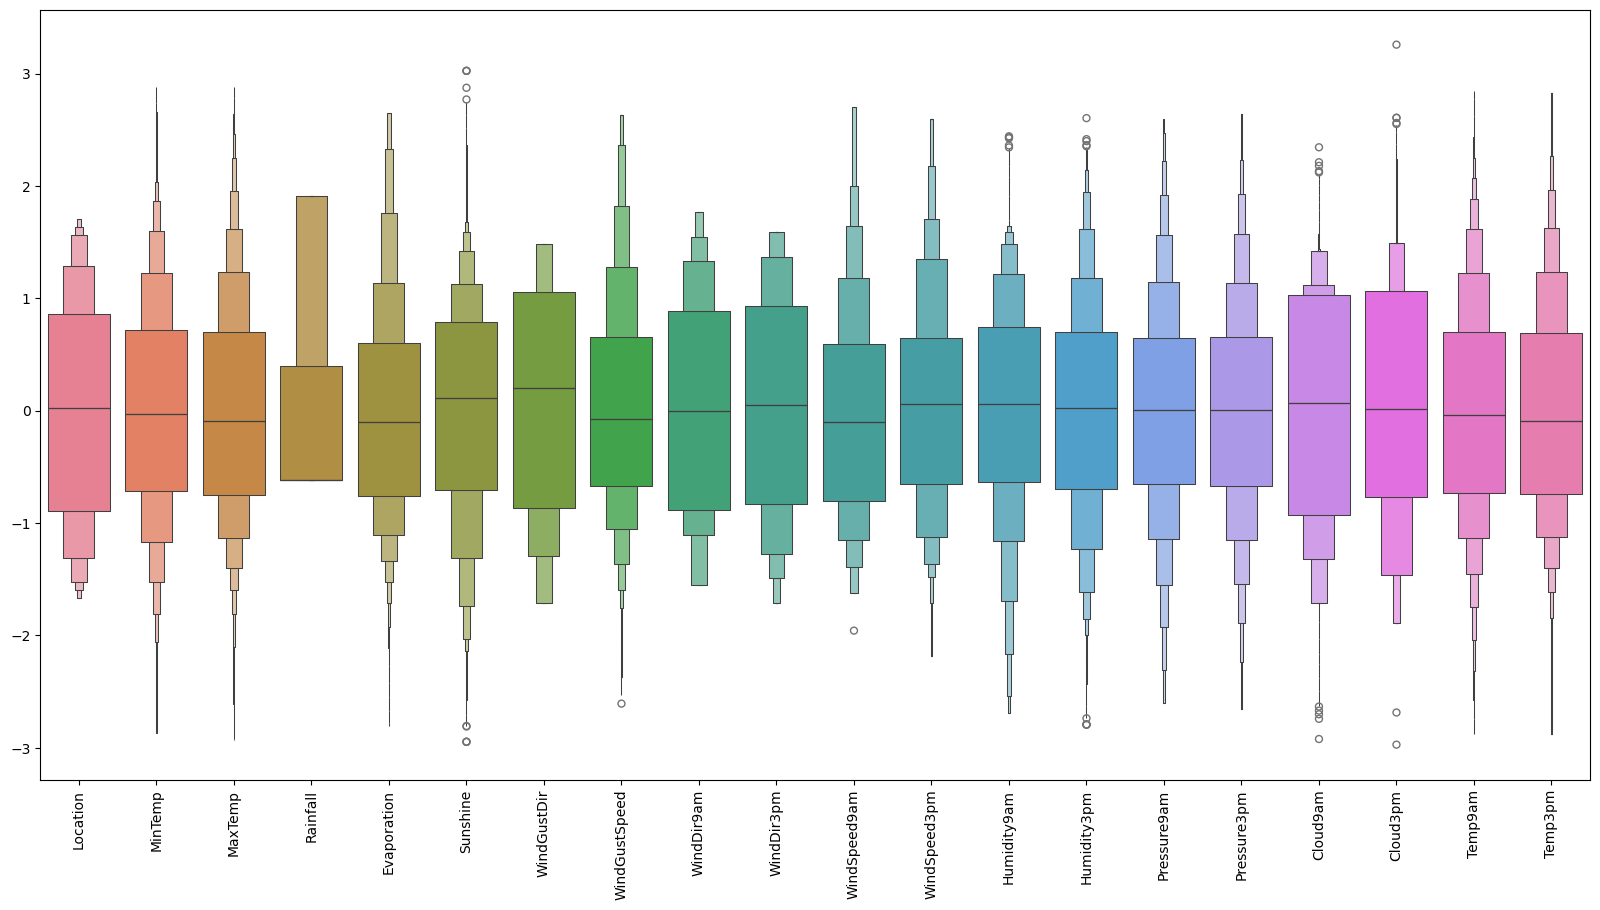

In [35]:
features = df.drop(['RainTomorrow','RainToday','Date'], axis=1) # dropping target and extra columns

# Set up a standard scaler for the features
col_names = list(features.columns)
s_scaler = StandardScaler()
features = s_scaler.fit_transform(features)
features = pd.DataFrame(features, columns=col_names) 

#Detecting outliers

plt.figure(figsize=(20,10))
sns.boxenplot(data = features)
plt.xticks(rotation=90)
plt.show()

Now, we try to explore **Multicollinearity problem**

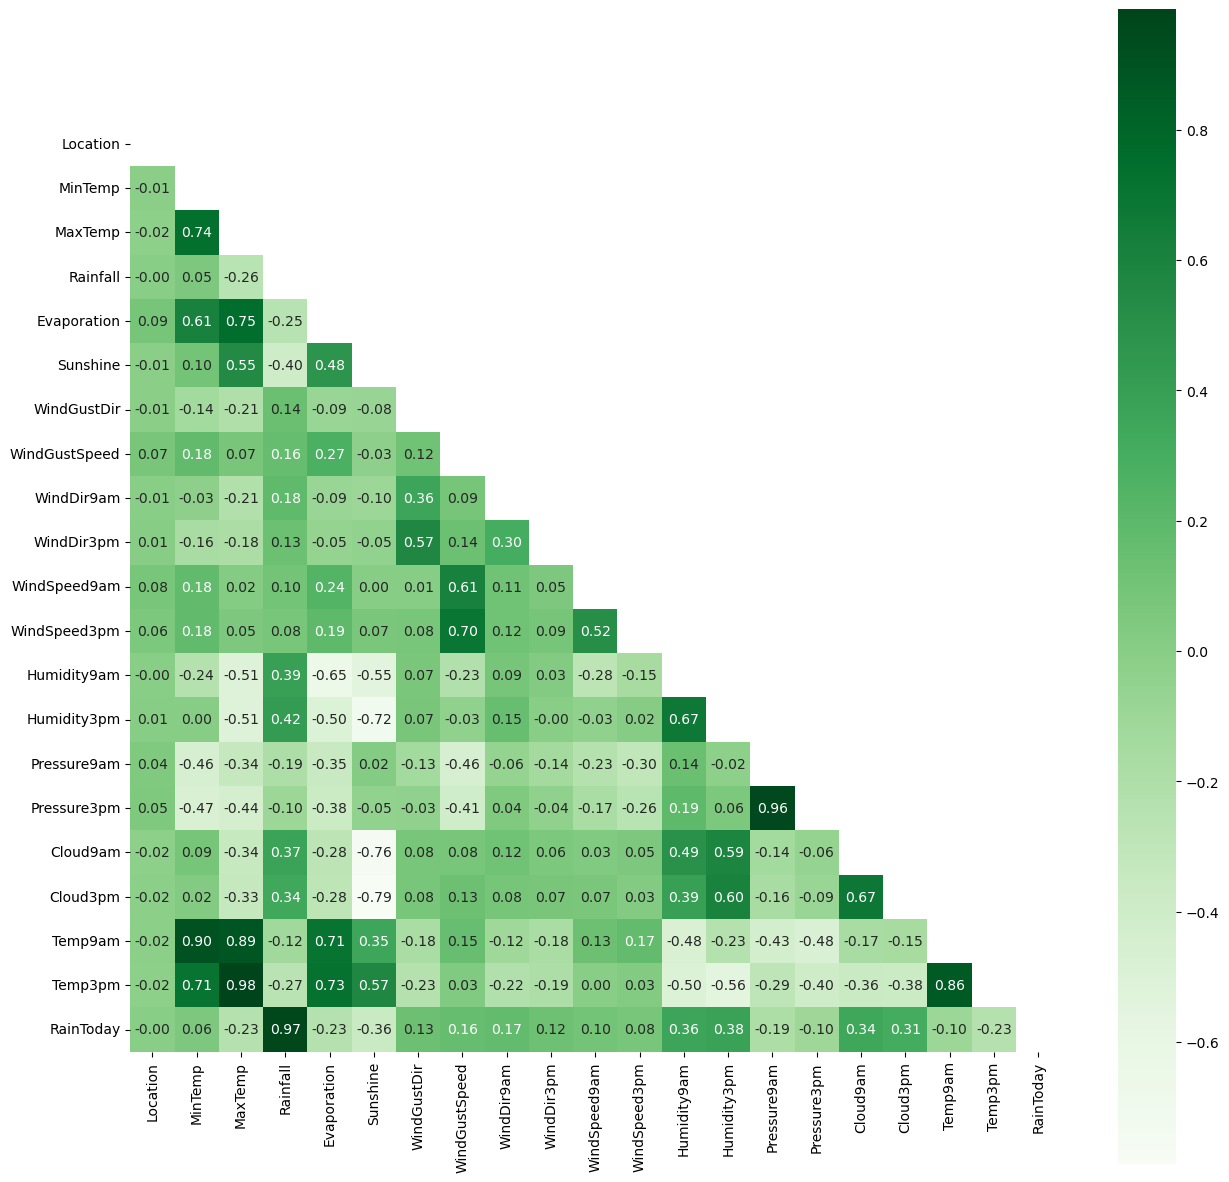

In [36]:
corr = df.drop(['RainTomorrow', 'Date'], axis=1).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(15,15))
ax = sns.heatmap(corr, mask=mask, square=True, annot=True, fmt='.2f', cmap='Greens')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

From the matrix we can observe that some features are higly correlated. 

So, we can adopt the **VIF** method or *Variance Inflaction Factor*. In VIF method, we pick each feature and regress it against all of the other features. For each regression, the factor is calculated as :
$$ VIF = \frac{1}{1 - R^2}$$
As we see from the formula, greater the value of $R^2$, greater is the $VIF$. Hence, greater $VIF$ denotes greater correlation.

In [37]:
# add a constant
X = add_constant(df.drop(['RainTomorrow'], axis=1))

# for each column we calculate the vif value
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


          feature           VIF
0           const  43000.933464
1            Date      1.019089
2        Location      1.048043
3         MinTemp     10.915623
4         MaxTemp     49.509326
5        Rainfall     16.580866
6     Evaporation      3.826661
7        Sunshine      5.563556
8     WindGustDir      1.626109
9   WindGustSpeed      3.057047
10     WindDir9am      1.296399
11     WindDir3pm      1.650072
12   WindSpeed9am      1.946910
13   WindSpeed3pm      2.283799
14    Humidity9am      4.634240
15    Humidity3pm      6.831019
16    Pressure9am     24.275623
17    Pressure3pm     23.138382
18       Cloud9am      2.941021
19       Cloud3pm      3.098813
20        Temp9am     23.135183
21        Temp3pm     55.815780
22      RainToday     15.481261


Now, step by step, we select the variable with the highest $VIF$ value and we remove it. In this way, we saw that deleting **Temp3pm**, **Temp9am**, **Pressure9am** and **Rainfall** features produced an important decrease.

In [38]:
df_reduced = df.drop(['Temp3pm', 'Pressure9am', 'Temp9am', 'Rainfall'], axis=1)

X_reduced = add_constant(df_reduced.drop(['RainTomorrow'], axis=1))
vif_data_reduced = pd.DataFrame()
vif_data_reduced["feature"] = X_reduced.columns
vif_data_reduced["VIF"] = [variance_inflation_factor(X_reduced.values, i) for i in range(X_reduced.shape[1])]

print(vif_data_reduced)


          feature           VIF
0           const  40994.929955
1            Date      1.017247
2        Location      1.047645
3         MinTemp      5.633780
4         MaxTemp      8.086556
5     Evaporation      3.622636
6        Sunshine      5.388329
7     WindGustDir      1.609030
8   WindGustSpeed      2.967927
9      WindDir9am      1.275793
10     WindDir3pm      1.559342
11   WindSpeed9am      1.923658
12   WindSpeed3pm      2.205593
13    Humidity9am      2.857733
14    Humidity3pm      4.017702
15    Pressure3pm      1.686417
16       Cloud9am      2.897327
17       Cloud3pm      3.007988
18      RainToday      1.362563


So we can drop them

In [39]:
df.drop(['Temp3pm', 'Pressure9am', 'Temp9am', 'Rainfall'], axis=1, inplace=True)

# Machine Learning
Now we can focus our attention on predicting the target column **RainTomorrow** by using different ML algorithm.

In [40]:
df.drop('Date',axis = 1, inplace = True)

## Data Preprocessing

From the chart we can see that we have the problem of **IMBALACED DATASET**.

This aspect is a problem in the field of Machine Learning because when we try to apply any prediction algorithm we will notice that it will predict the majority class well, but not the minority.

This is because the algorithm was trained on an instance that had a majority of 'NO' cases.

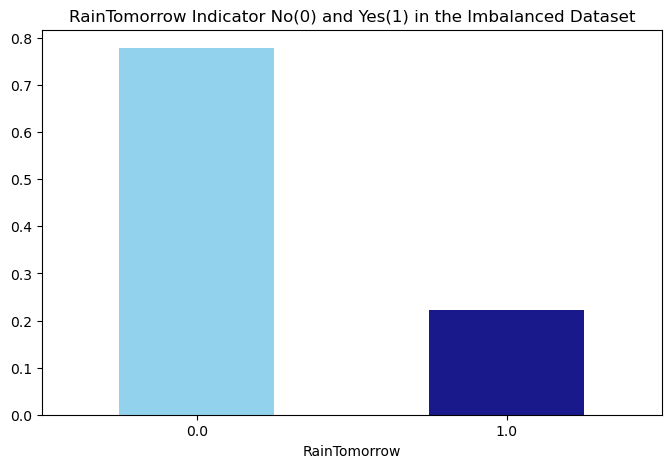

In [41]:
fig = plt.figure(figsize = (8,5))
df.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) in the Imbalanced Dataset')
plt.show()

But **BEFORE** trying to use some skills to avoid this problem we have to split the data into train and test set:

### Divide the data into train and test set

In [42]:
X = df.drop('RainTomorrow', axis = 1)
y = df['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=df['RainTomorrow'])

print('X_train size', X_train.shape)
print('y_train size', y_train.shape)
print('X_test size', X_test.shape)
print('y_test size', y_test.shape)

X_train size (105590, 17)
y_train size (105590,)
X_test size (35197, 17)
y_test size (35197,)


### Rebalance the data
Now we can try to apply some skills to avoid imbalanced dataset. We are going to use **SMOTE** and **UNDERSAMPLE** on the train set, not to the test set. If we use SMOTE on the whole dataset before splitting, some synthetic samples will end up in the test set, leading to overly optimistic results.

#### Synthetic Minority Oversampling Technique (SMOTE)
SMOTE is an oversampling technique where the synthetic samples are generated for the minority class. 
- At first, the total number of oversampling observations $N$ is set up. Generally, it is selected such that the binary class distribution is $1:1$.

- Then the iteration starts by first selecting a positive class instance at random.

- Next, the **KNN’s** (by default 5) for that instance is obtained.

-  At last, $N$ of these $K$ instances is chosen to interpolate new synthetic instances. To do that, using any distance metric the difference in distance between the feature vector and its neighbors is calculated. Now, this difference is multiplied by any random value in $(0,1]$ and is added to the previous feature vector.

<img src="./screenshot.png" alt="Esempio di immagine" width="400"/>

In [43]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Class Distribution after SMOTE:", y_train_smote.value_counts())

print('X_train size', X_train_smote.shape)
print('y_train size', y_train_smote.shape)
print('X_test size', X_test.shape)
print('y_test size', y_test.shape)

Class Distribution after SMOTE: RainTomorrow
0.0    82189
1.0    82189
Name: count, dtype: int64
X_train size (164378, 17)
y_train size (164378,)
X_test size (35197, 17)
y_test size (35197,)


#### Undersample
An other way of handling imbalanced datasets is to reduce the number of observations from the majority class to the minority class ones.

The most well known algorithm in this group is random undersampling, where samples from the targeted classes are removed at random.

In [44]:
rus = RandomUnderSampler(random_state=42, sampling_strategy = 'majority')

X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

print("Class Distribution after undersample:", y_train_under.value_counts())

print('X_train size', X_train_under.shape)
print('y_train size', y_train_under.shape)
print('X_test size', X_test.shape)
print('y_test size', y_test.shape)

Class Distribution after undersample: RainTomorrow
0.0    23401
1.0    23401
Name: count, dtype: int64
X_train size (46802, 17)
y_train size (46802,)
X_test size (35197, 17)
y_test size (35197,)


### Standardize them
By using *StandardScaler* we apply standardization to the three different models, i.e. **no resample datset**, **SMOTE dataset** and **undersample dataset**.

In [45]:
# Standardize the original training set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Standardize the SMOTE training set
scaler_smote = StandardScaler()
X_train_smote_scaled = scaler_smote.fit_transform(X_train_smote)
X_test_smote_scaled = scaler_smote.transform(X_test)

# Standardize the under-sampled training set
scaler_under = StandardScaler()
X_train_under_scaled = scaler_under.fit_transform(X_train_under)
X_test_under_scaled = scaler_under.transform(X_test)

### Model Evaluation Class
This class train and test the selected model and generates the most important metrics:
- **Accuracy**: it calculates the fraction of correct prediction
    $$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$
- **Precision**: in words, precision answers the question: "Out of all the instances predicted as positive by the model, how many were actually positive?". It is particularly important in situations where the cost of false positives (instances predicted as positive but are actually negative) is high, and you want to minimize the chances of making false positive predictions.
    $$Precision = \frac{TP}{TP + FP}$$
- **Recall**: in words, recall answers the question: "Out of all the actual positive instances, how many did the model correctly identify?". It is particularly important in situations where the cost of missing positive instances (false negatives) is high, and you want to minimize the chances of false negatives.
    $$Recall = \frac{TP}{TP + FN}$$
- **F1**: the F1 score provides a balance between precision and recall. It ranges from $0$ to $1$, where $1$ indicates perfect precision and recall, and $0$ indicates poor performance
    $$F1 = 2\times\frac{Precision \times Recall}{Precision \times Recall}$$

In [46]:
class Model:
    def __init__(self, model, name = None, scaled = True, resample = None):
        self.model = model
        self.name = name
        self.scaled = scaled
        self.resample = resample
    def fit(self):
        if self.scaled == True and self.resample == None:
            self.model.fit(X_train_scaled, y_train)
        if self.scaled == False and self.resample == None:
            self.model.fit(X_train, y_train)
        if self.scaled == True and self.resample == 'smote':
            self.model.fit(X_train_smote_scaled, y_train_smote)
        if self.scaled == False and self.resample == 'smote':
            self.model.fit(X_train_smote, y_train_smote)
        if self.scaled == True and self.resample == 'under':
            self.model.fit(X_train_under_scaled, y_train_under)
        if self.scaled == False and self.resample == 'under':
            self.model.fit(X_train_under, y_train_under)
    def __get_predictions(self):
        if self.scaled == True and self.resample == None:
            return self.model.predict(X_test_scaled), self.model.predict_proba(X_test_scaled)[:,1]
        if self.scaled == False and self.resample == None:
            return self.model.predict(X_test), self.model.predict_proba(X_test)[:,1]
        if self.scaled == True and self.resample == 'smote':
            return self.model.predict(X_test_smote_scaled), self.model.predict_proba(X_test_smote_scaled)[:,1]
        if self.scaled == False and self.resample == 'smote':
            return self.model.predict(X_test), self.model.predict_proba(X_test)[:,1]
        if self.scaled == True and self.resample == 'under':
            return self.model.predict(X_test_under_scaled), self.model.predict_proba(X_test_under_scaled)[:,1]
        if self.scaled == False and self.resample == 'under':
            return self.model.predict(X_test), self.model.predict_proba(X_test)[:,1]
    def get_metrics(self) -> pd.Series:
        y_pred, y_probs = self.__get_predictions()
        accuracy = metrics.accuracy_score(y_test, y_pred)
        precision = metrics.precision_score(y_test, y_pred)
        recall = metrics.recall_score(y_test, y_pred)
        f1 = metrics.f1_score(y_test, y_pred)
        roc_auc = metrics.roc_auc_score(y_test, y_probs)
        conf_mat = metrics.confusion_matrix(y_test, y_pred)
        pr_auc = metrics.average_precision_score(y_test, y_probs)
        metrics_series = pd.Series({
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'ROC AUC': roc_auc,
            'Confusion Matrix': conf_mat,
            'PR AUC': pr_auc,
            'Name': self.name
        })
        if self.name == '' or self.name is None:
            metrics_series.Name =type(self.model).__name__
        return metrics_series
    
    def visualize_metrics(self):
        y_pred, y_probs = self.__get_predictions()
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs)
        roc_auc = metrics.roc_auc_score(y_test, y_probs)
        # Calculate Precision-Recall curve and AUC
        precision, recall, _ = metrics.precision_recall_curve(y_test, y_probs)
        pr_auc = metrics.auc(recall, precision)
        # Plot ROC curve
        plt.figure(figsize=(20, 10))
        plt.subplot(2, 2, 1)
        plt.axis('equal')
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR)')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')

        # Plot Precision-Recall curve
        plt.subplot(2, 2, 2)
        plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc='lower left')

        residuals = y_test - y_probs
        # Plot Confusion Matrix and Distribution of errors
        plt.subplot(2, 2, 3)
        conf_mat = metrics.confusion_matrix(y_test, y_pred)
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Predicted 0', 'Predicted 1'],
                    yticklabels=['Actual 0', 'Actual 1'])
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.subplot(2, 2, 4)
        sns.histplot(residuals, bins=30, edgecolor='black', kde=True)
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        plt.title('Distribution of Errors')
        plt.show()

Here I create 3 different dataframe because for each ML algorithm that I'm going to use, I'm going to save the performance for each approach (No Resample, SMOTE, Undersample).

In [47]:
models_df = pd.DataFrame(columns=['Name',
    'Accuracy',
    'Precision',
    'Recall',
    'F1-Score',
    'ROC AUC',
    'Confusion Matrix',
    'PR AUC'])

models_df_smote = pd.DataFrame(columns=['Name',
    'Accuracy',
    'Precision',
    'Recall',
    'F1-Score',
    'ROC AUC',
    'Confusion Matrix',
    'PR AUC'])

models_df_under = pd.DataFrame(columns=['Name',
    'Accuracy',
    'Precision',
    'Recall',
    'F1-Score',
    'ROC AUC',
    'Confusion Matrix',
    'PR AUC'])

## Linear Discriminant Analysis (LDA)
A classifier with a linear decision boundary, generated by fitting class conditional densities to the data and using Bayes’ rule. In particular, the model fits a Gaussian density to each class, assuming that all classes share the same covariance matrix.

### No resample

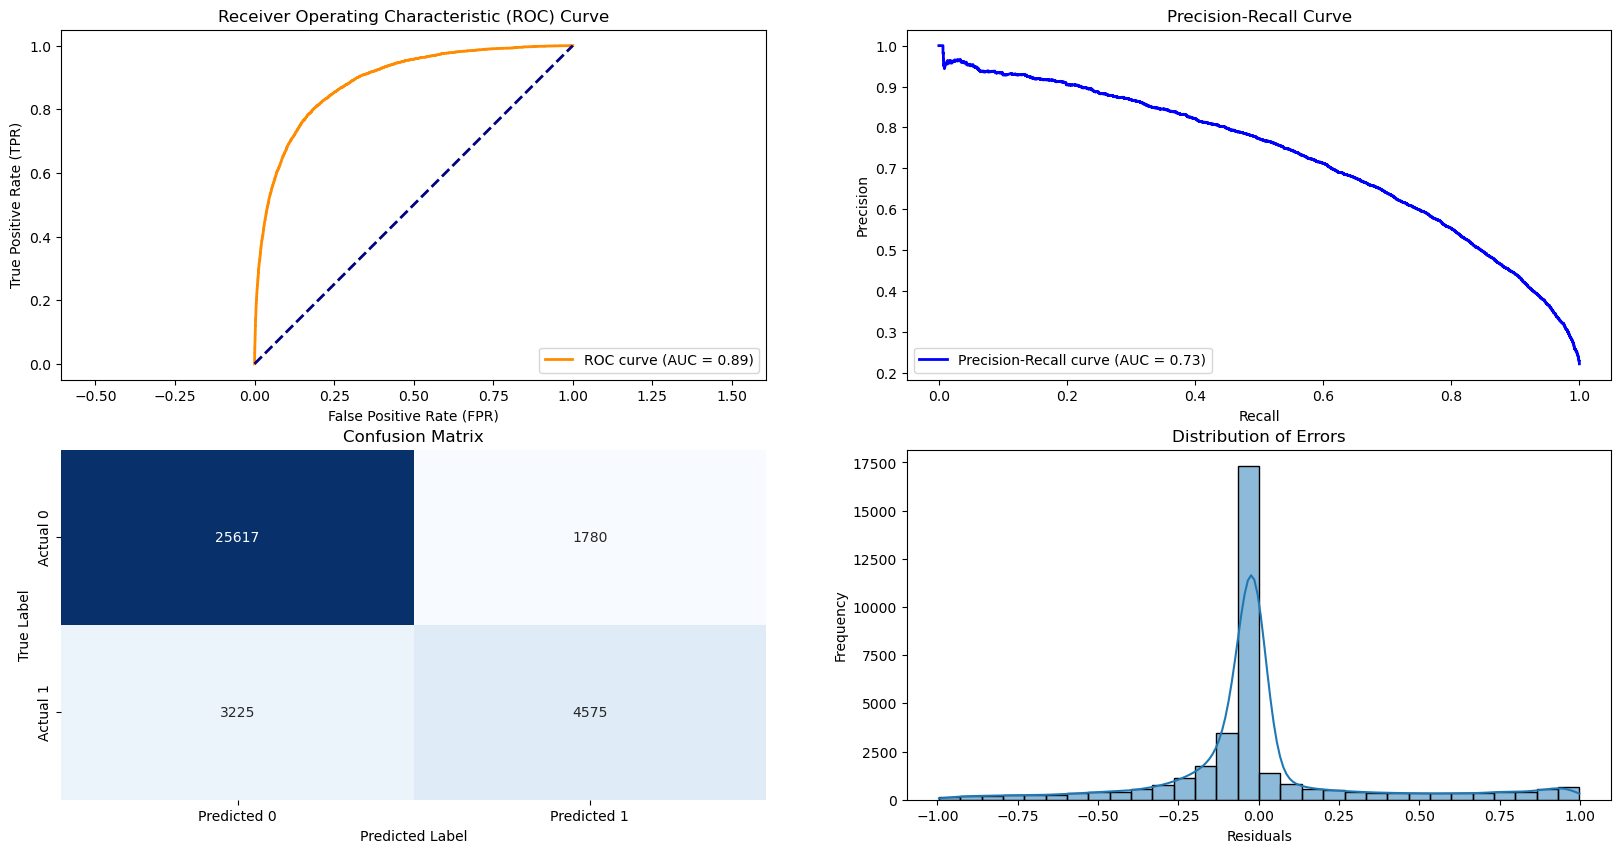

In [48]:
model = Model(LinearDiscriminantAnalysis(), name='LDA No Resample', scaled=True, resample=None)
model.fit()
model.visualize_metrics()

In [49]:
metrics_LDA_no_resample = model.get_metrics()
models_df = pd.concat([models_df, metrics_LDA_no_resample.to_frame().T])
print(metrics_LDA_no_resample)

Accuracy                                   0.8578
Precision                                0.719906
Recall                                   0.586538
F1-Score                                 0.646415
ROC AUC                                  0.888577
Confusion Matrix    [[25617, 1780], [3225, 4575]]
PR AUC                                   0.727093
Name                              LDA No Resample
dtype: object


### SMOTE

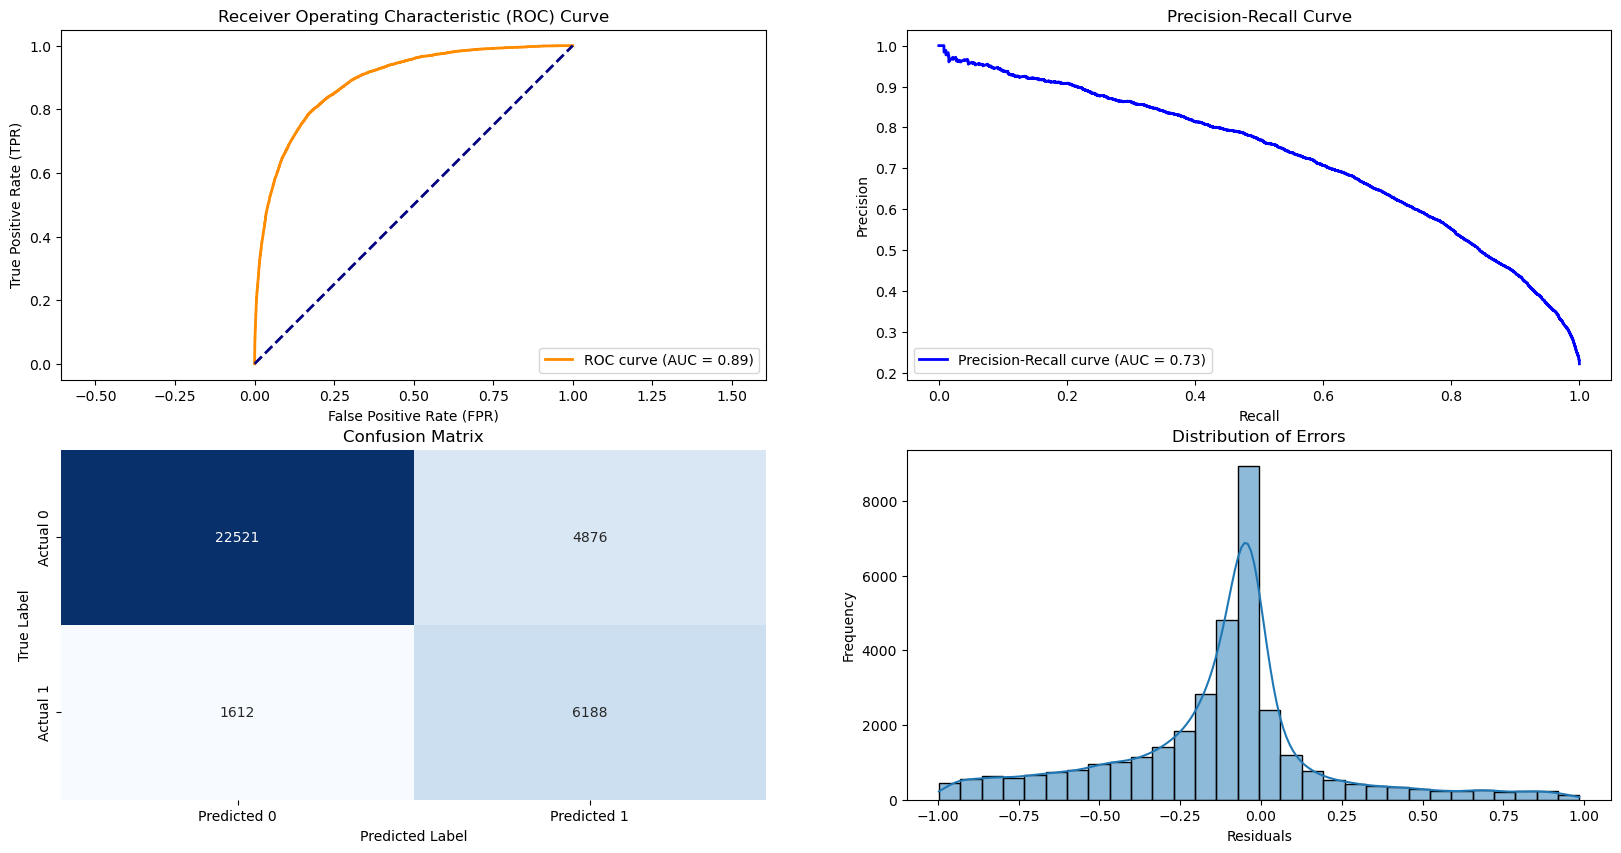

In [50]:
model = Model(LinearDiscriminantAnalysis(), name='LDA SMOTE', scaled=True, resample='smote')
model.fit()
model.visualize_metrics()

In [51]:
metrics_LDA_smote = model.get_metrics()
models_df_smote = pd.concat([models_df_smote, metrics_LDA_smote.to_frame().T])
print(metrics_LDA_smote)

Accuracy                                 0.815666
Precision                                0.559291
Recall                                   0.793333
F1-Score                                 0.656064
ROC AUC                                   0.88886
Confusion Matrix    [[22521, 4876], [1612, 6188]]
PR AUC                                   0.726089
Name                                    LDA SMOTE
dtype: object


### Undersample

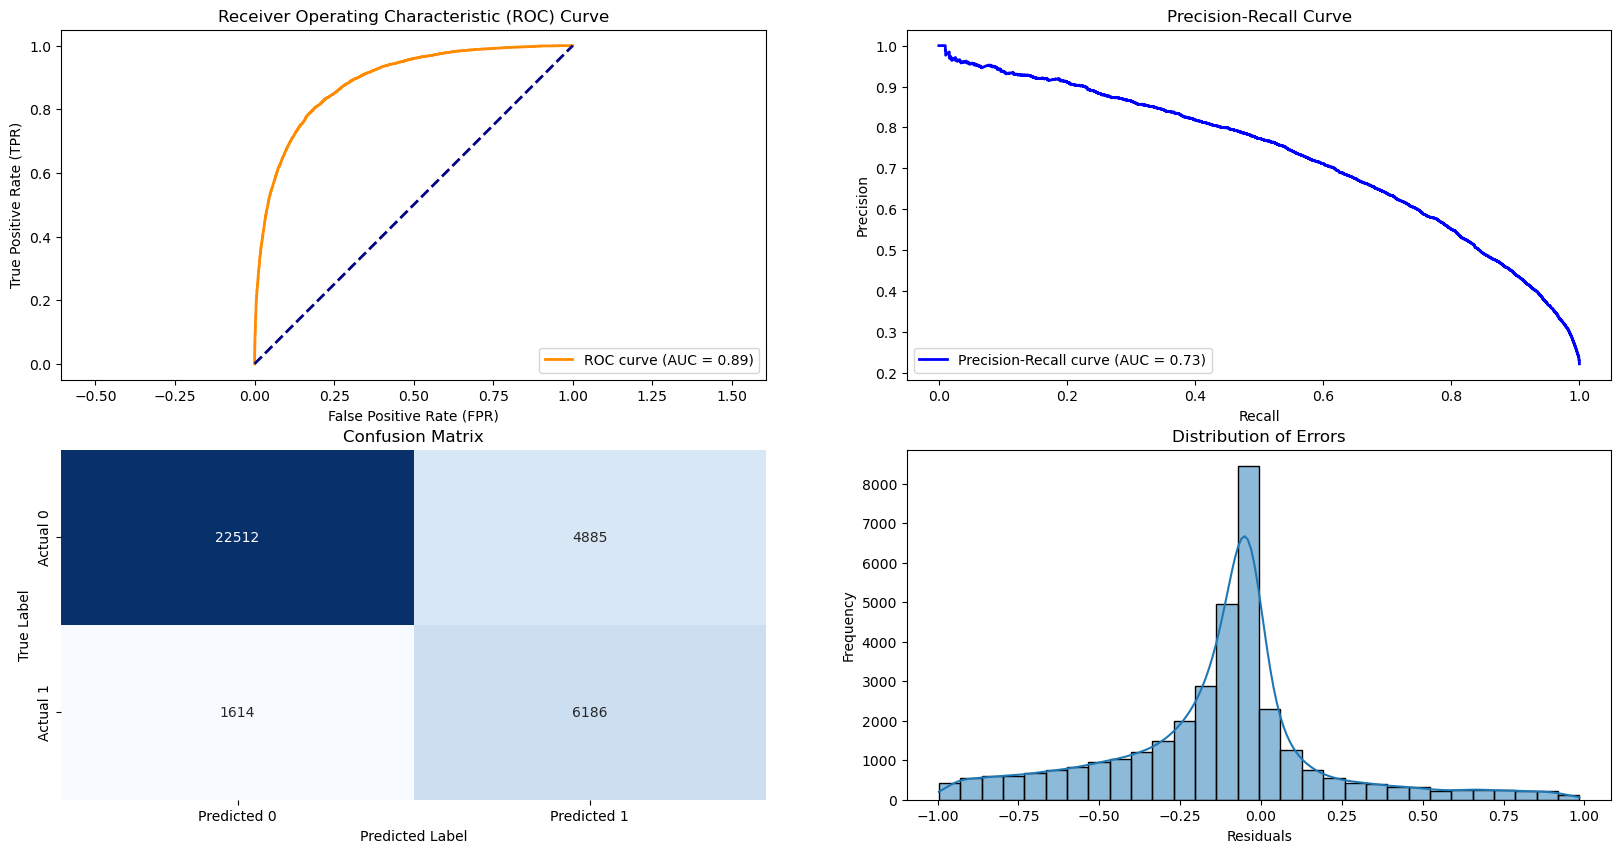

In [52]:
model = Model(LinearDiscriminantAnalysis(), name='LDA undersample', scaled=True, resample='under')
model.fit()
model.visualize_metrics()

In [53]:
metrics_LDA_under = model.get_metrics()
models_df_under = pd.concat([models_df_under, metrics_LDA_under.to_frame().T])
print(metrics_LDA_under)

Accuracy                                 0.815354
Precision                                0.558757
Recall                                   0.793077
F1-Score                                 0.655609
ROC AUC                                  0.889342
Confusion Matrix    [[22512, 4885], [1614, 6186]]
PR AUC                                   0.727967
Name                              LDA undersample
dtype: object


## Logistic Regression
It is a special case of linear regression where the target variable is categorical in nature. Logistic Regression predicts the probability of occurrence of a binary event utilizing the Sigmoid Function.

### No resample
In this case we perform *GridSearchCV* in order to establish the parameters of the model that performs better.

In [54]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l2'],  # Regularization penalty
    'solver': ['liblinear', 'lbfgs','newton-cg','newton-cholesky','sag','saga']  # Optimization algorithm
}
clf = GridSearchCV(LogisticRegression(), param_grid)
clf = clf.fit(X_train_scaled, y_train)
best_lr_model = clf.best_estimator_

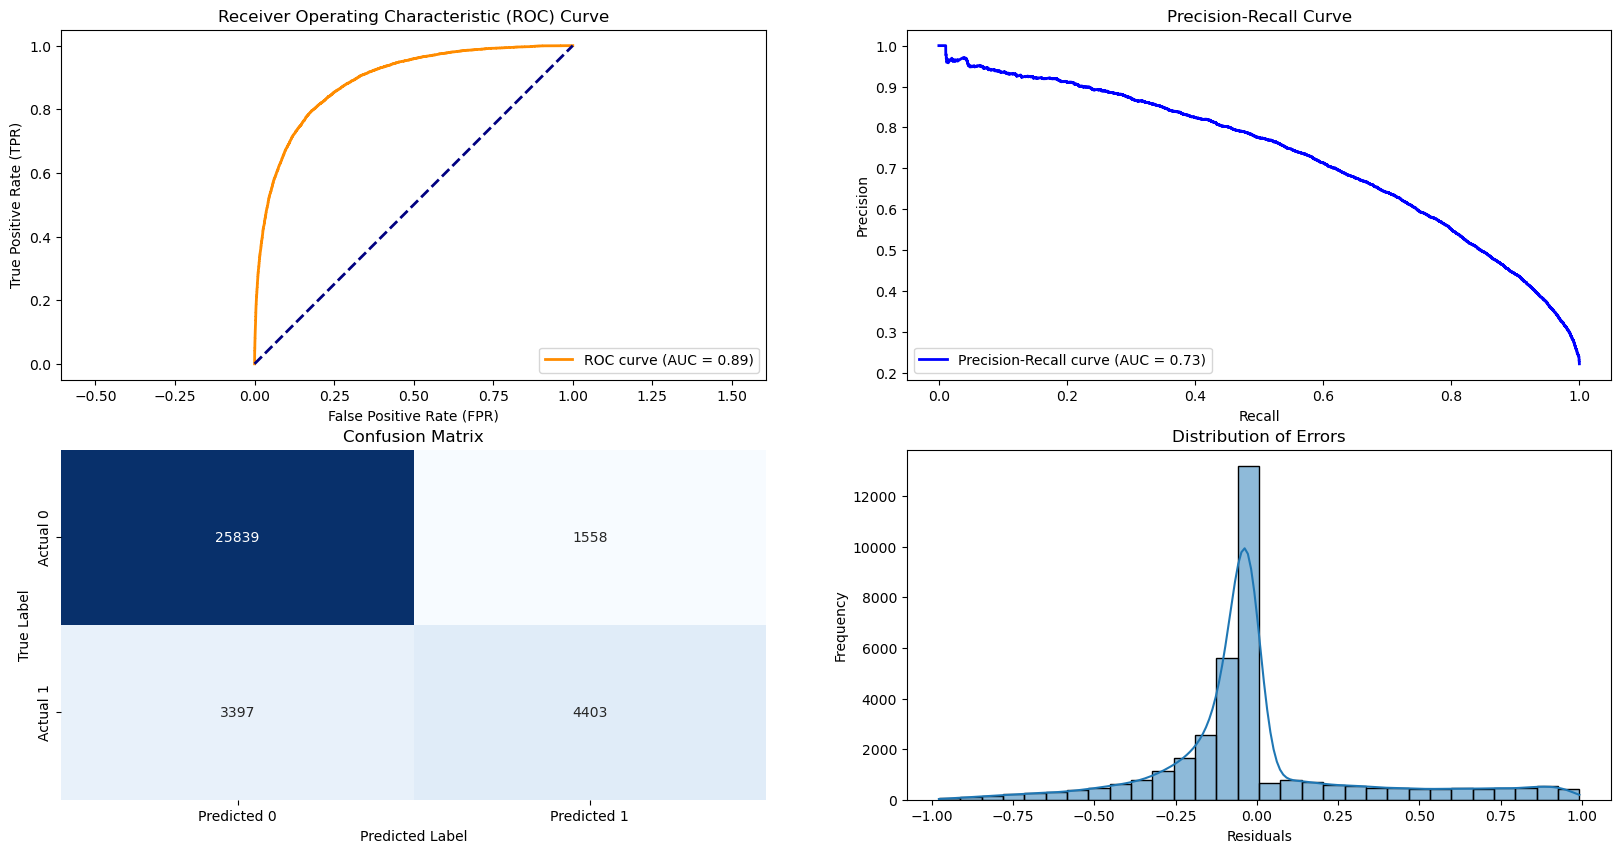

In [55]:
# Create the model
model = Model(best_lr_model, 
              name='Logistic Regression No Resample', 
              scaled=True, resample=None)
model.fit()
model.visualize_metrics()

In [56]:
metrics_LR_no_resample = model.get_metrics()
models_df = pd.concat([models_df, metrics_LR_no_resample.to_frame().T])
print(metrics_LR_no_resample)

Accuracy                                   0.859221
Precision                                  0.738634
Recall                                     0.564487
F1-Score                                   0.639924
ROC AUC                                    0.889739
Confusion Matrix      [[25839, 1558], [3397, 4403]]
PR AUC                                     0.729967
Name                Logistic Regression No Resample
dtype: object


### SMOTE

In [57]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l2'],  # Regularization penalty
    'solver': ['liblinear', 'lbfgs','newton-cg','newton-cholesky','sag','saga']  # Optimization algorithm
}
clf = GridSearchCV(LogisticRegression(), param_grid)
clf = clf.fit(X_train_smote_scaled, y_train_smote)
best_lr_model = clf.best_estimator_

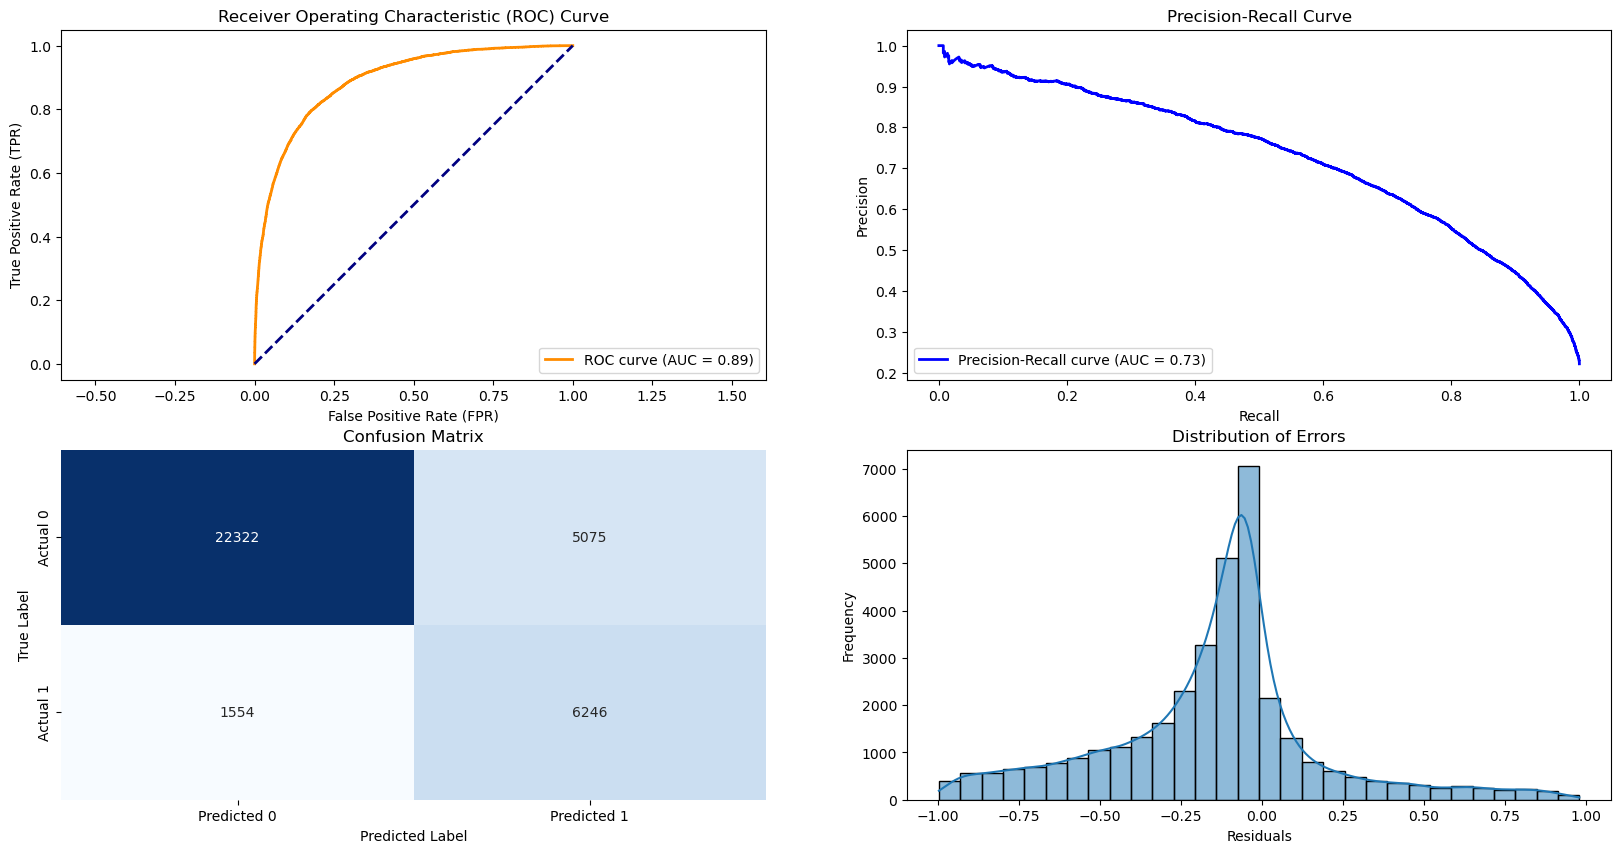

In [58]:
model = Model(best_lr_model, 
              name='Logistic Regression Smote', 
              scaled=True, resample='smote')
model.fit()
model.visualize_metrics()

In [59]:
metrics_LR_smote = model.get_metrics()
models_df_smote = pd.concat([models_df_smote, metrics_LR_smote.to_frame().T])
print(metrics_LR_smote)

Accuracy                                  0.81166
Precision                                0.551718
Recall                                   0.800769
F1-Score                                 0.653313
ROC AUC                                  0.889469
Confusion Matrix    [[22322, 5075], [1554, 6246]]
PR AUC                                   0.726918
Name                    Logistic Regression Smote
dtype: object


### Undersample

In [60]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l2'],  # Regularization penalty
    'solver': ['liblinear', 'lbfgs','newton-cg','newton-cholesky','sag','saga']  # Optimization algorithm
}
clf = GridSearchCV(LogisticRegression(), param_grid)
clf = clf.fit(X_train_under_scaled, y_train_under)
best_lr_model = clf.best_estimator_

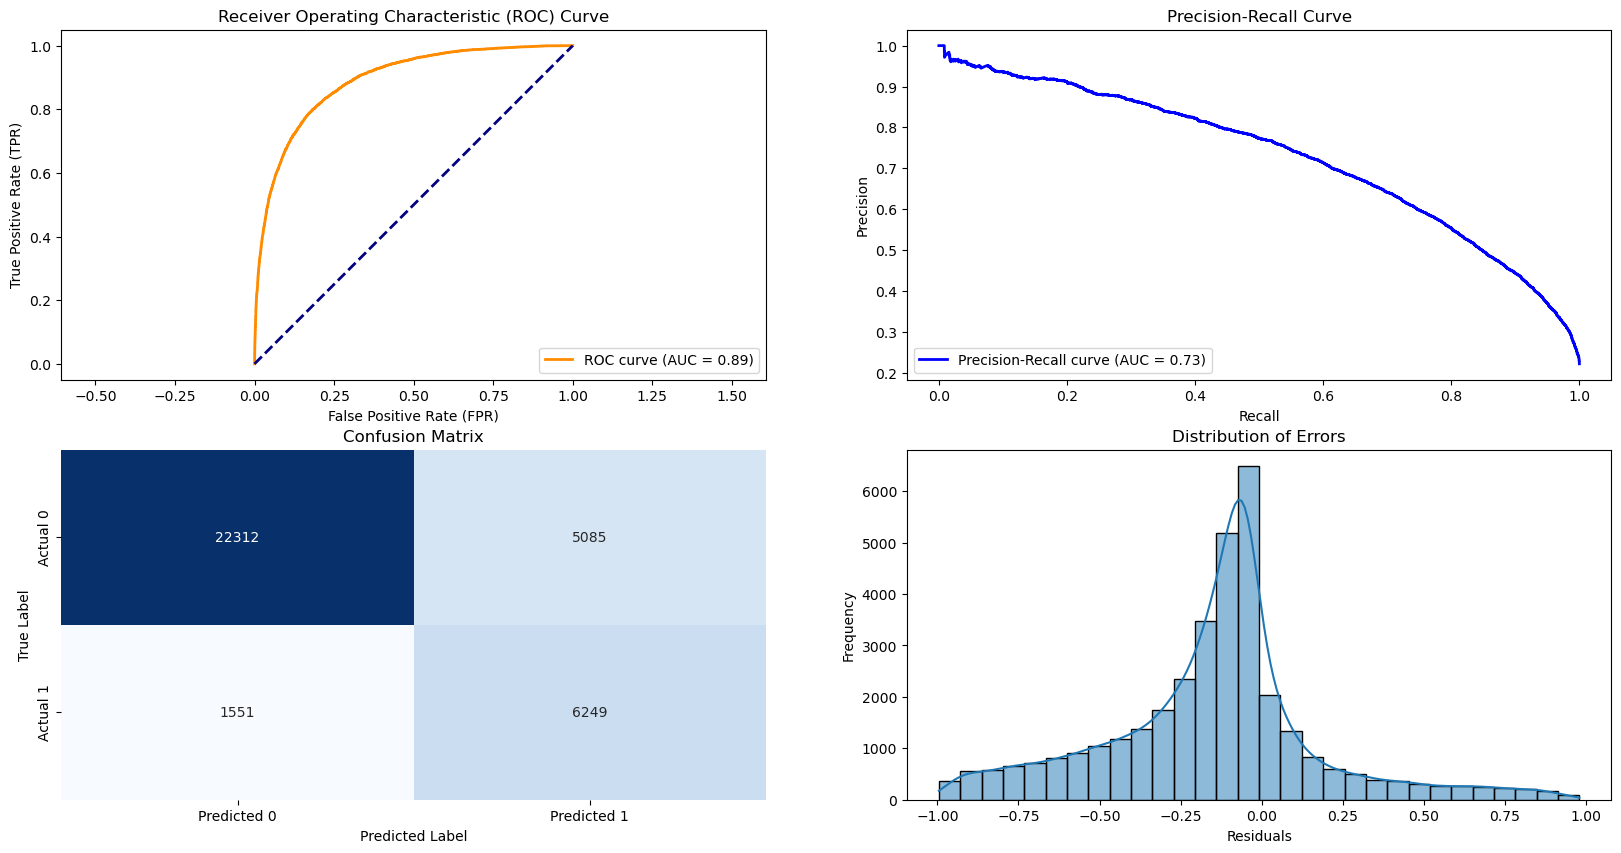

In [61]:
model = Model(best_lr_model, 
              name='Logistic Regression Undersample', 
              scaled=True, resample='under')
model.fit()
model.visualize_metrics()

In [62]:
metrics_LR_under = model.get_metrics()
models_df_under = pd.concat([models_df_under, metrics_LR_under.to_frame().T])
print(metrics_LR_under)

Accuracy                                   0.811461
Precision                                   0.55135
Recall                                     0.801154
F1-Score                                   0.653183
ROC AUC                                    0.889934
Confusion Matrix      [[22312, 5085], [1551, 6249]]
PR AUC                                      0.72871
Name                Logistic Regression Undersample
dtype: object


## Decision Tree Classifier
In this case, but also in others, I preferred to use *RandomizedSearchCV*. Its concept is the same of *GridSearchCV*, but it is faster. In fact, in contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions.

### No Resample

In [63]:
from scipy.stats import randint

param_dist = {
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 40),
    'min_samples_leaf': randint(1, 20),
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None]
}

dt = DecisionTreeClassifier(random_state=42)

random_search = RandomizedSearchCV(dt, param_distributions=param_dist, 
                                   n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)


random_search.fit(X_train_scaled, y_train)
best_dt_model = random_search.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END criterion=entropy, max_depth=6, max_features=log2, min_samples_leaf=1, min_samples_split=13; total time=   0.2s
[CV] END criterion=entropy, max_depth=6, max_features=log2, min_samples_leaf=1, min_samples_split=13; total time=   0.2s
[CV] END criterion=entropy, max_depth=6, max_features=log2, min_samples_leaf=1, min_samples_split=13; total time=   0.2s
[CV] END criterion=entropy, max_depth=4, max_features=None, min_samples_leaf=2, min_samples_split=25; total time=   0.4s
[CV] END criterion=entropy, max_depth=6, max_features=log2, min_samples_leaf=1, min_samples_split=13; total time=   0.4s
[CV] END criterion=entropy, max_depth=4, max_features=None, min_samples_leaf=2, min_samples_split=25; total time=   0.4s
[CV] END criterion=entropy, max_depth=6, max_features=log2, min_samples_leaf=1, min_samples_split=13; total time=   0.3s
[CV] END criterion=entropy, max_depth=4, max_features=None, min_samples_leaf=2, min_sample

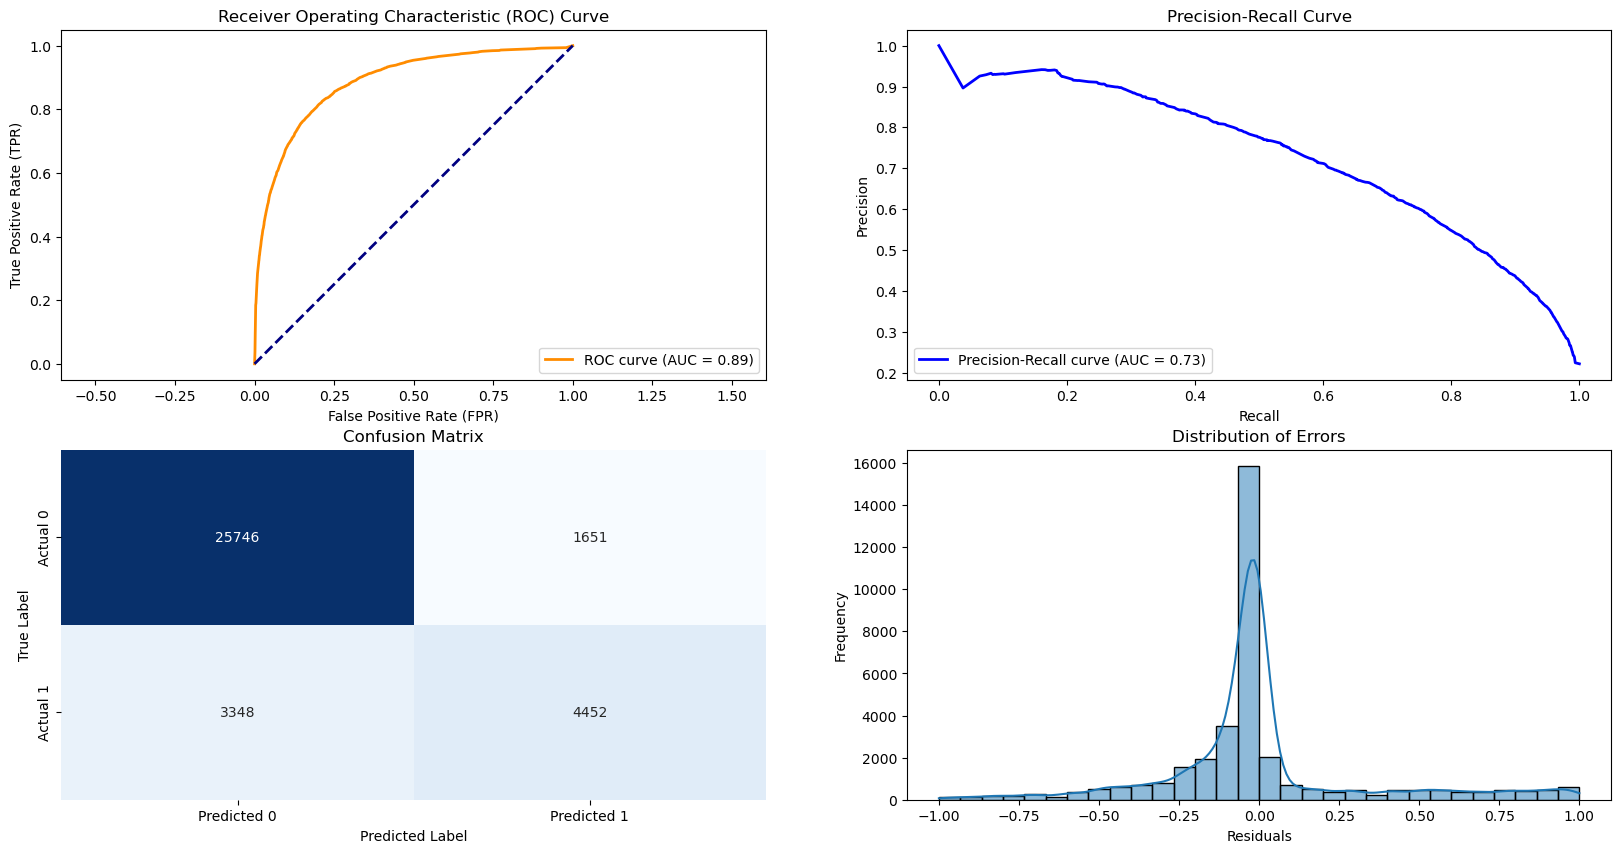

In [64]:
model = Model(best_dt_model, 
              name='DT No Resample', 
              scaled=True, resample=None)
model.fit()
model.visualize_metrics()

In [65]:
metrics_DT_no_resample = model.get_metrics()
models_df = pd.concat([models_df, metrics_DT_no_resample.to_frame().T])
print(metrics_DT_no_resample)

Accuracy                                 0.857971
Precision                                0.729477
Recall                                   0.570769
F1-Score                                 0.640437
ROC AUC                                   0.88525
Confusion Matrix    [[25746, 1651], [3348, 4452]]
PR AUC                                   0.726767
Name                               DT No Resample
dtype: object


### SMOTE

In [66]:
param_dist = {
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 40),
    'min_samples_leaf': randint(1, 20),
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None]
}

dt = DecisionTreeClassifier(random_state=42)

random_search = RandomizedSearchCV(dt, param_distributions=param_dist, 
                                   n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)


random_search.fit(X_train_smote_scaled, y_train_smote)
best_dt_model = random_search.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END criterion=entropy, max_depth=6, max_features=log2, min_samples_leaf=1, min_samples_split=13; total time=   0.4s
[CV] END criterion=entropy, max_depth=6, max_features=log2, min_samples_leaf=1, min_samples_split=13; total time=   0.4s
[CV] END criterion=entropy, max_depth=6, max_features=log2, min_samples_leaf=1, min_samples_split=13; total time=   0.4s
[CV] END criterion=entropy, max_depth=6, max_features=log2, min_samples_leaf=1, min_samples_split=13; total time=   0.4s
[CV] END criterion=entropy, max_depth=6, max_features=log2, min_samples_leaf=1, min_samples_split=13; total time=   0.5s
[CV] END criterion=entropy, max_depth=4, max_features=None, min_samples_leaf=2, min_samples_split=25; total time=   0.9s
[CV] END criterion=entropy, max_depth=4, max_features=None, min_samples_leaf=2, min_samples_split=25; total time=   0.9s
[CV] END criterion=entropy, max_depth=12, max_features=sqrt, min_samples_leaf=17, min_samp

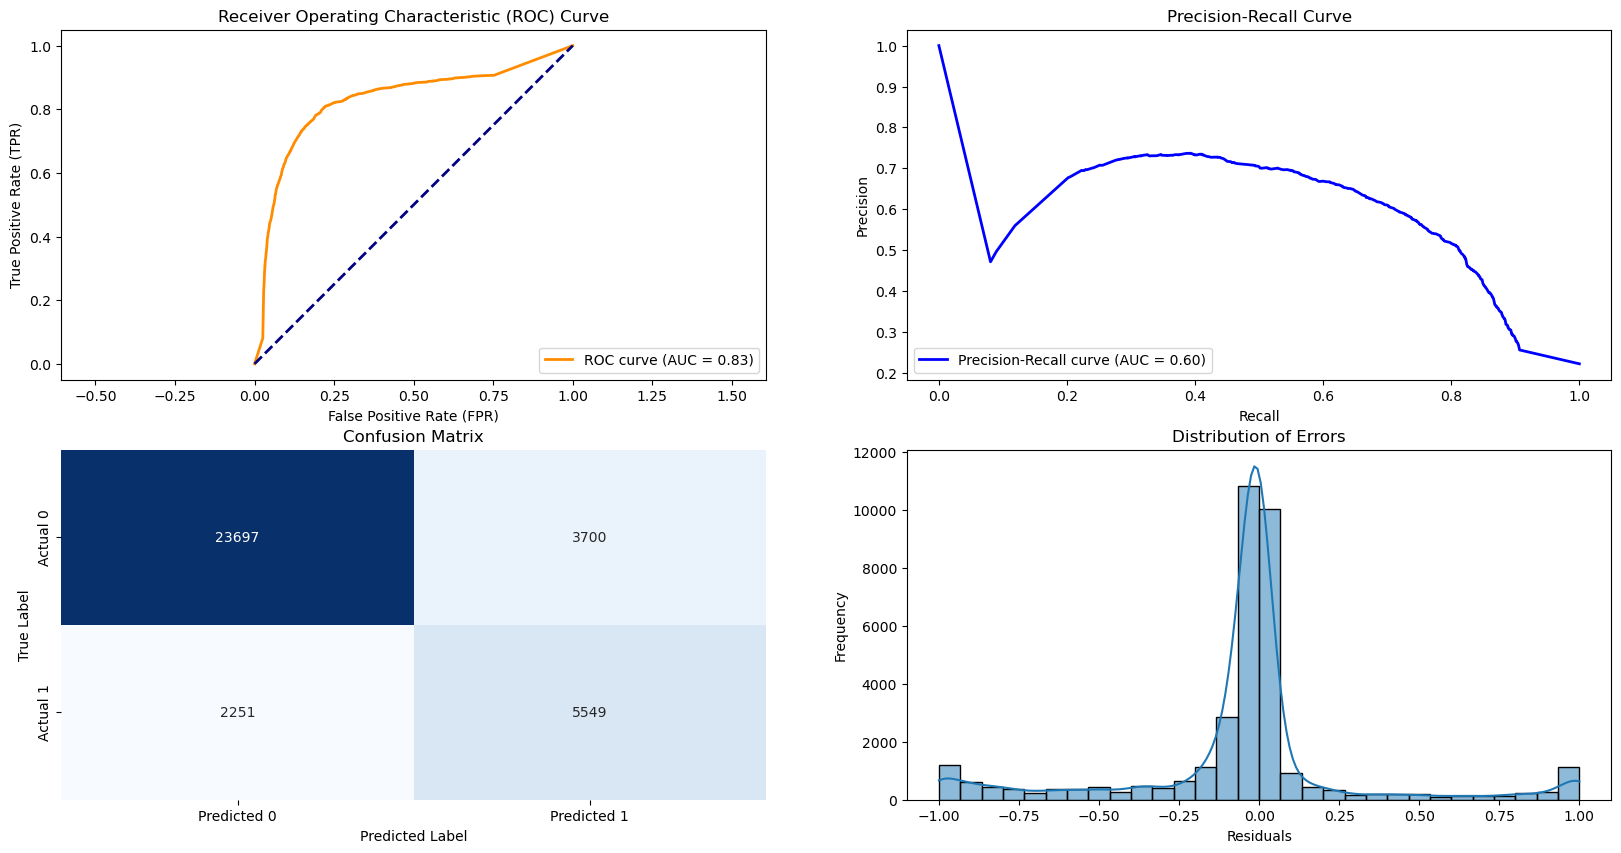

In [67]:
model = Model(best_dt_model, 'DT Smote', scaled=True, resample='smote')
model.fit()
model.visualize_metrics()

In [68]:
metrics_DT_smote = model.get_metrics()
models_df_smote = pd.concat([models_df_smote, metrics_DT_smote.to_frame().T])
print(metrics_DT_smote)

Accuracy                                 0.830923
Precision                                0.599957
Recall                                    0.71141
F1-Score                                 0.650947
ROC AUC                                  0.826767
Confusion Matrix    [[23697, 3700], [2251, 5549]]
PR AUC                                   0.582073
Name                                     DT Smote
dtype: object


### Undersample

In [69]:
param_dist = {
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 40),
    'min_samples_leaf': randint(1, 20),
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None]
}

dt = DecisionTreeClassifier(random_state=42)

random_search = RandomizedSearchCV(dt, param_distributions=param_dist, 
                                   n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)


random_search.fit(X_train_under_scaled, y_train_under)
best_dt_model = random_search.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END criterion=entropy, max_depth=6, max_features=log2, min_samples_leaf=1, min_samples_split=13; total time=   0.1s
[CV] END criterion=entropy, max_depth=6, max_features=log2, min_samples_leaf=1, min_samples_split=13; total time=   0.1s
[CV] END criterion=entropy, max_depth=6, max_features=log2, min_samples_leaf=1, min_samples_split=13; total time=   0.1s
[CV] END criterion=entropy, max_depth=6, max_features=log2, min_samples_leaf=1, min_samples_split=13; total time=   0.1s
[CV] END criterion=entropy, max_depth=6, max_features=log2, min_samples_leaf=1, min_samples_split=13; total time=   0.1s
[CV] END criterion=entropy, max_depth=4, max_features=None, min_samples_leaf=2, min_samples_split=25; total time=   0.1s
[CV] END criterion=entropy, max_depth=4, max_features=None, min_samples_leaf=2, min_samples_split=25; total time=   0.1s
[CV] END criterion=entropy, max_depth=4, max_features=None, min_samples_leaf=2, min_sample

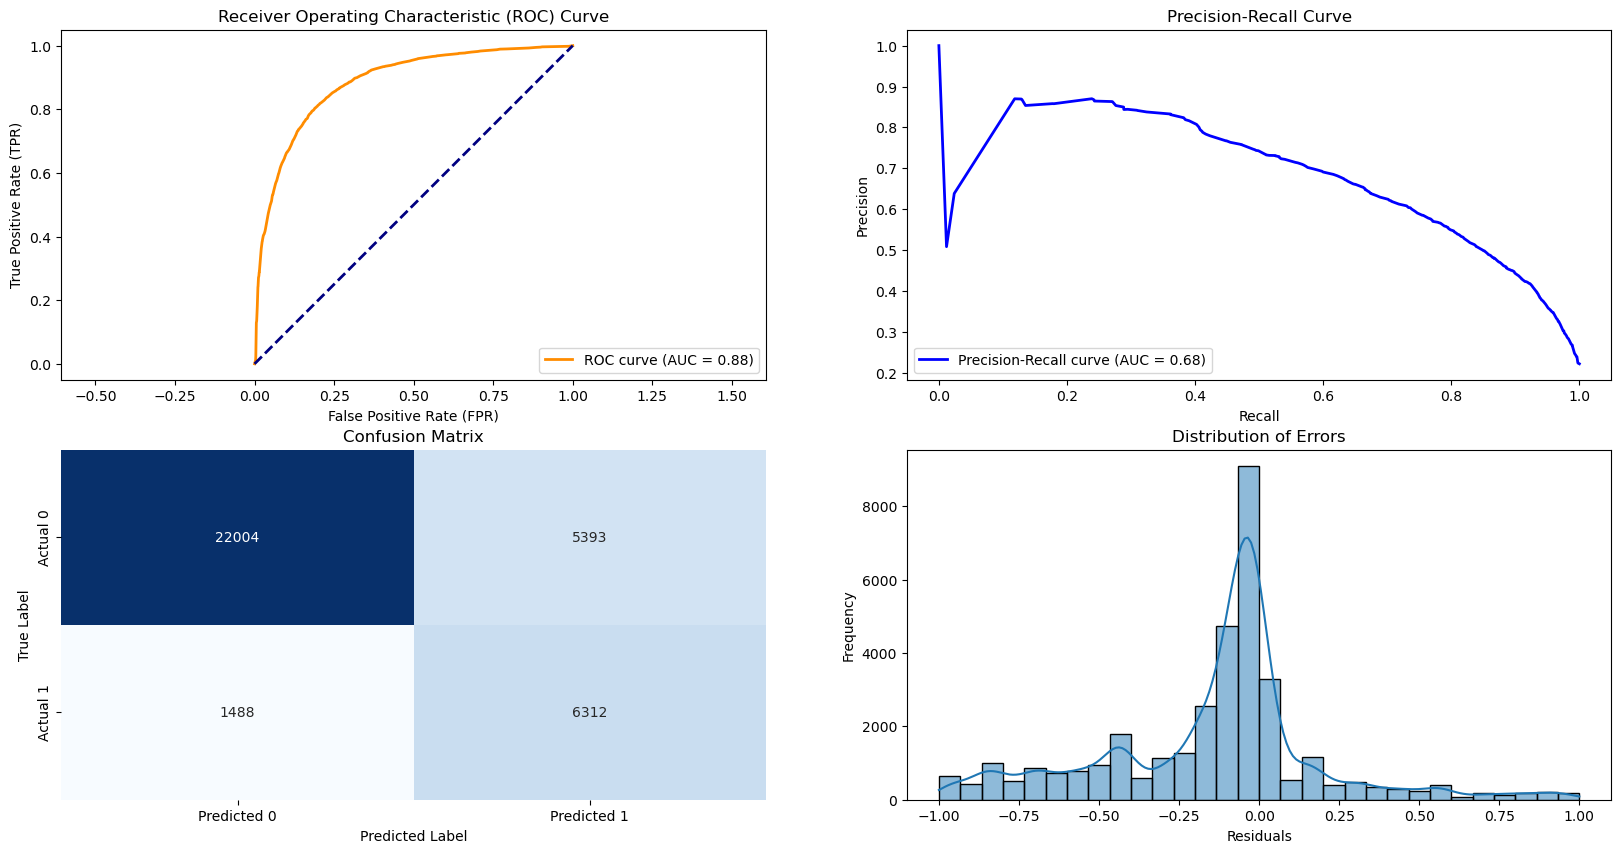

In [70]:
model = Model(best_dt_model, name='DT Undersample', scaled=False, resample='under')
model.fit()
model.visualize_metrics()

In [71]:
metrics_DT_under = model.get_metrics()
models_df_under = pd.concat([models_df_under, metrics_DT_under.to_frame().T])
print(metrics_DT_under)

Accuracy                                   0.8045
Precision                                0.539257
Recall                                   0.809231
F1-Score                                 0.647219
ROC AUC                                  0.883556
Confusion Matrix    [[22004, 5393], [1488, 6312]]
PR AUC                                   0.692408
Name                               DT Undersample
dtype: object


## Random Forest
A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. 

### No Resample

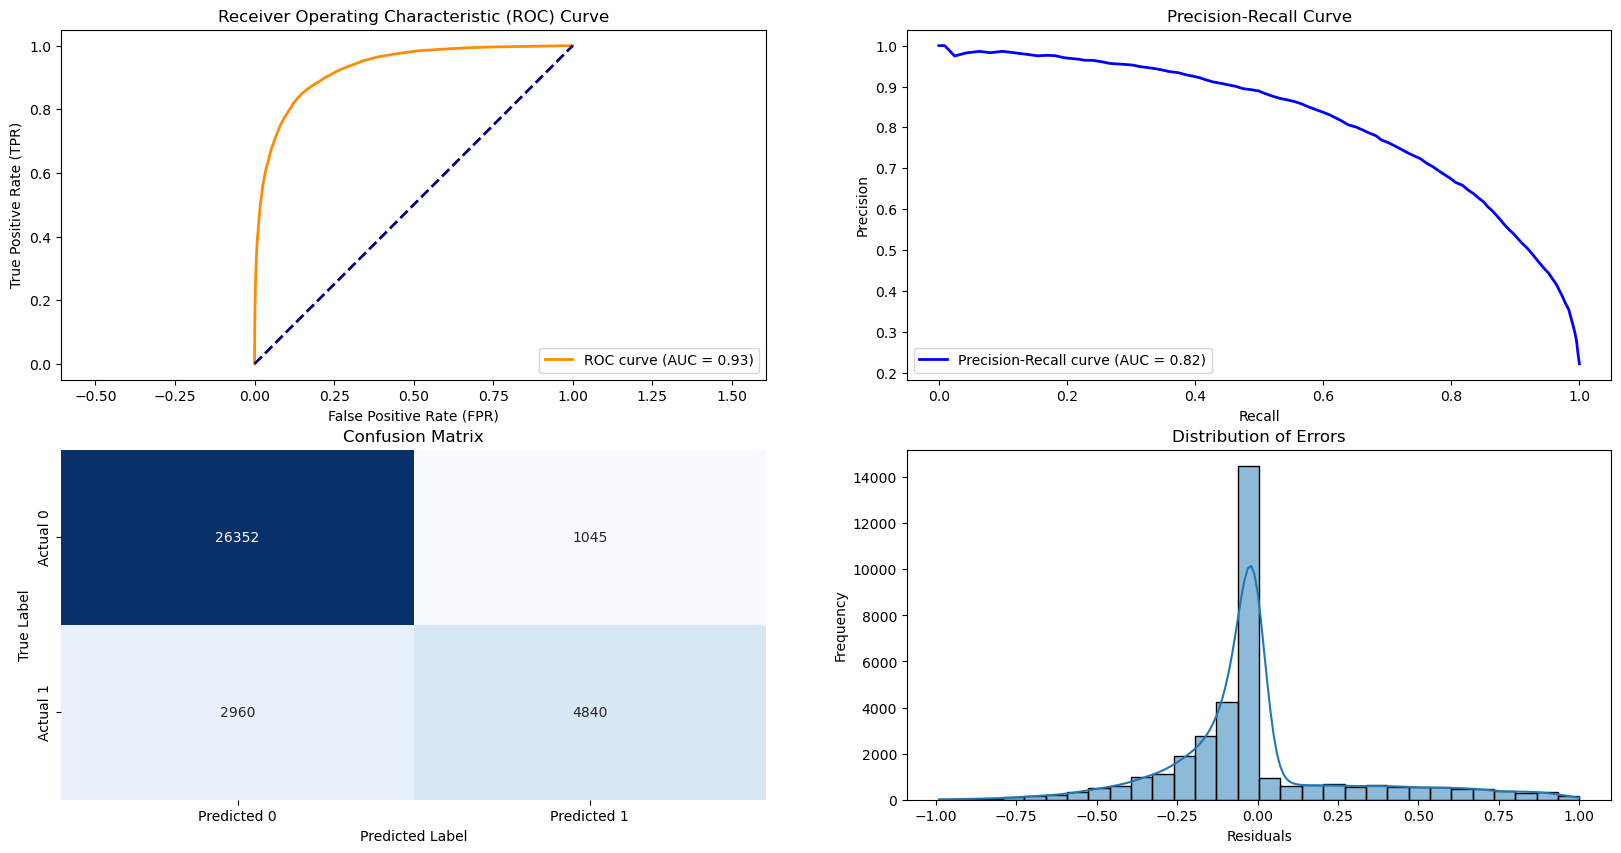

In [72]:
model = Model(RandomForestClassifier(), name='RF No Resample', scaled=True, resample=None)
model.fit()
model.visualize_metrics()

In [73]:
metrics_RF_no_resample = model.get_metrics()
models_df = pd.concat([models_df, metrics_RF_no_resample.to_frame().T])
print(metrics_RF_no_resample)

Accuracy                                 0.886212
Precision                                 0.82243
Recall                                   0.620513
F1-Score                                 0.707344
ROC AUC                                  0.927877
Confusion Matrix    [[26352, 1045], [2960, 4840]]
PR AUC                                   0.816664
Name                               RF No Resample
dtype: object


### SMOTE

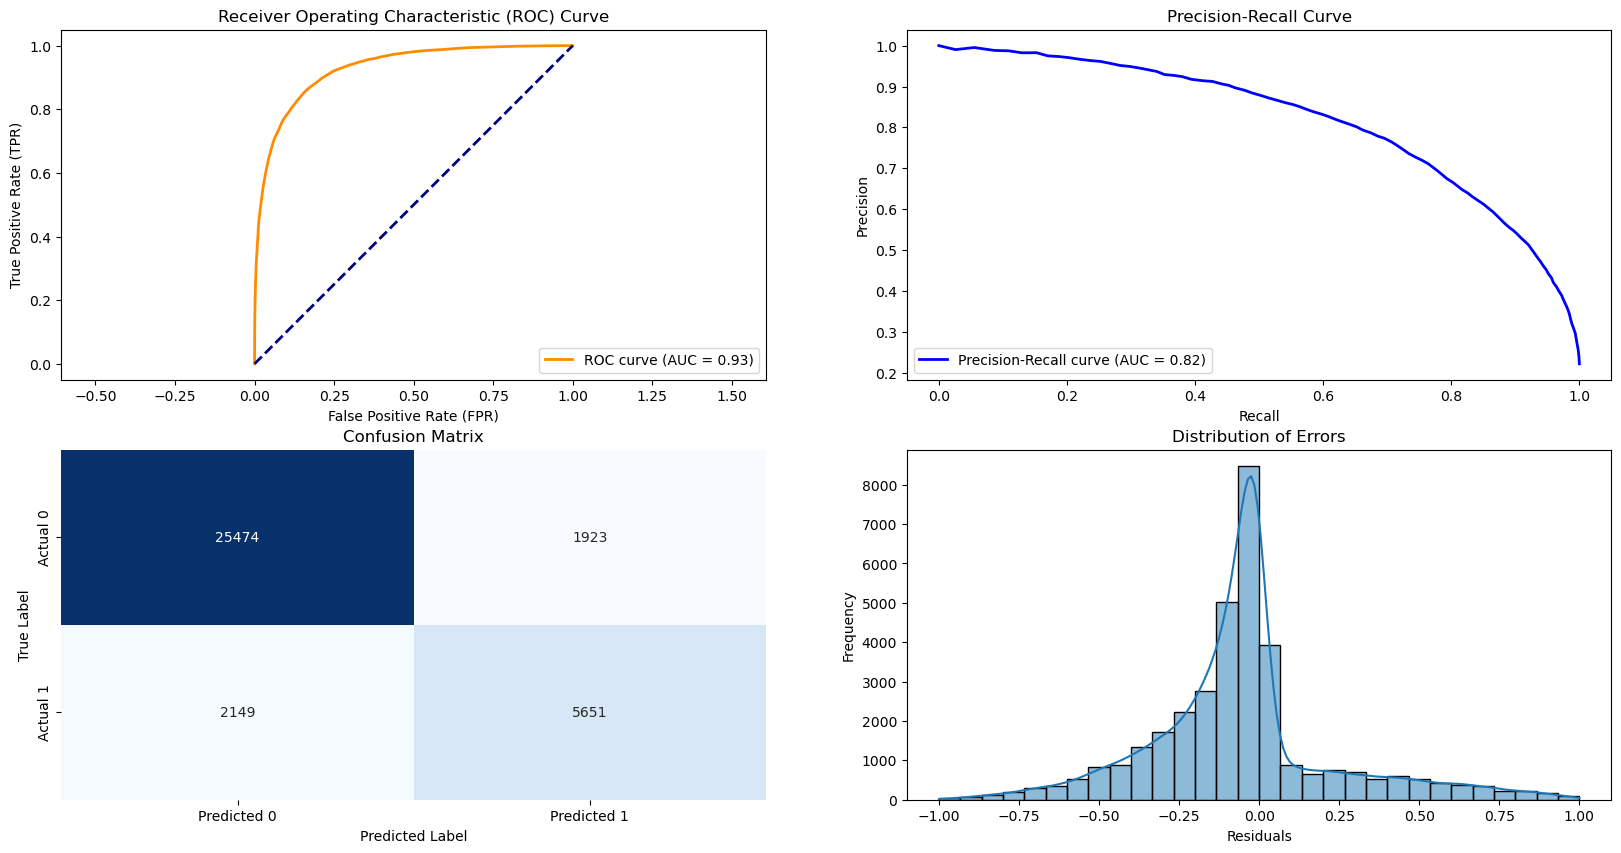

In [74]:
model = Model(RandomForestClassifier(), name='RF SMOTE', scaled=True, resample='smote')
model.fit()
model.visualize_metrics()

In [75]:
metrics_RF_smote = model.get_metrics()
models_df_smote = pd.concat([models_df_smote, metrics_RF_smote.to_frame().T])
print(metrics_RF_smote)

Accuracy                                 0.884308
Precision                                0.746105
Recall                                   0.724487
F1-Score                                 0.735137
ROC AUC                                  0.927766
Confusion Matrix    [[25474, 1923], [2149, 5651]]
PR AUC                                   0.815773
Name                                     RF SMOTE
dtype: object


### Undersample

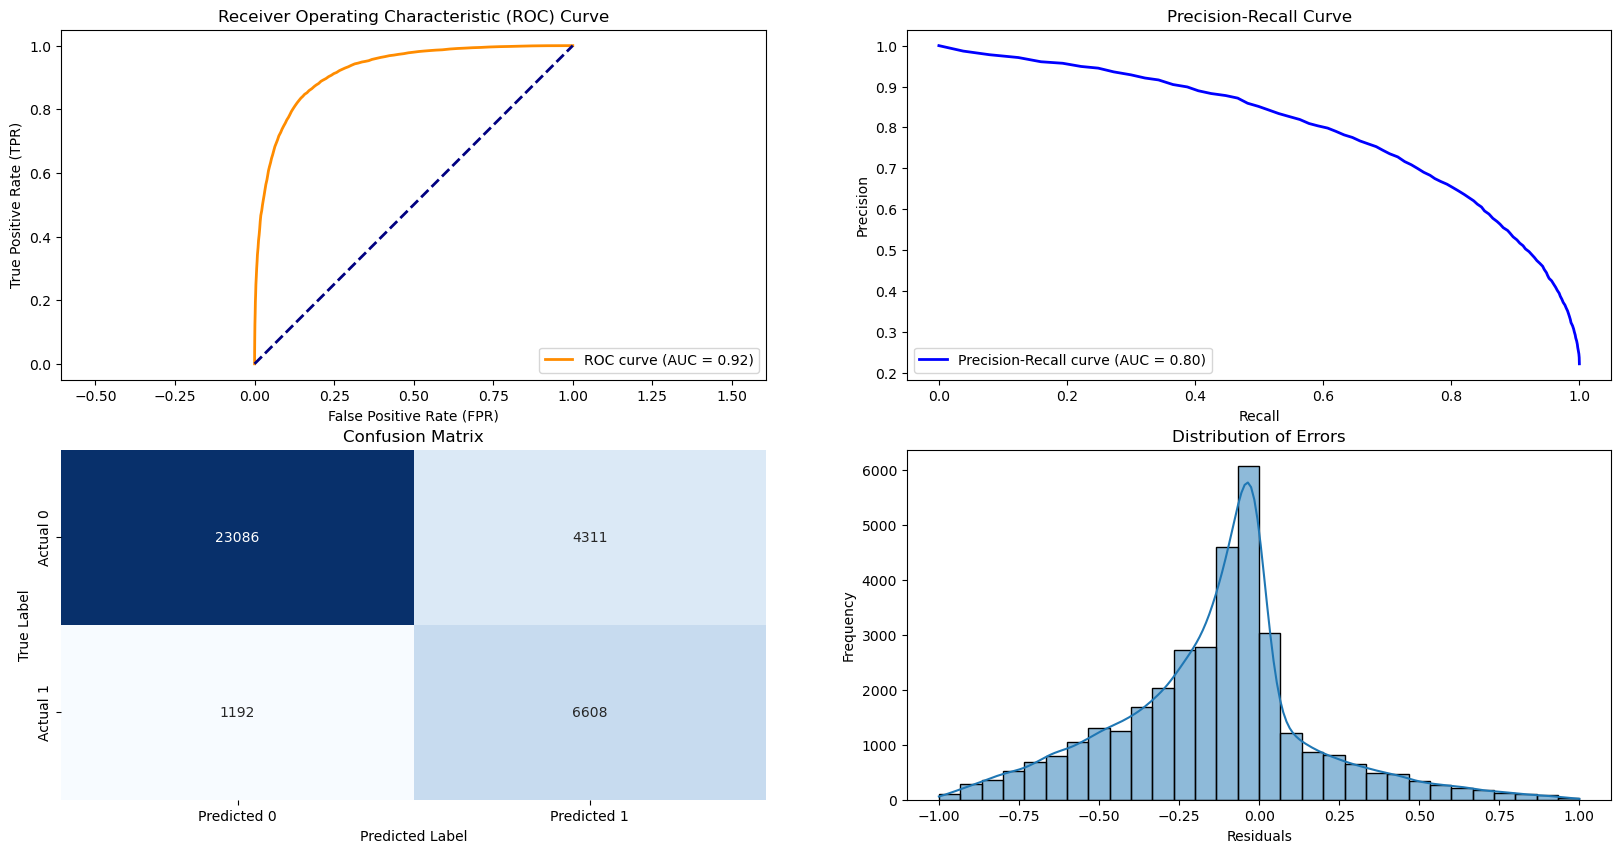

In [76]:
model = Model(RandomForestClassifier(), name='RF Undersample', scaled=True, resample='under')
model.fit()
model.visualize_metrics()

In [77]:
metrics_RF_under = model.get_metrics()
models_df_under = pd.concat([models_df_under, metrics_RF_under.to_frame().T])
print(metrics_RF_under)

Accuracy                                 0.843651
Precision                                0.605184
Recall                                   0.847179
F1-Score                                 0.706021
ROC AUC                                   0.92241
Confusion Matrix    [[23086, 4311], [1192, 6608]]
PR AUC                                   0.795481
Name                               RF Undersample
dtype: object


## KNN
The K-Nearest Neighbors (K-NN) algorithm is a simple and intuitive supervised machine learning method used for both classification and regression tasks. It operates based on the principle that similar data points tend to share common characteristics and are often found close to each other in the feature space.

### No Resample

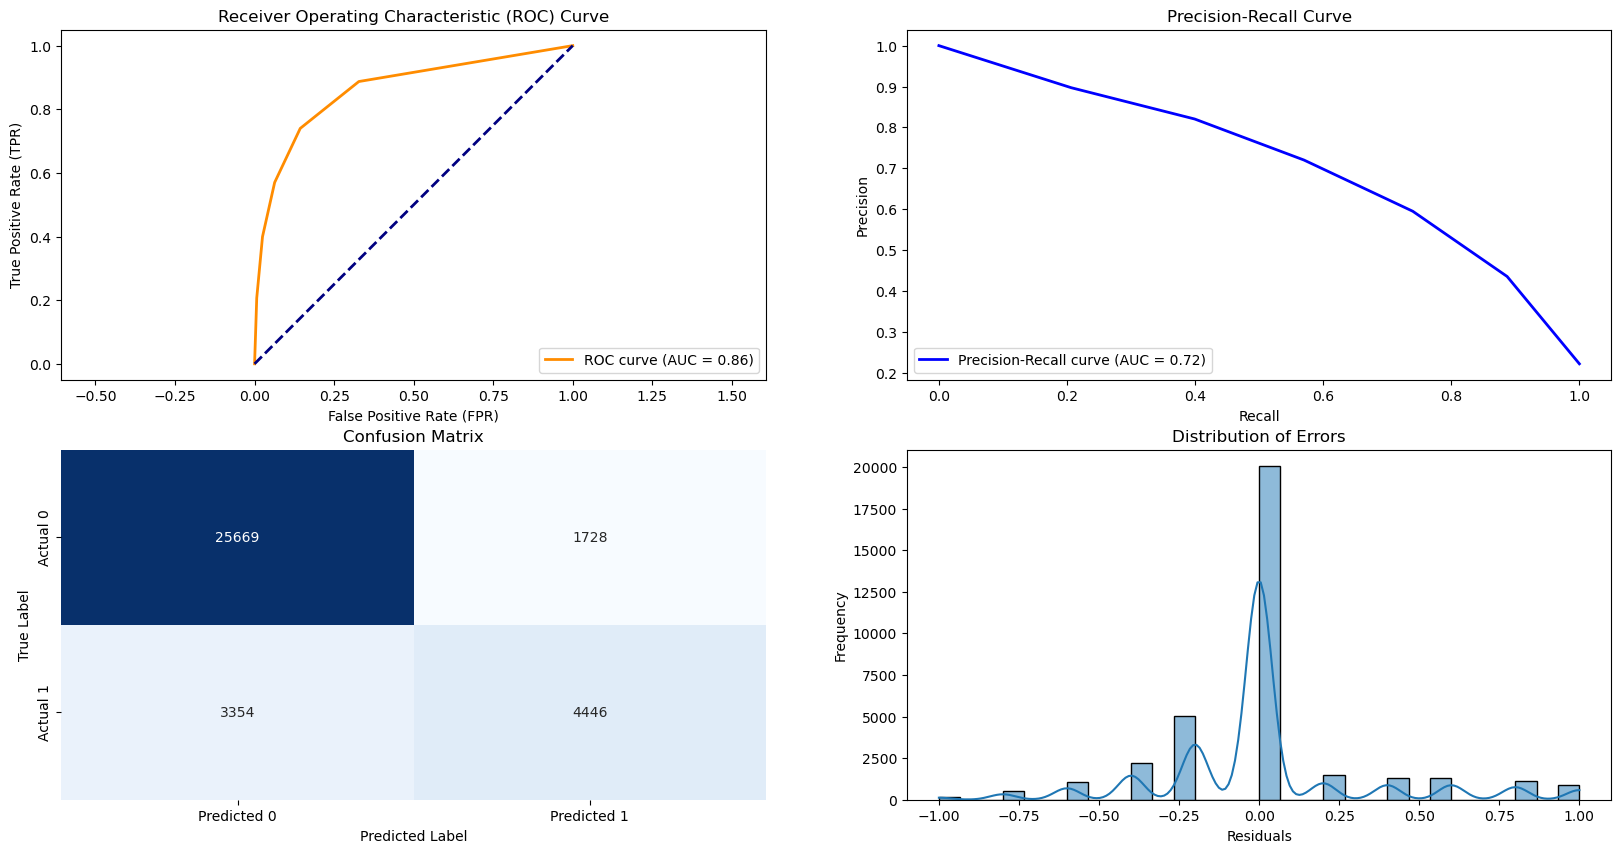

In [78]:
model = Model(KNeighborsClassifier(),'KNN No Resample', scaled=True, resample = None)
model.fit()
model.visualize_metrics()

In [79]:
metrics_KNN_no_resample = model.get_metrics()
models_df = pd.concat([models_df, metrics_KNN_no_resample.to_frame().T])
print(metrics_KNN_no_resample)

Accuracy                                 0.855613
Precision                                0.720117
Recall                                       0.57
F1-Score                                 0.636325
ROC AUC                                  0.861607
Confusion Matrix    [[25669, 1728], [3354, 4446]]
PR AUC                                   0.656541
Name                              KNN No Resample
dtype: object


### SMOTE

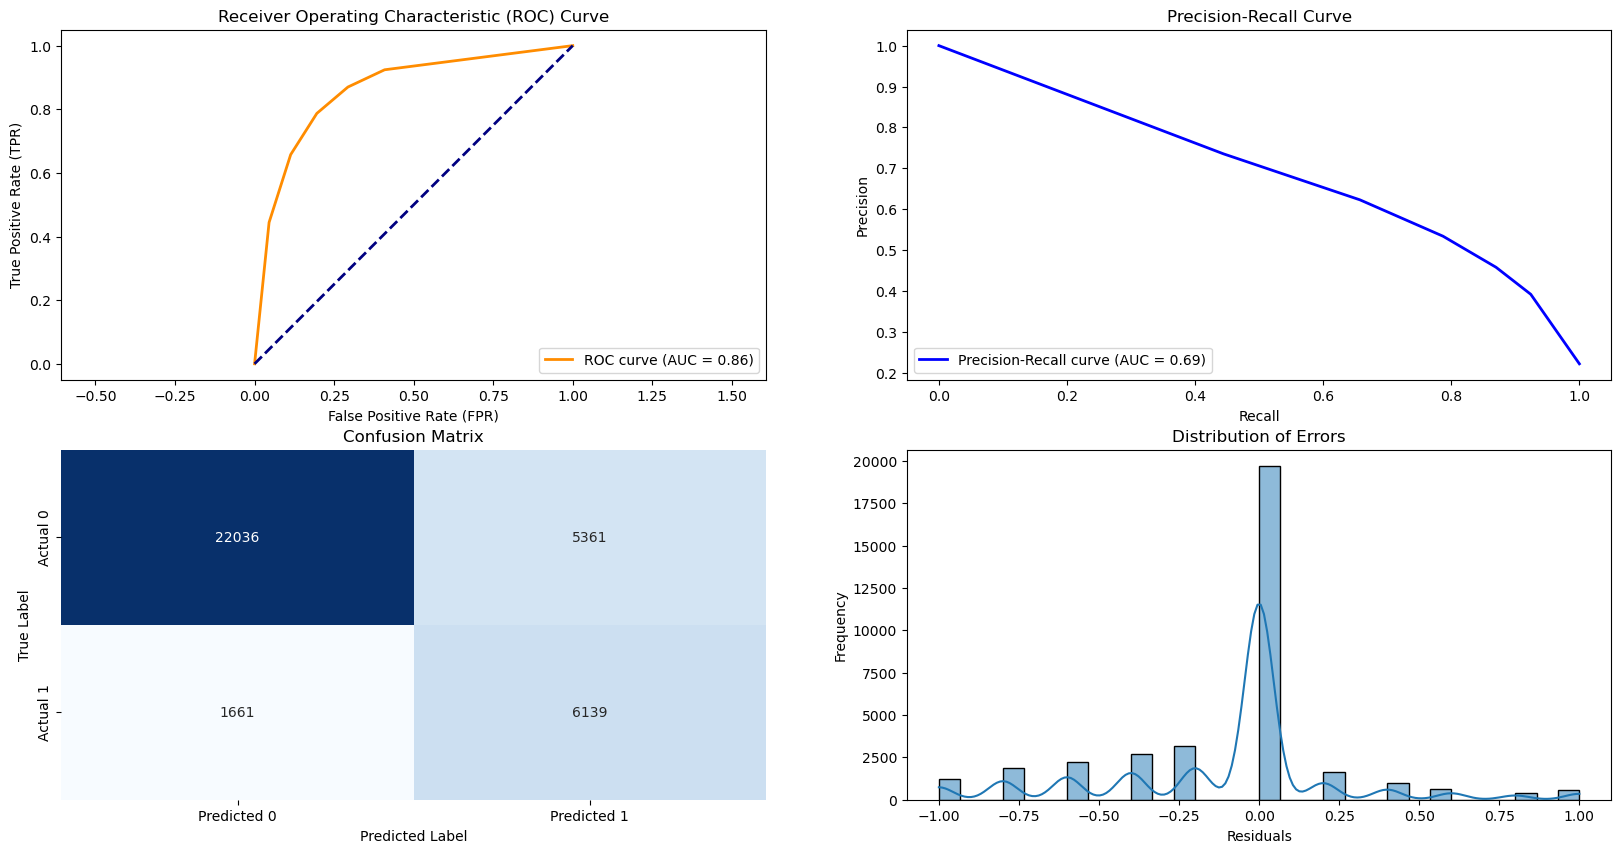

In [80]:
model = Model(KNeighborsClassifier(),'KNN SMOTE', scaled=True, resample = 'smote')
model.fit()
model.visualize_metrics()

In [81]:
metrics_KNN_smote = model.get_metrics()
models_df_smote = pd.concat([models_df_smote, metrics_KNN_smote.to_frame().T])
print(metrics_KNN_smote)

Accuracy                                 0.800494
Precision                                0.533826
Recall                                   0.787051
F1-Score                                 0.636166
ROC AUC                                  0.860175
Confusion Matrix    [[22036, 5361], [1661, 6139]]
PR AUC                                    0.60457
Name                                    KNN SMOTE
dtype: object


### Undersample

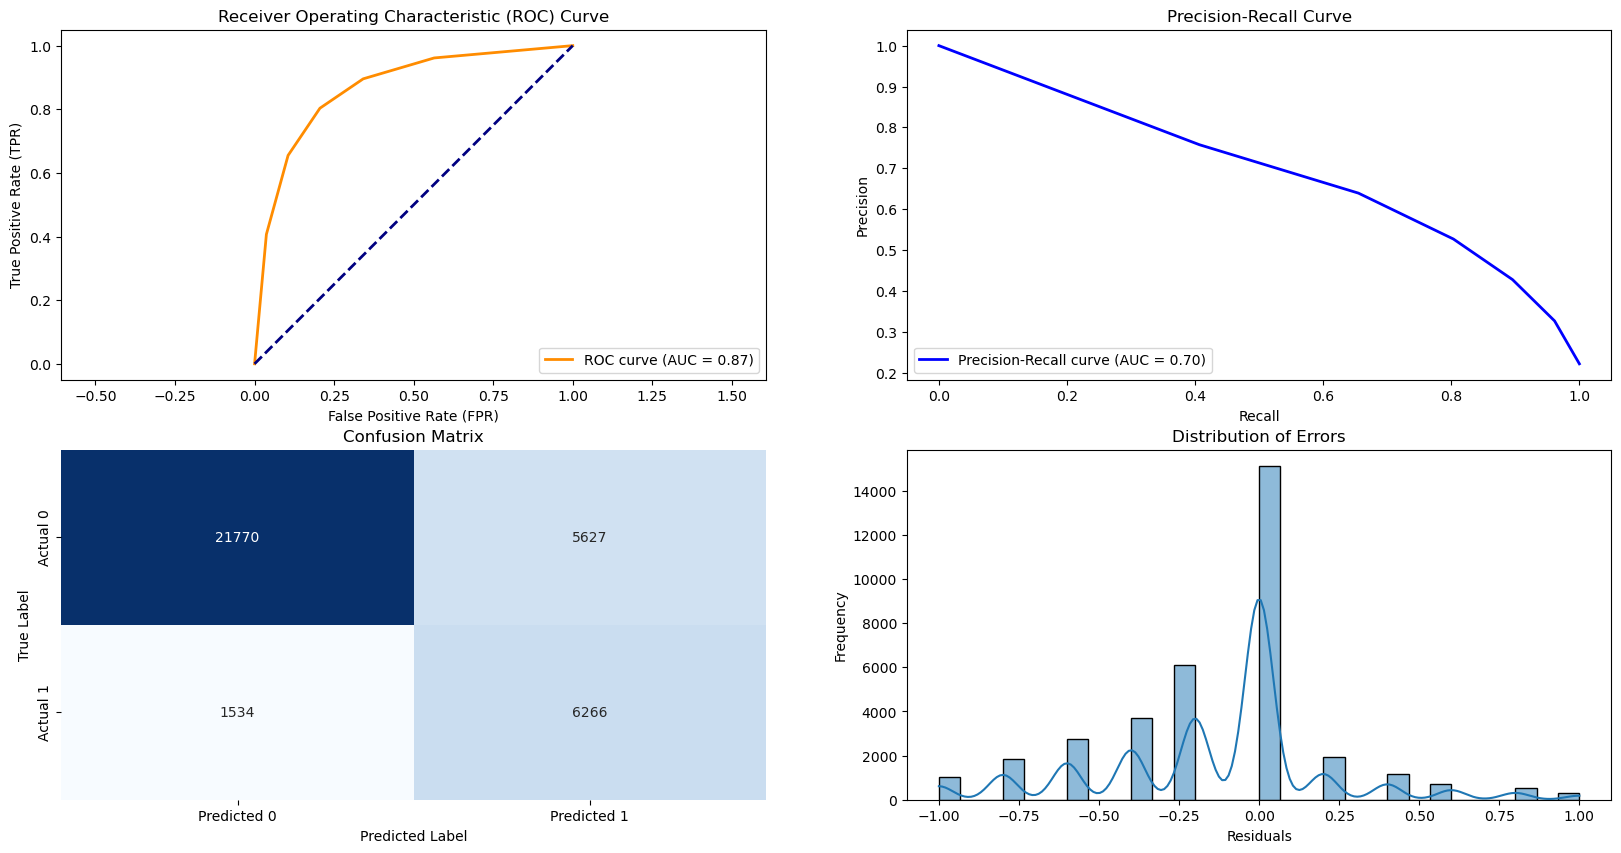

In [82]:
model = Model(KNeighborsClassifier(),'KNN Undersample', scaled=True, resample = 'under')
model.fit()
model.visualize_metrics()

In [83]:
metrics_KNN_under = model.get_metrics()
models_df_under = pd.concat([models_df_under, metrics_KNN_under.to_frame().T])
print(metrics_KNN_under)

Accuracy                                 0.796545
Precision                                0.526865
Recall                                   0.803333
F1-Score                                 0.636368
ROC AUC                                  0.866511
Confusion Matrix    [[21770, 5627], [1534, 6266]]
PR AUC                                   0.614456
Name                              KNN Undersample
dtype: object


## Gradient Boosting Classifier
Gradient Boosting is an ensemble learning technique that combines the predictions of multiple weak learners (typically decision trees) to create a strong predictive model. The Gradient Boosting Classifier, specifically, is used for classification tasks.

Here's a brief description of the Gradient Boosting Classifier:
- **Base Learners (Weak Models)**: The algorithm starts with an initial weak learner, often a shallow decision tree. The model initially makes predictions, and the errors or residuals (the differences between predicted and actual values) are identified.

- **Gradient Descent Optimization**: In subsequent iterations, new weak learners are added to the ensemble, and they focus on correcting the errors made by the existing ensemble. The optimization process is akin to descending a gradient in the error space, hence the name "gradient boosting."

- **Weighted Contributions**: Each weak learner contributes to the final prediction with a certain weight. The weights are determined during the training process, and they depend on the contribution of each learner in minimizing the overall prediction error.

- **Shrinkage (Learning Rate)**: A hyperparameter called the learning rate controls the contribution of each weak learner. A smaller learning rate requires more weak learners but often leads to better generalization.

- **Regularization**: Gradient Boosting includes regularization techniques to prevent overfitting. This may involve constraining the complexity of the individual weak learners or introducing penalties for large weights.

- **Prediction**: The final prediction is made by aggregating the predictions of all weak learners, and the class with the majority of votes is selected as the predicted class for classification tasks.

### No Resample

In [84]:
from scipy.stats import uniform

param_dist = {
    'n_estimators': [500, 800, 1000],
    'learning_rate': uniform(0.01, 0.3),  
    'max_depth': [3, 5, 7],
    'min_samples_split': [10, 20, 40],
    'min_samples_leaf': [20, 50, 70],
    'max_features': ['sqrt', 'log2']
}

gb = GradientBoostingClassifier(random_state=42)

random_search = RandomizedSearchCV(gb, param_distributions=param_dist, 
                                   n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)

random_search.fit(X_train_scaled, y_train)
best_gb_model = random_search.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END learning_rate=0.12236203565420874, max_depth=3, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=500; total time=  39.5s
[CV] END learning_rate=0.12236203565420874, max_depth=3, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=500; total time=  39.9s
[CV] END learning_rate=0.07370173320348283, max_depth=3, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500; total time=  40.6s
[CV] END learning_rate=0.12236203565420874, max_depth=3, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=500; total time=  41.3s
[CV] END learning_rate=0.07370173320348283, max_depth=3, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500; total time=  41.7s
[CV] END learning_rate=0.07370173320348283, max_depth=3, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500; total time=  42.3s
[CV

KeyboardInterrupt: 

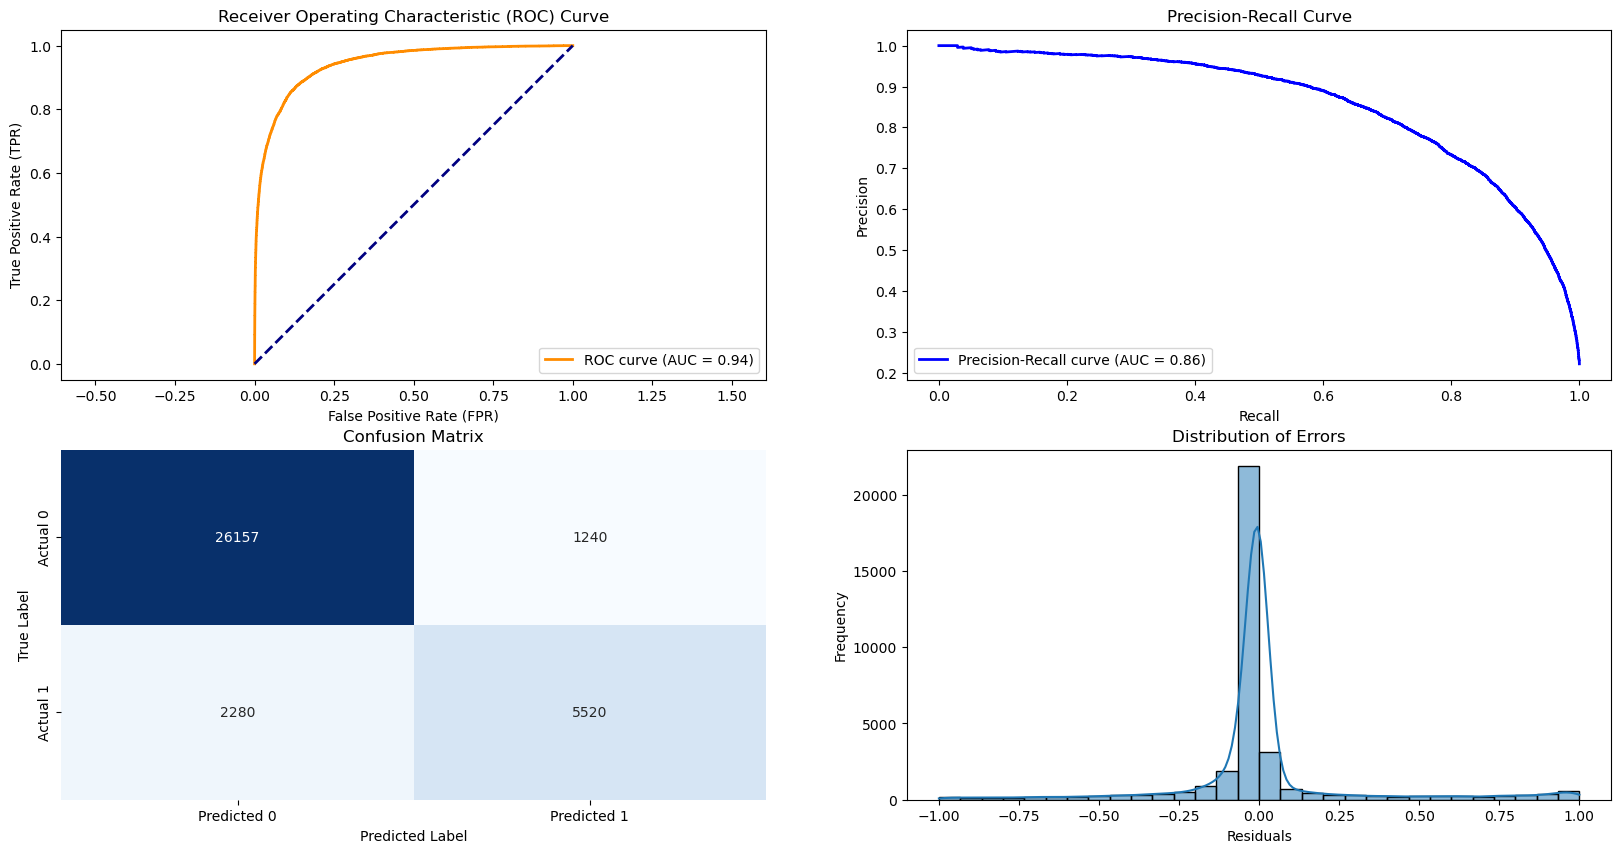

In [ ]:
model = Model(best_gb_model, name='Gradient Boosting No Resample', scaled=True, resample=None)
model.fit()
model.visualize_metrics()

In [ ]:
metrics_GBC_no_resample = model.get_metrics()
models_df = pd.concat([models_df, metrics_GBC_no_resample.to_frame().T])
print(metrics_GBC_no_resample)

Accuracy                                 0.899991
Precision                                0.816568
Recall                                   0.707692
F1-Score                                 0.758242
ROC AUC                                   0.94288
Confusion Matrix    [[26157, 1240], [2280, 5520]]
PR AUC                                   0.856161
Name                Gradient Boosting No Resample
dtype: object


### SMOTE

In [ ]:

param_dist = {
    'n_estimators': [500, 800, 1000],
    'learning_rate': uniform(0.01, 0.3),  
    'max_depth': [3, 5, 7],
    'min_samples_split': [10, 20, 40],
    'min_samples_leaf': [20, 50, 70],
    'max_features': ['sqrt', 'log2']
}

gb = GradientBoostingClassifier(random_state=42)

random_search = RandomizedSearchCV(gb, param_distributions=param_dist, 
                                   n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)

random_search.fit(X_train_smote_scaled, y_train_smote)
best_gb_model = random_search.best_estimator_

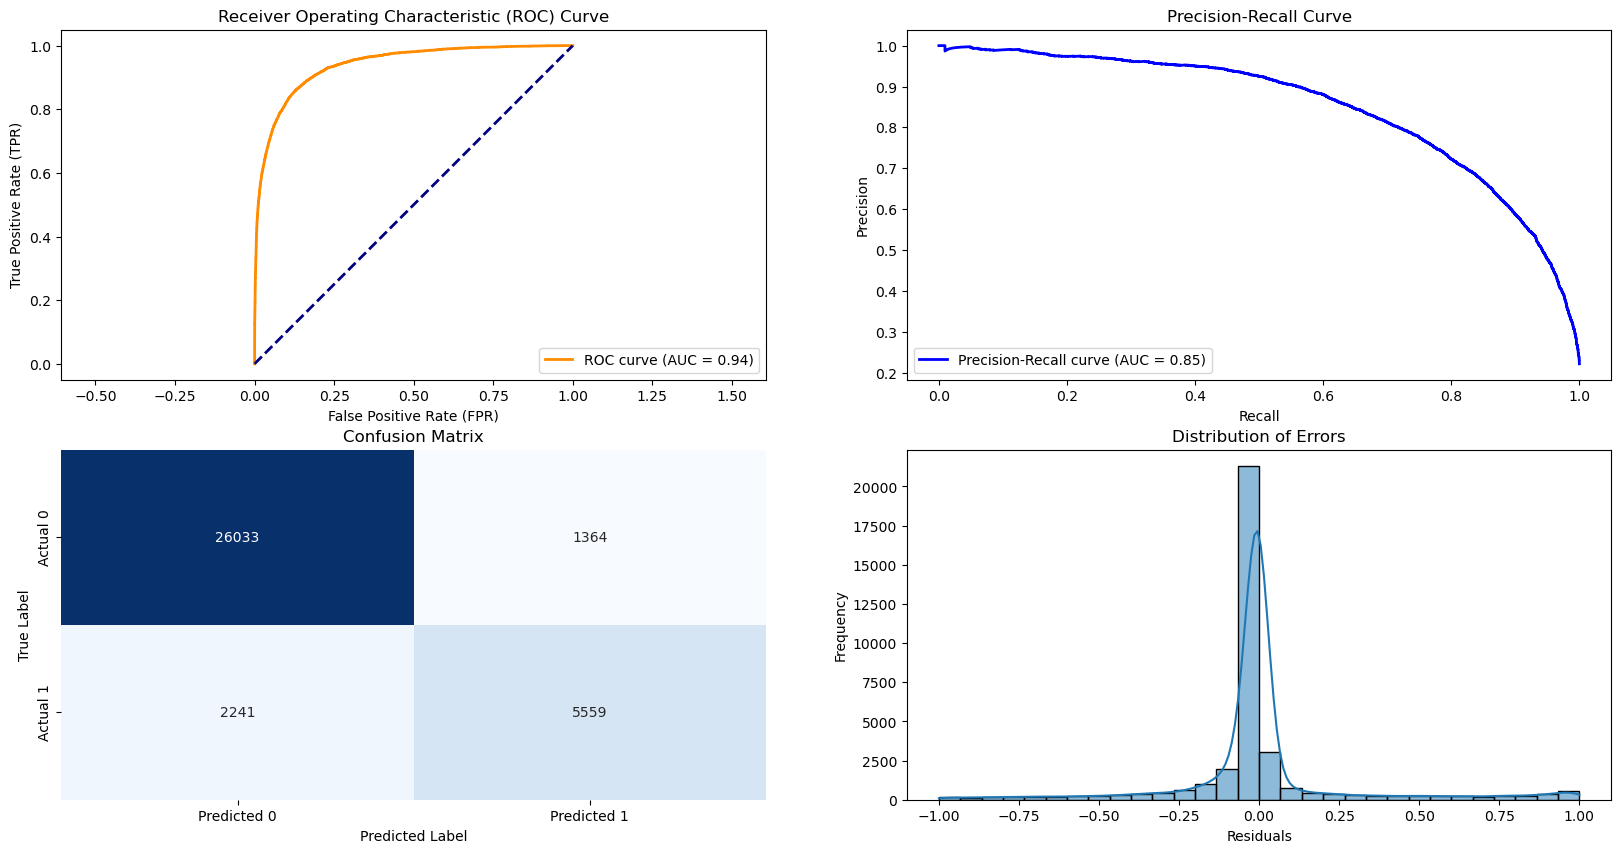

In [ ]:
model = Model(best_gb_model, name='Gradient Boosting SMOTE', scaled=True, resample='smote')
model.fit()
model.visualize_metrics()

In [ ]:
metrics_GBC_smote = model.get_metrics()
models_df_smote = pd.concat([models_df_smote, metrics_GBC_smote.to_frame().T])
print(metrics_GBC_smote)

Accuracy                                 0.897576
Precision                                0.802976
Recall                                   0.712692
F1-Score                                 0.755145
ROC AUC                                  0.938996
Confusion Matrix    [[26033, 1364], [2241, 5559]]
PR AUC                                   0.848645
Name                      Gradient Boosting SMOTE
dtype: object


### Undersample

In [ ]:

param_dist = {
    'n_estimators': [500, 800, 1000],
    'learning_rate': uniform(0.01, 0.3),  
    'max_depth': [3, 5, 7],
    'min_samples_split': [10, 20, 40],
    'min_samples_leaf': [20, 50, 70],
    'max_features': ['sqrt', 'log2']
}

gb = GradientBoostingClassifier(random_state=42)

random_search = RandomizedSearchCV(gb, param_distributions=param_dist, 
                                   n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)

random_search.fit(X_train_under_scaled, y_train_under)
best_gb_model = random_search.best_estimator_

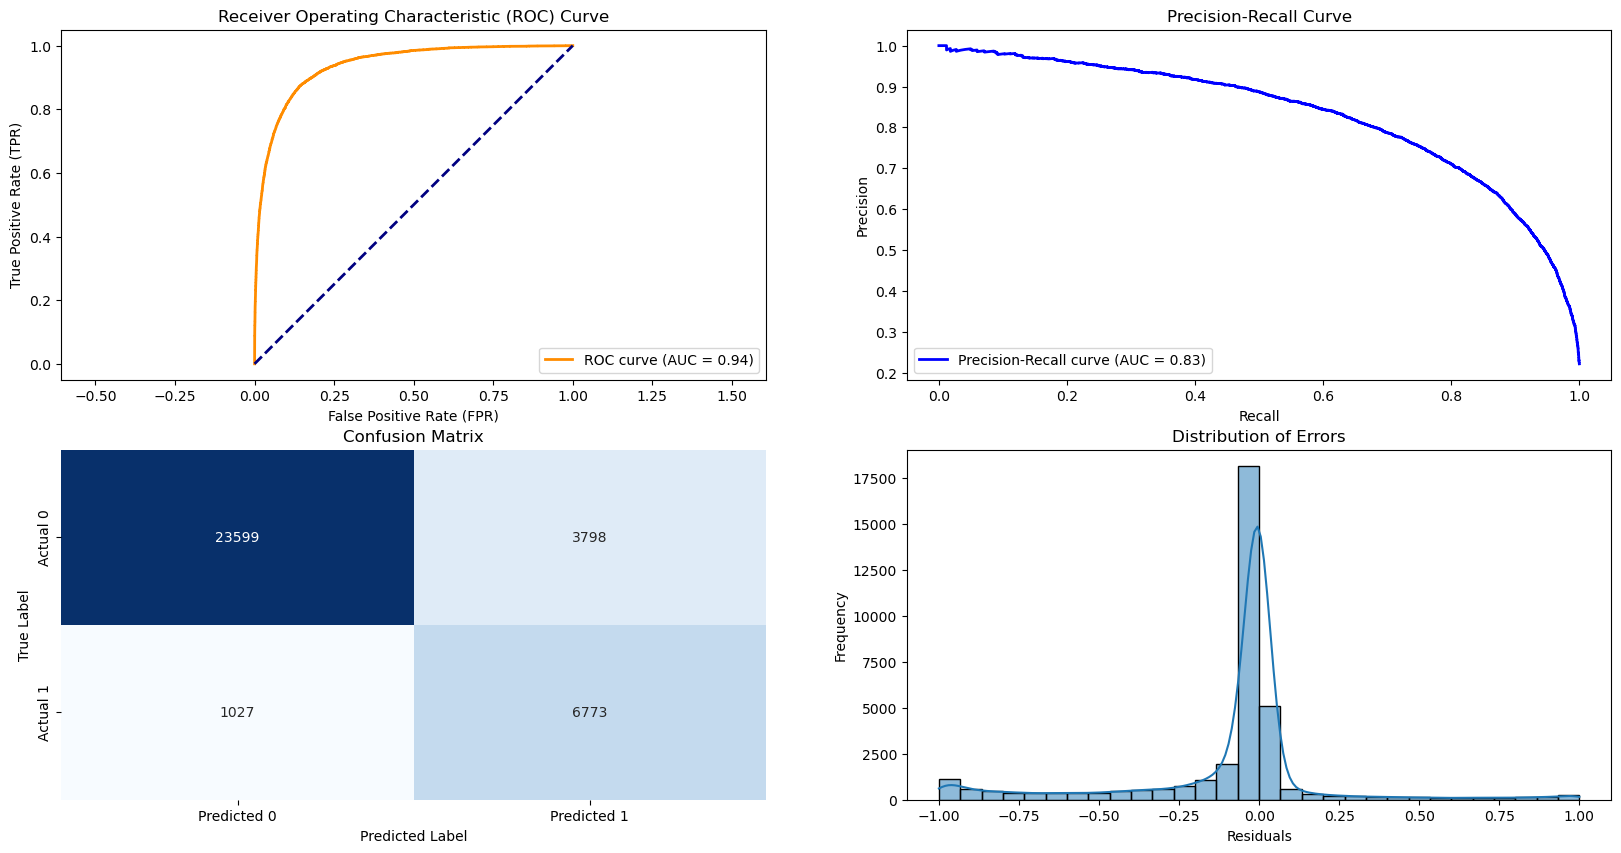

In [ ]:
model = Model(best_gb_model, name='Gradient Boosting Undersample', scaled=True, resample='under')
model.fit()
model.visualize_metrics()

In [ ]:
metrics_GBC_under = model.get_metrics()
models_df_under = pd.concat([models_df_under, metrics_GBC_under.to_frame().T])
print(metrics_GBC_under)

Accuracy                                 0.862914
Precision                                0.640715
Recall                                   0.868333
F1-Score                                 0.737358
ROC AUC                                  0.936746
Confusion Matrix    [[23599, 3798], [1027, 6773]]
PR AUC                                   0.830312
Name                Gradient Boosting Undersample
dtype: object


## XGBoost
XGBoost builds upon the principles of traditional gradient boosting while introducing several enhancements and optimizations that make it a go-to choice for predictive modeling tasks.
It is characterised by improvements over GBM:
- XGBoost is known for its efficiency in optimizing against the loss function by utilizing the Hessian information, making it more efficient in training compared to GBM.

- It leverages parallel processing techniques and optimized algorithms to achieve faster training times and lower memory usage, making it ideal for large-scale datasets.

- XGBoost provides robust regularization capabilities, including L1 regularization (Lasso) and L2 regularization (Ridge), which help prevent overfitting and improve model generalization. L1 Regularization tries to minimize the feature weights or coefficients to zero (effectively becoming a feature selection), while L2 Regularization tries to shrink the coefficient evenly (help to deal with multicollinearity).  By implementing both regularizations, XGBoost could avoid overfitting better than the GBM.

- XGBoost offers built-in support for handling missing values during training and prediction, simplifying the preprocessing pipeline and reducing the need for manual imputation techniques.

### No Resample

In [ ]:
param_dist = {
    'n_estimators': [500, 800, 1000],  
    'learning_rate': [0.01, 0.05, 0.1],  
    'max_depth': [5, 7, 9],  
    'subsample': [0.6, 0.8, 1.0],  
    'colsample_bytree': [0.6, 0.8, 1.0],  
    'gamma': [0, 0.1, 0.2, 0.3],  
    'reg_alpha': [0, 0.01, 0.1, 1],  
    'reg_lambda': [0, 0.01, 0.1, 1] 
}

xgb_model = XGBClassifier(objective='binary:logistic', use_label_encoder=False)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,  
    scoring='roc_auc',  
    cv=4,  
    verbose=1,
    random_state=42,
    n_jobs=-1  
)
random_search.fit(X_train_scaled, y_train)
best_xgb_model = random_search.best_estimator_

Fitting 4 folds for each of 50 candidates, totalling 200 fits


/home/tony/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:27:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/tony/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:27:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/tony/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:27:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/tony/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:27:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/tony/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:27:04] WARNING: /workspa

/home/tony/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


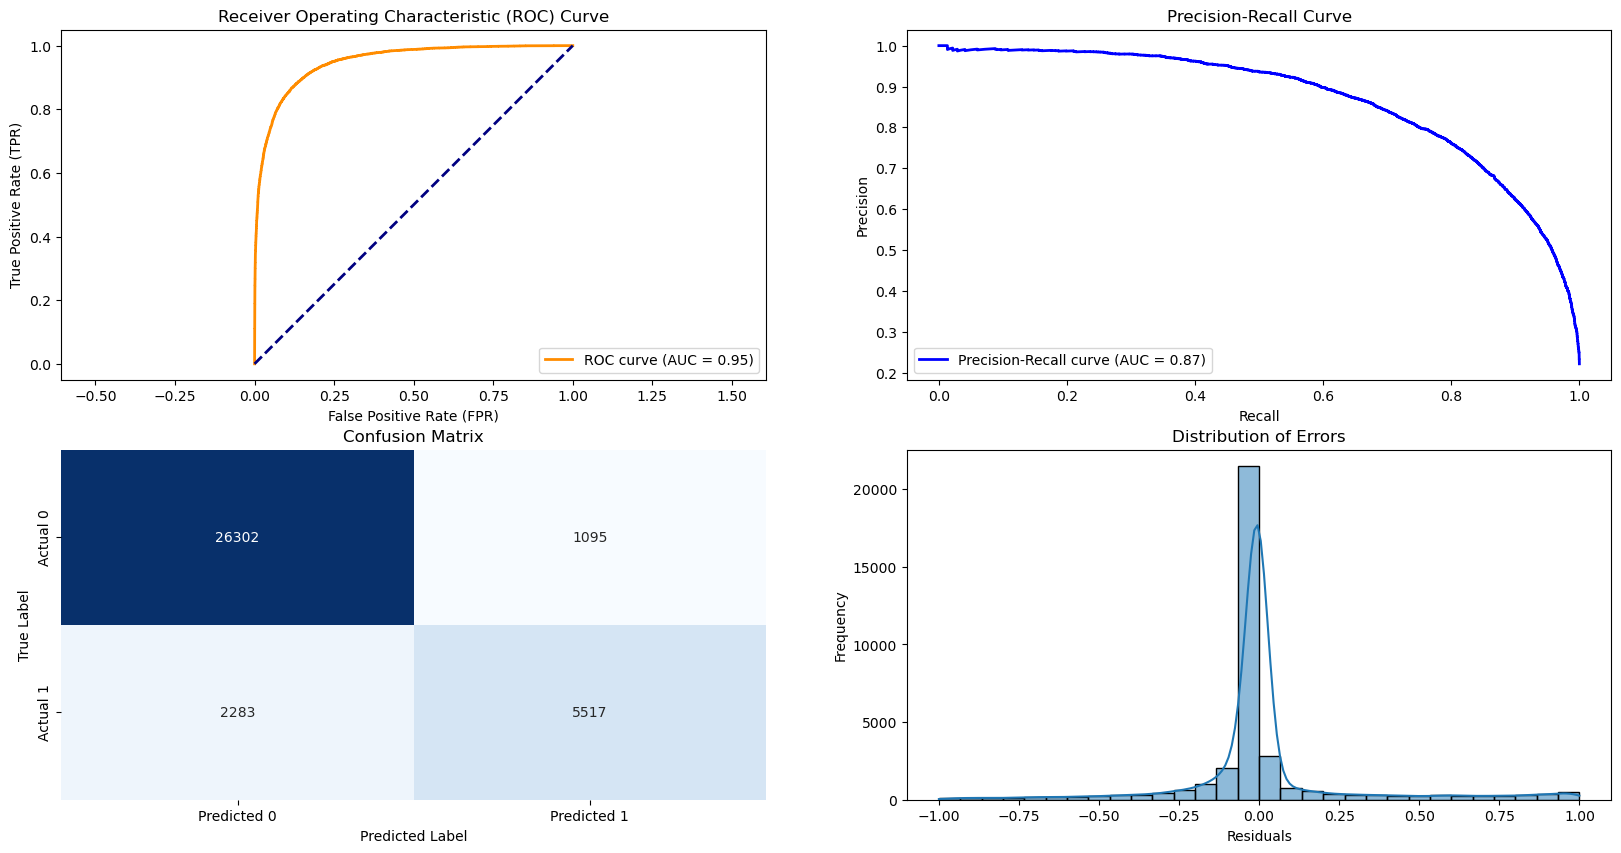

In [ ]:
model = Model(best_xgb_model, name='XGB No Resample',
               scaled=True, resample=None)
model.fit()
model.visualize_metrics()

In [ ]:
metrics_XG_no_resample = model.get_metrics()
models_df = pd.concat([models_df, metrics_XG_no_resample.to_frame().T])
print(metrics_XG_no_resample)

Accuracy                                 0.904026
Precision                                0.834392
Recall                                   0.707308
F1-Score                                 0.765612
ROC AUC                                  0.948367
Confusion Matrix    [[26302, 1095], [2283, 5517]]
PR AUC                                   0.867472
Name                              XGB No Resample
dtype: object


### SMOTE

In [ ]:
param_dist = {
    'n_estimators': [500, 800, 1000],  
    'learning_rate': [0.01, 0.05, 0.1],  
    'max_depth': [5, 7, 9],  
    'subsample': [0.6, 0.8, 1.0],  
    'colsample_bytree': [0.6, 0.8, 1.0],  
    'gamma': [0, 0.1, 0.2, 0.3],  
    'reg_alpha': [0, 0.01, 0.1, 1],  
    'reg_lambda': [0, 0.01, 0.1, 1]  
}

xgb_model = XGBClassifier(objective='binary:logistic', use_label_encoder=False)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,  
    scoring='roc_auc',  
    cv=4,  
    verbose=1,
    random_state=42,
    n_jobs=-1 
)

random_search.fit(X_train_smote_scaled, y_train_smote)
best_xgb_model = random_search.best_estimator_

/home/tony/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


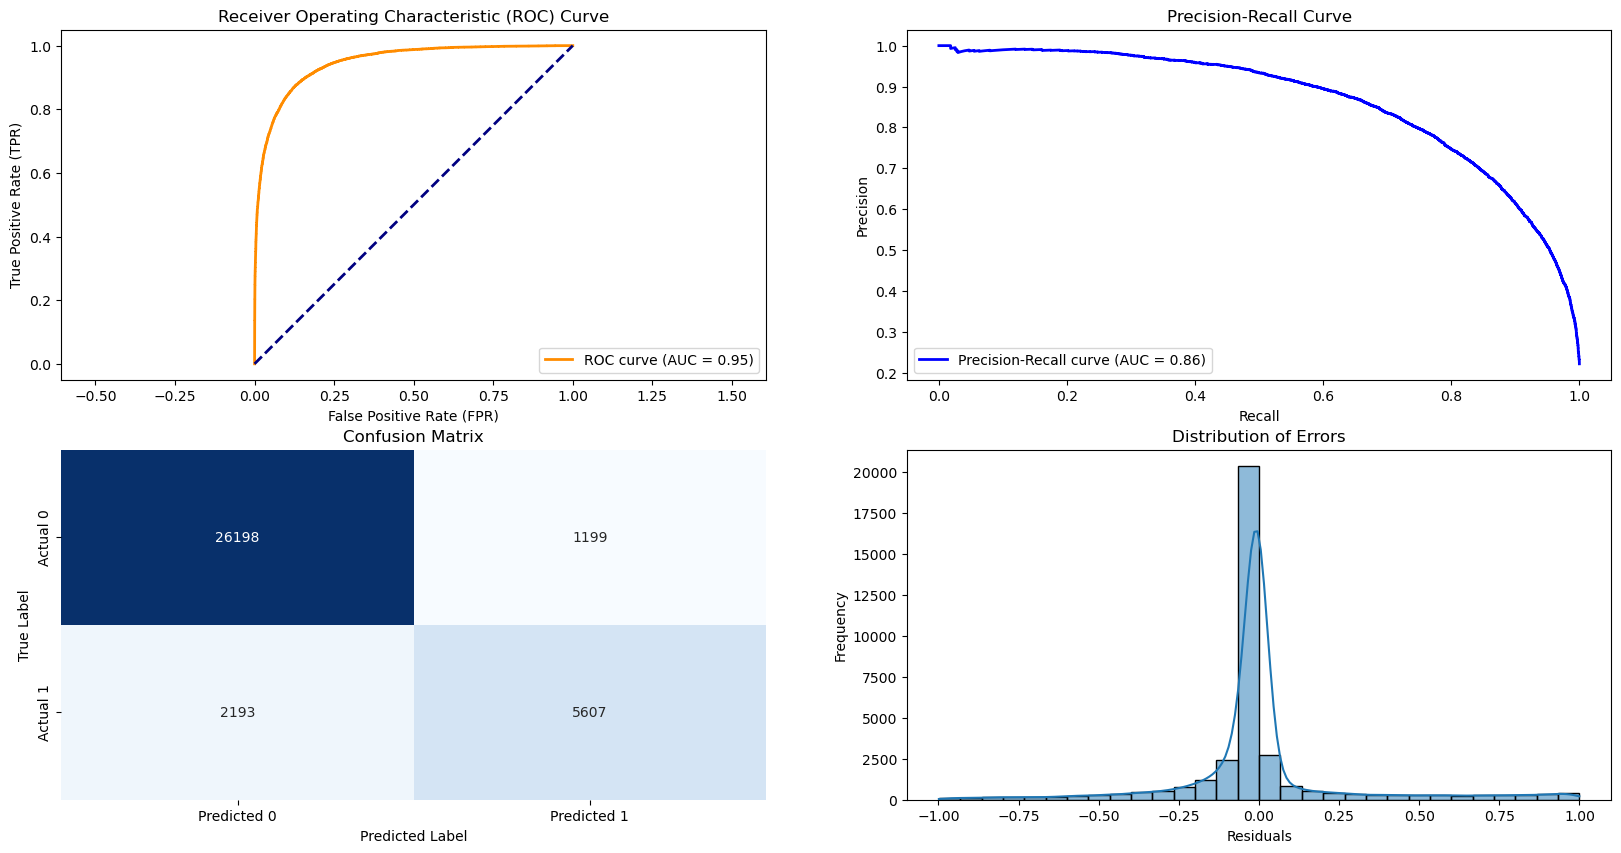

In [ ]:
model = Model(best_xgb_model, name='XGB Smote',
               scaled=True, resample='smote')
model.fit()
model.visualize_metrics()

In [ ]:
metrics_XG_smote = model.get_metrics()
models_df_smote = pd.concat([models_df_smote, metrics_XG_smote.to_frame().T])
print(metrics_XG_smote)

Accuracy                                 0.903628
Precision                                0.823832
Recall                                   0.718846
F1-Score                                 0.767767
ROC AUC                                  0.946324
Confusion Matrix    [[26198, 1199], [2193, 5607]]
PR AUC                                    0.86356
Name                                    XGB Smote
dtype: object


### Undersample

In [ ]:
param_dist = {
    'n_estimators': [500, 800, 1000],  
    'learning_rate': [0.01, 0.05, 0.1],  
    'max_depth': [5, 7, 9],  
    'subsample': [0.6, 0.8, 1.0],  
    'colsample_bytree': [0.6, 0.8, 1.0],  
    'gamma': [0, 0.1, 0.2, 0.3],  
    'reg_alpha': [0, 0.01, 0.1, 1],  
    'reg_lambda': [0, 0.01, 0.1, 1]  
}

xgb_model = XGBClassifier(objective='binary:logistic', use_label_encoder=False)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,  
    scoring='roc_auc',  
    cv=4,  
    verbose=1,
    random_state=42,
    n_jobs=-1  
)

random_search.fit(X_train_under_scaled, y_train_under)
best_xgb_model = random_search.best_estimator_

/home/tony/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


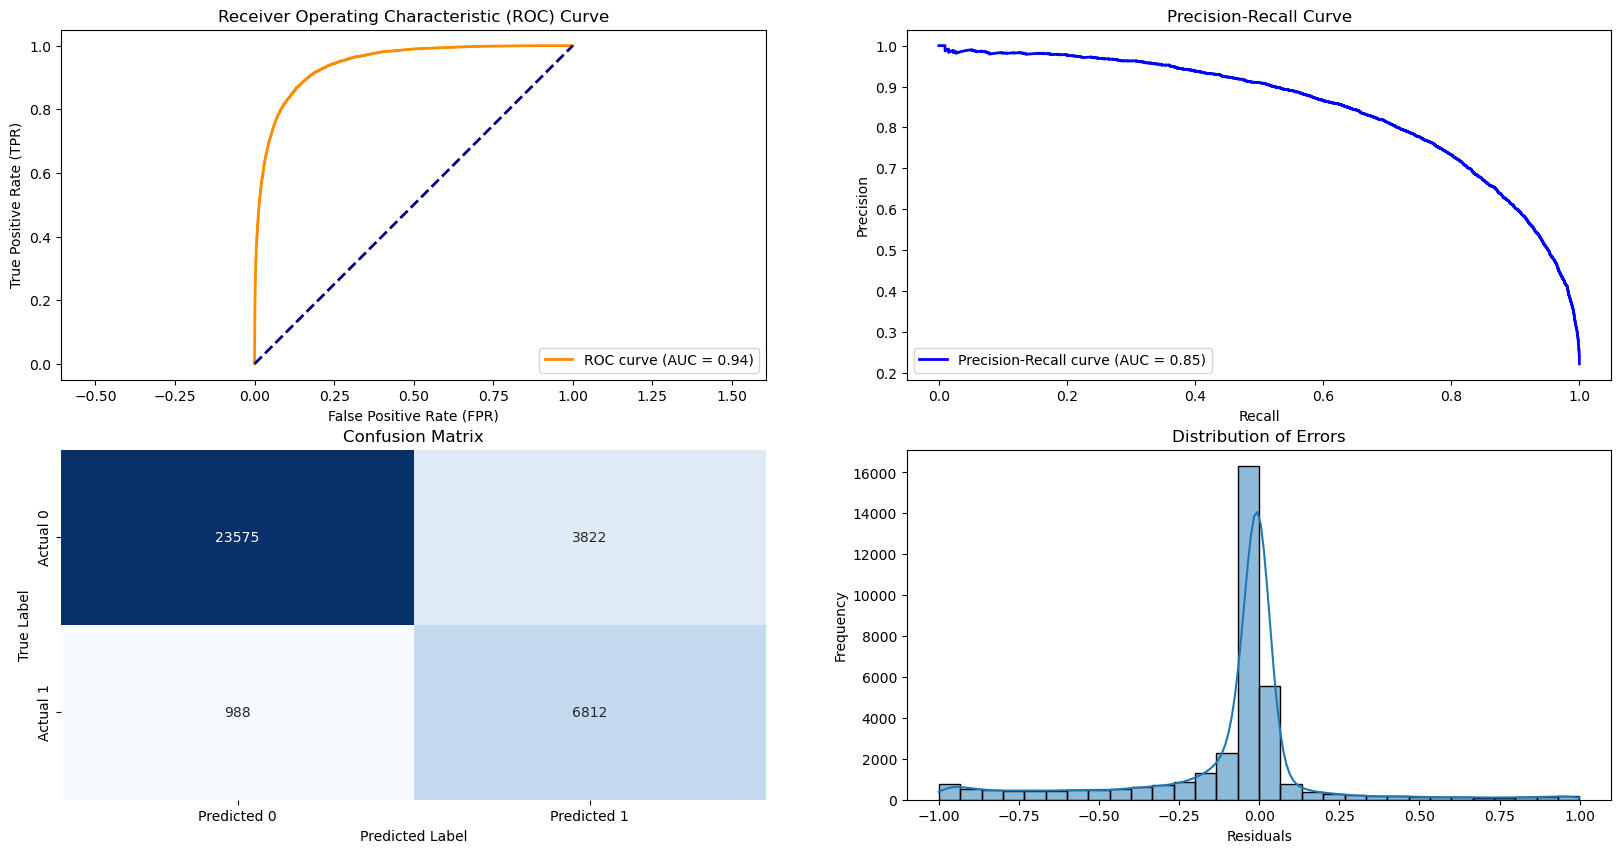

In [ ]:
model = Model(best_xgb_model, name='XGB Undersample',
               scaled=True, resample='under')
model.fit()
model.visualize_metrics()

In [ ]:
metrics_XG_under = model.get_metrics()
models_df_under = pd.concat([models_df_under, metrics_XG_under.to_frame().T])
print(metrics_XG_under)

Accuracy                                0.863341
Precision                               0.640587
Recall                                  0.873333
F1-Score                                0.739069
ROC AUC                                 0.943007
Confusion Matrix    [[23575, 3822], [988, 6812]]
PR AUC                                  0.847361
Name                             XGB Undersample
dtype: object


## CatBoost
Catboost is a variant of gradient boosting that can handle both categorical and numerical features. It does not require any feature encodings techniques like One-Hot Encoder or Label Encoder to convert categorical features into numerical features. It also uses an algorithm called symmetric weighted quantile sketch(SWQS) which automatically handles the missing values in the dataset to reduce overfitting and improve the overall performance of the dataset. 

The main difference from XGB is that CatBoost uses *Symmetric tree growth*, wherease in XGB and GBC trees are grown *level-wise*. Symmetric trees are grown by splitting all leaves at the same depth identically

### No Resample

In [ ]:

model = cb.CatBoostClassifier()

param_grid = {
    'iterations': [500, 800],
    'learning_rate': [0.01, 0.1],
    'depth': [6, 8],
    'l2_leaf_reg': [1, 3],
}

random_search = RandomizedSearchCV(model, 
                                   param_distributions=param_grid, 
                                   n_iter=50, 
                                   cv=3, 
                                   scoring='roc_auc', 
                                   n_jobs=-1, 
                                   random_state=42)

random_search.fit(X_train_scaled, y_train)

best_model = random_search.best_estimator_

/home/tony/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 16 is smaller than n_iter=50. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0:	learn: 0.6842203	total: 199ms	remaining: 1m 39s
1:	learn: 0.6758775	total: 345ms	remaining: 1m 25s
2:	learn: 0.6675518	total: 524ms	remaining: 1m 26s
3:	learn: 0.6590398	total: 624ms	remaining: 1m 17s
4:	learn: 0.6518795	total: 809ms	remaining: 1m 20s
0:	learn: 0.6108308	total: 284ms	remaining: 2m 21s
1:	learn: 0.5507225	total: 377ms	remaining: 1m 33s
0:	learn: 0.6096743	total: 316ms	remaining: 2m 37s
5:	learn: 0.6445168	total: 1.12s	remaining: 1m 32s
0:	learn: 0.6842203	total: 491ms	remaining: 6m 32s
2:	learn: 0.5036695	total: 500ms	remaining: 1m 22s
0:	learn: 0.6842415	total: 564ms	remaining: 4m 41s
0:	learn: 0.6840869	total: 421ms	remaining: 3m 30s
0:	learn: 0.6842413	total: 334ms	remaining: 2m 46s
1:	learn: 0.6758775	total: 653ms	remaining: 4m 20s
0:	learn: 0.6109297	total: 446ms	remaining: 3m 42s
1:	learn: 0.5503959	total: 577ms	remaining: 2m 23s
0:	learn: 0.6842413	total: 431ms	remaining: 5m 44s
0:	learn: 0.6096750	total: 432ms	remaining: 3m 35s
1:	learn: 0.6759849	total: 505m

/home/tony/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


473:	learn: 0.2209846	total: 2m 27s	remaining: 8.1s
465:	learn: 0.2221818	total: 2m 26s	remaining: 10.7s
498:	learn: 0.2201296	total: 2m 26s	remaining: 1m 28s
484:	learn: 0.3090418	total: 2m 27s	remaining: 4.57s
20:	learn: 0.3327057	total: 6.77s	remaining: 4m 11s
7:	learn: 0.3922413	total: 2.46s	remaining: 4m 3s
481:	learn: 0.3097238	total: 2m 27s	remaining: 5.51s
466:	learn: 0.2220744	total: 2m 26s	remaining: 10.4s
492:	learn: 0.3088600	total: 2m 28s	remaining: 1m 32s
479:	learn: 0.3093269	total: 2m 26s	remaining: 1m 37s
482:	learn: 0.3096795	total: 2m 27s	remaining: 5.19s
8:	learn: 0.3828794	total: 2.57s	remaining: 3m 45s
502:	learn: 0.3121204	total: 2m 27s	remaining: 1m 27s
474:	learn: 0.2209050	total: 2m 27s	remaining: 7.79s
499:	learn: 0.2200010	total: 2m 27s	remaining: 1m 28s
21:	learn: 0.3310828	total: 7.04s	remaining: 4m 9s
485:	learn: 0.3089893	total: 2m 28s	remaining: 4.27s
483:	learn: 0.3096121	total: 2m 27s	remaining: 4.88s
475:	learn: 0.2207834	total: 2m 28s	remaining: 7.4

0:	learn: 0.6093501	total: 19.8ms	remaining: 15.8s
1:	learn: 0.5460506	total: 38.7ms	remaining: 15.4s
2:	learn: 0.4955982	total: 56.4ms	remaining: 15s
3:	learn: 0.4611435	total: 72.2ms	remaining: 14.4s
4:	learn: 0.4352976	total: 87.6ms	remaining: 13.9s
5:	learn: 0.4137541	total: 112ms	remaining: 14.9s
6:	learn: 0.3962727	total: 132ms	remaining: 14.9s
7:	learn: 0.3833515	total: 150ms	remaining: 14.9s
8:	learn: 0.3730323	total: 171ms	remaining: 15.1s
9:	learn: 0.3645558	total: 189ms	remaining: 15s
10:	learn: 0.3577227	total: 210ms	remaining: 15s
11:	learn: 0.3508123	total: 232ms	remaining: 15.3s
12:	learn: 0.3455010	total: 255ms	remaining: 15.4s
13:	learn: 0.3406784	total: 276ms	remaining: 15.5s
14:	learn: 0.3371266	total: 302ms	remaining: 15.8s
15:	learn: 0.3340426	total: 324ms	remaining: 15.9s
16:	learn: 0.3316371	total: 351ms	remaining: 16.2s
17:	learn: 0.3290863	total: 380ms	remaining: 16.5s
18:	learn: 0.3270983	total: 406ms	remaining: 16.7s
19:	learn: 0.3250356	total: 432ms	remainin

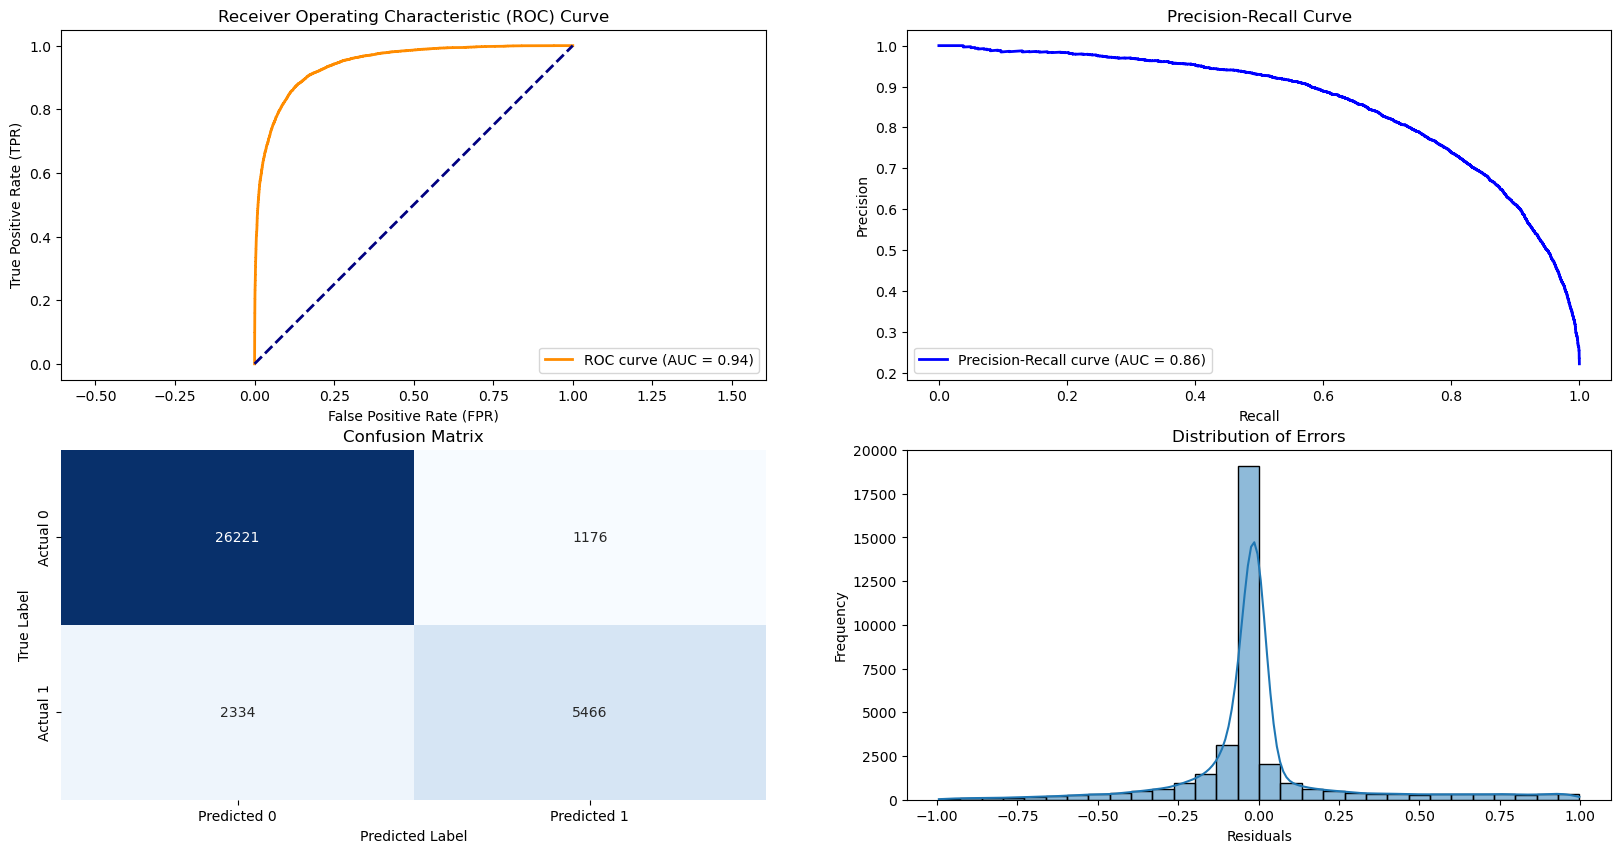

In [ ]:
model = Model(best_model, 
              name='CatBoost No Resample', scaled=True, resample=None)
model.fit()
model.visualize_metrics()

In [ ]:
metrics_CB_no_resample = model.get_metrics()
models_df = pd.concat([models_df, metrics_CB_no_resample.to_frame().T])
print(metrics_CB_no_resample)

Accuracy                                 0.900276
Precision                                0.822945
Recall                                   0.700769
F1-Score                                 0.756959
ROC AUC                                  0.944194
Confusion Matrix    [[26221, 1176], [2334, 5466]]
PR AUC                                   0.857553
Name                         CatBoost No Resample
dtype: object


### SMOTE

In [ ]:

model = cb.CatBoostClassifier()


param_grid = {
    'iterations': [500, 800],
    'learning_rate': [0.01, 0.1],
    'depth': [6, 8],
    'l2_leaf_reg': [1, 3],
}


random_search = RandomizedSearchCV(model, 
                                   param_distributions=param_grid, 
                                   n_iter=50, cv=3, scoring='roc_auc', n_jobs=-1, random_state=42)

random_search.fit(X_train_smote_scaled, y_train_smote)


best_model = random_search.best_estimator_

0:	learn: 0.6098935	total: 30.7ms	remaining: 24.5s
1:	learn: 0.5532194	total: 57.4ms	remaining: 22.9s
2:	learn: 0.5154136	total: 84.5ms	remaining: 22.5s
3:	learn: 0.4879707	total: 110ms	remaining: 22s
4:	learn: 0.4660439	total: 135ms	remaining: 21.4s
5:	learn: 0.4482002	total: 159ms	remaining: 21s
6:	learn: 0.4333311	total: 185ms	remaining: 20.9s
7:	learn: 0.4215218	total: 210ms	remaining: 20.7s
8:	learn: 0.4108406	total: 241ms	remaining: 21.2s
9:	learn: 0.4024188	total: 275ms	remaining: 21.7s
10:	learn: 0.3942430	total: 309ms	remaining: 22.1s
11:	learn: 0.3886294	total: 341ms	remaining: 22.4s
12:	learn: 0.3832923	total: 368ms	remaining: 22.3s
13:	learn: 0.3783319	total: 397ms	remaining: 22.3s
14:	learn: 0.3721806	total: 427ms	remaining: 22.3s
15:	learn: 0.3666552	total: 454ms	remaining: 22.3s
16:	learn: 0.3590462	total: 486ms	remaining: 22.4s
17:	learn: 0.3558970	total: 517ms	remaining: 22.5s
18:	learn: 0.3534660	total: 550ms	remaining: 22.6s
19:	learn: 0.3490578	total: 586ms	remainin

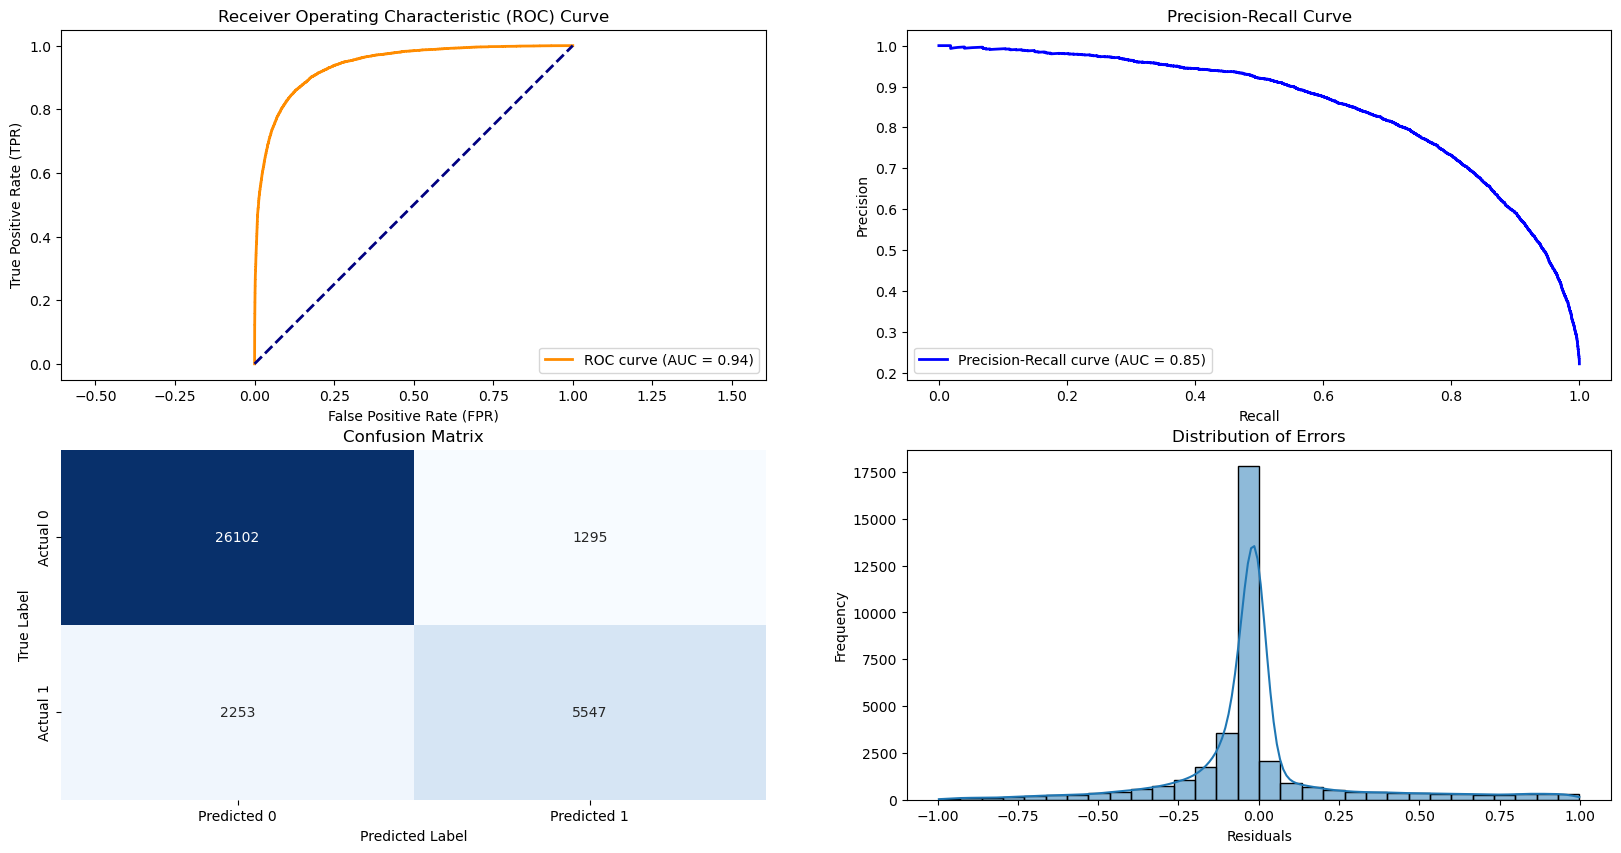

In [ ]:
model = Model(best_model, 
              name='CatBoost SMOTE', scaled=True, resample='smote')
model.fit()
model.visualize_metrics()

In [ ]:
metrics_CB_smote = model.get_metrics()
models_df_smote = pd.concat([models_df_smote, metrics_CB_smote.to_frame().T])
print(metrics_CB_smote)

Accuracy                                 0.899196
Precision                                0.810728
Recall                                   0.711154
F1-Score                                 0.757683
ROC AUC                                  0.940174
Confusion Matrix    [[26102, 1295], [2253, 5547]]
PR AUC                                   0.849674
Name                               CatBoost SMOTE
dtype: object


### Undersample

In [ ]:

model = cb.CatBoostClassifier()

param_grid = {
    'iterations': [500, 800],
    'learning_rate': [0.01, 0.1],
    'depth': [6, 8],
    'l2_leaf_reg': [1, 3],
}


random_search = RandomizedSearchCV(model, 
                                   param_distributions=param_grid, 
                                   n_iter=50, cv=3, scoring='roc_auc', n_jobs=-1, random_state=42)


random_search.fit(X_train_under_scaled, y_train_under)


best_model = random_search.best_estimator_

0:	learn: 0.6359779	total: 16.4ms	remaining: 13.1s
1:	learn: 0.5934642	total: 30.4ms	remaining: 12.1s
2:	learn: 0.5593109	total: 48.7ms	remaining: 12.9s
3:	learn: 0.5325249	total: 64.1ms	remaining: 12.8s
4:	learn: 0.5106993	total: 80.9ms	remaining: 12.9s
5:	learn: 0.4928610	total: 98.6ms	remaining: 13.1s
6:	learn: 0.4788876	total: 117ms	remaining: 13.3s
7:	learn: 0.4679175	total: 138ms	remaining: 13.7s
8:	learn: 0.4581465	total: 157ms	remaining: 13.8s
9:	learn: 0.4509284	total: 176ms	remaining: 13.9s
10:	learn: 0.4447962	total: 195ms	remaining: 14s
11:	learn: 0.4383504	total: 215ms	remaining: 14.1s
12:	learn: 0.4332667	total: 231ms	remaining: 14s
13:	learn: 0.4289115	total: 250ms	remaining: 14s
14:	learn: 0.4257529	total: 267ms	remaining: 14s
15:	learn: 0.4214980	total: 285ms	remaining: 14s
16:	learn: 0.4182525	total: 304ms	remaining: 14s
17:	learn: 0.4157777	total: 321ms	remaining: 14s
18:	learn: 0.4131613	total: 338ms	remaining: 13.9s
19:	learn: 0.4107833	total: 355ms	remaining: 13.9

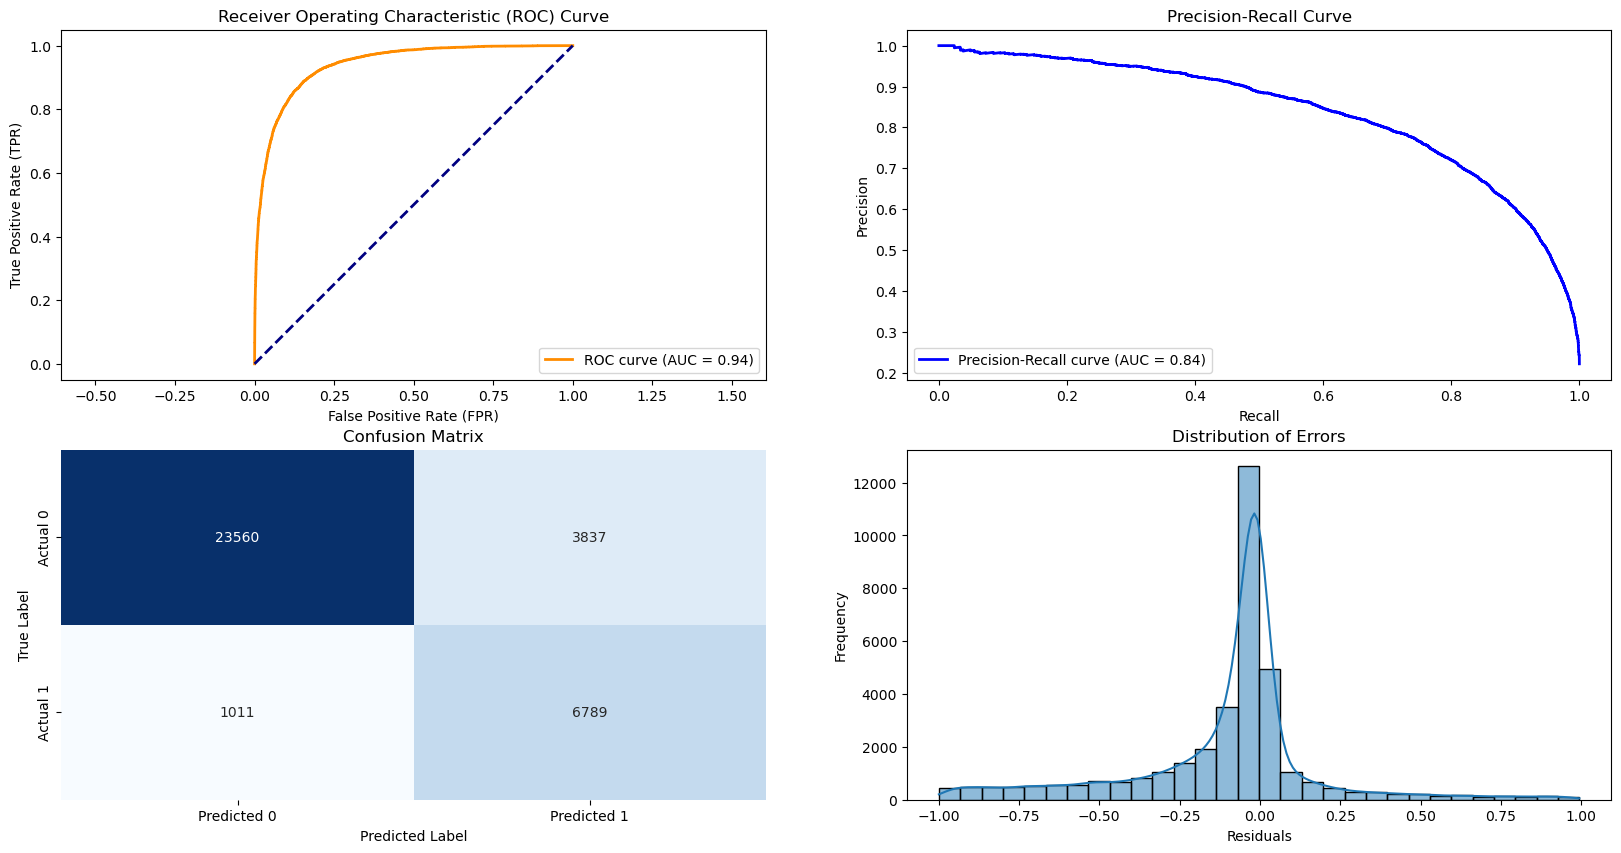

In [ ]:
model = Model(best_model, 
              name='CatBoost Undersample', scaled=True, resample='under')
model.fit()
model.visualize_metrics()

In [ ]:
metrics_CB_under = model.get_metrics()
models_df_under = pd.concat([models_df_under, metrics_CB_under.to_frame().T])
print(metrics_CB_under)

Accuracy                                 0.862261
Precision                                0.638905
Recall                                   0.870385
F1-Score                                 0.736894
ROC AUC                                  0.939948
Confusion Matrix    [[23560, 3837], [1011, 6789]]
PR AUC                                   0.837157
Name                         CatBoost Undersample
dtype: object


## LightGBM
LightGBM stands for Light Gradient Boosting Machine, and it is designed to be fast and efficient. LightGBM has several advantages over other gradient boosting frameworks, such as XGBoost or CatBoost. Some of these advantages are:
- It supports categorical features directly, without the need for one-hot encoding or label encoding. (like CatBoost)

- It uses histogram-based algorithms, which reduce the number of split points and speed up the training process.

- It uses leaf-wise growth, which means it splits the tree by the leaf that has the maximum delta loss, rather than level-wise growth, which splits the tree by levels. This can result in better accuracy and lower overfitting.

- It supports parallel and distributed learning, which can scale up to large datasets and clusters.

### No Resample

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb

model = lgb.LGBMClassifier(objective="binary")

param_distributions = {
    'n_estimators': [500, 1000, 1500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [6, 8, 10, 12],
    'num_leaves': [20, 31, 40, 50],
    'min_child_samples': [20, 30, 40],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}


random_search = RandomizedSearchCV(model, param_distributions, n_iter=50, cv=3, scoring='roc_auc', n_jobs=-1, random_state=42)


random_search.fit(X_train_scaled, y_train)


best_model_lgb = random_search.best_estimator_

[LightGBM] [Info] Number of positive: 15601, number of negative: 54792
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3115
[LightGBM] [Info] Number of data points in the train set: 70393, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221627 -> initscore=-1.256209
[LightGBM] [Info] Start training from score -1.256209
[LightGBM] [Info] Number of positive: 15600, number of negative: 54793
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.120908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3114
[LightGBM] [Info] Number of data points in the train set: 70393, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221613 -> initscore=-1.256292
[L

/home/tony/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 15600, number of negative: 54793
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3114
[LightGBM] [Info] Number of data points in the train set: 70393, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221613 -> initscore=-1.256292
[LightGBM] [Info] Start training from score -1.256292
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Info] Number of positive: 23401, number of negative: 82189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 105590, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221621 -> initscore=-1.256243
[LightGBM] [Info] Start training from score -1.256243


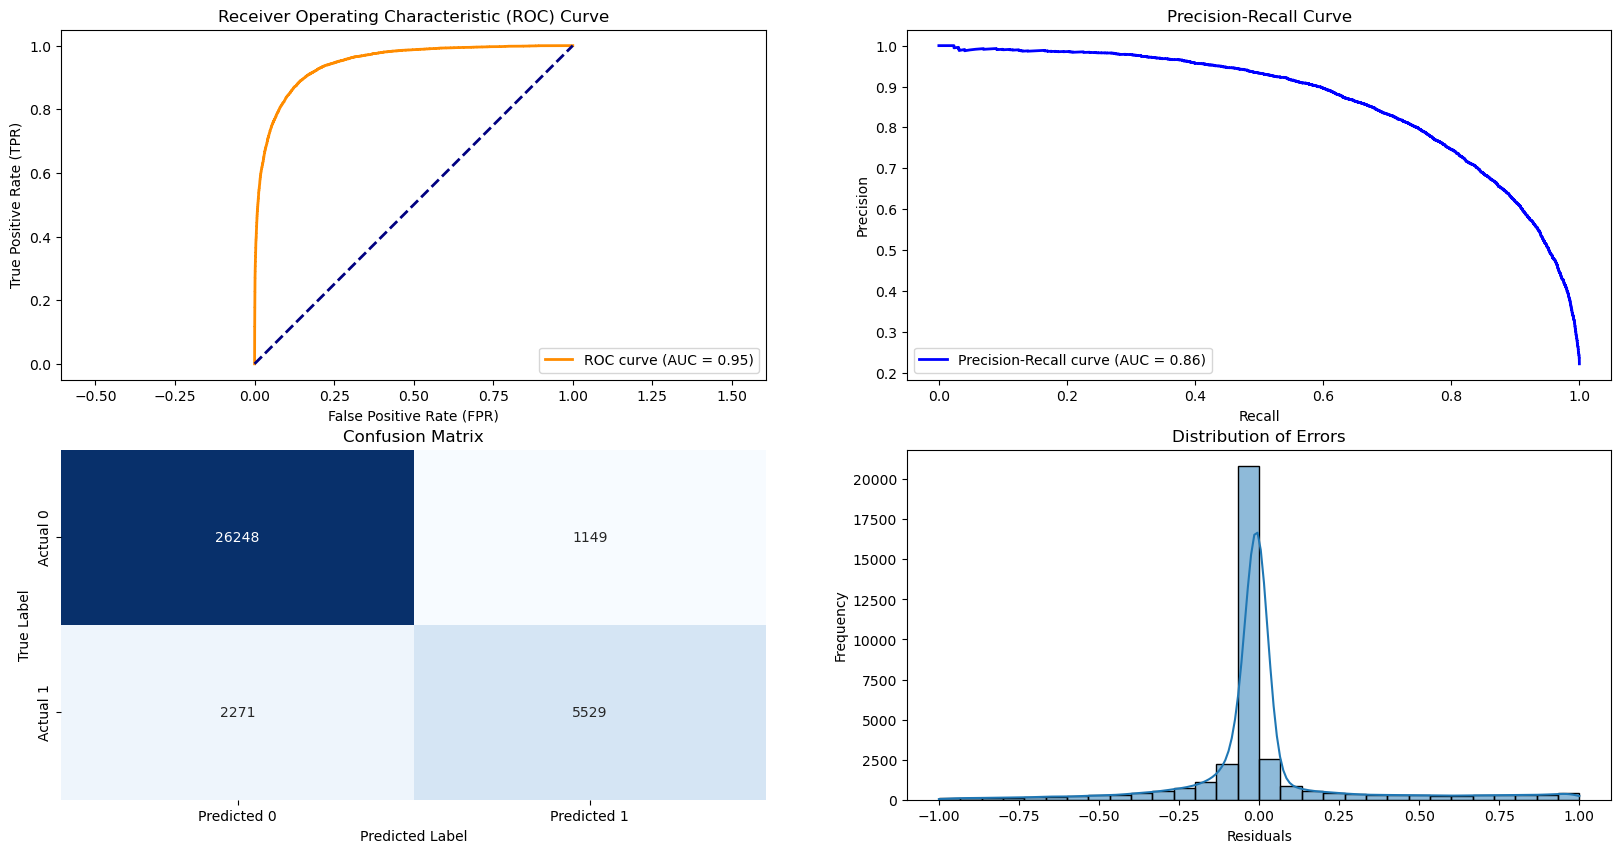

In [ ]:
model = Model(best_model_lgb, 
              name='LightGBM No Resample', scaled=True, resample=None)
model.fit()
model.visualize_metrics()

In [ ]:
metrics_lgb_no_resample = model.get_metrics()
models_df = pd.concat([models_df, metrics_lgb_no_resample.to_frame().T])
print(metrics_lgb_no_resample)

Accuracy                                 0.902833
Precision                                0.827942
Recall                                   0.708846
F1-Score                                  0.76378
ROC AUC                                  0.945983
Confusion Matrix    [[26248, 1149], [2271, 5529]]
PR AUC                                   0.862739
Name                         LightGBM No Resample
dtype: object


### SMOTE

In [ ]:

model = lgb.LGBMClassifier(objective="binary")


param_distributions = {
    'n_estimators': [500, 1000, 1500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [6, 8, 10, 12],
    'num_leaves': [20, 31, 40, 50],
    'min_child_samples': [20, 30, 40],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}


random_search = RandomizedSearchCV(model, param_distributions, n_iter=50, cv=3, scoring='roc_auc', n_jobs=-1, random_state=42)

random_search.fit(X_train_smote_scaled, y_train_smote)

best_model_lgb = random_search.best_estimator_

[LightGBM] [Info] Number of positive: 82189, number of negative: 82189
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3652
[LightGBM] [Info] Number of data points in the train set: 164378, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


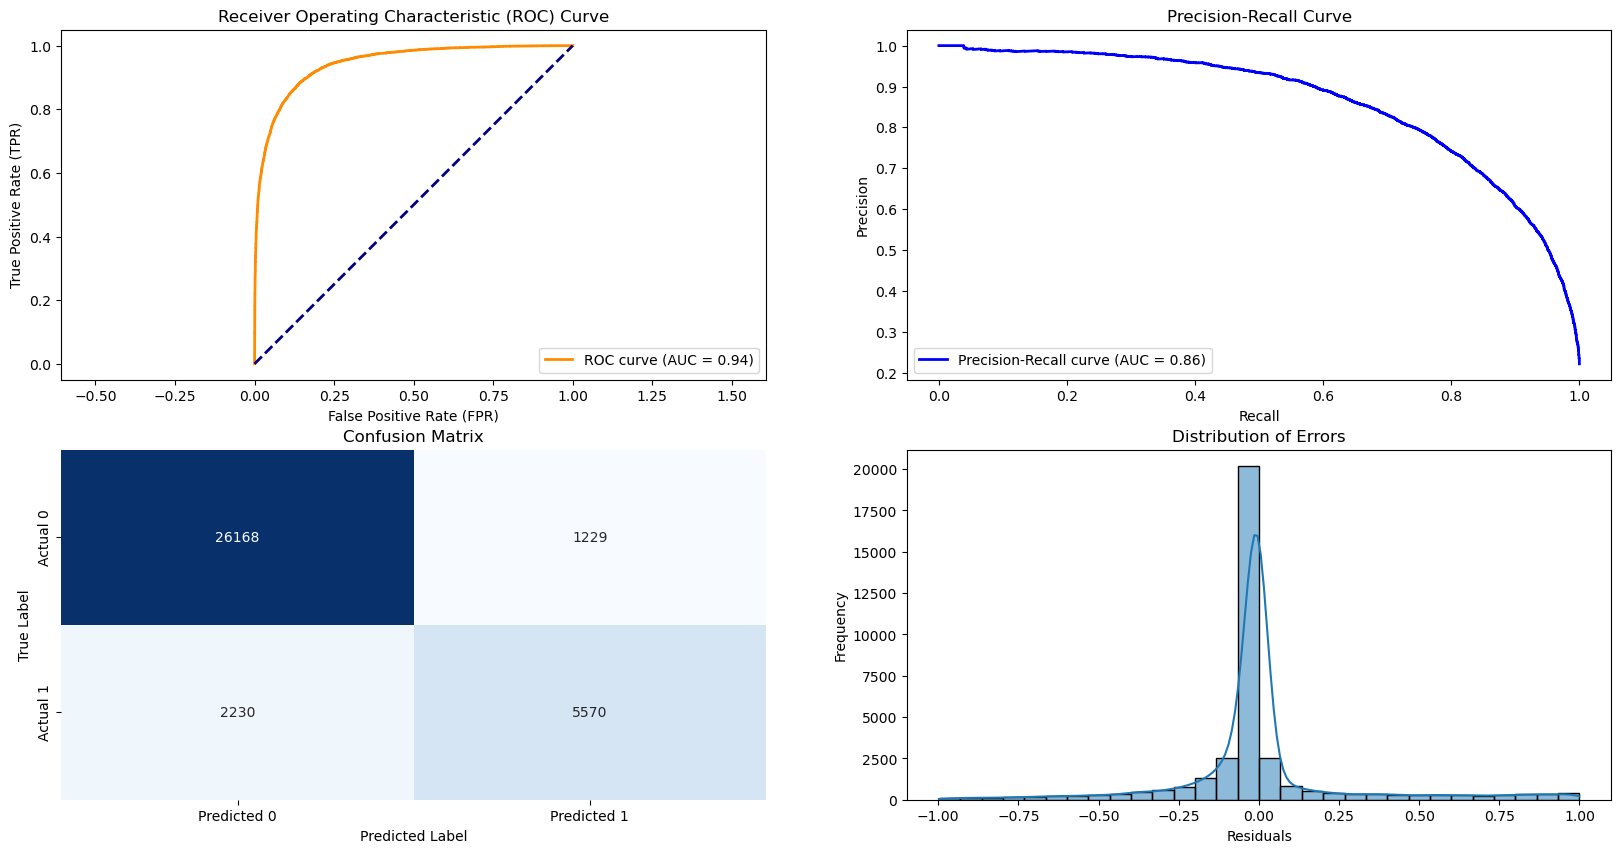

In [ ]:
model = Model(best_model_lgb, 
              name='Ligth GBM SMOTE', scaled=True, resample='smote')
model.fit()
model.visualize_metrics()

In [ ]:
metrics_lgb_smote = model.get_metrics()
models_df_smote = pd.concat([models_df_smote, metrics_lgb_smote.to_frame().T])
print(metrics_lgb_smote)

Accuracy                                 0.901725
Precision                                0.819238
Recall                                   0.714103
F1-Score                                 0.763066
ROC AUC                                  0.944573
Confusion Matrix    [[26168, 1229], [2230, 5570]]
PR AUC                                   0.860649
Name                              Ligth GBM SMOTE
dtype: object


### Undersample

In [ ]:

model = lgb.LGBMClassifier(objective="binary")

param_distributions = {
    'n_estimators': [500, 1000, 1500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [6, 8, 10, 12],
    'num_leaves': [20, 31, 40, 50],
    'min_child_samples': [20, 30, 40],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

random_search = RandomizedSearchCV(model, param_distributions, n_iter=50, cv=3, scoring='roc_auc', n_jobs=-1, random_state=42)

random_search.fit(X_train_under_scaled, y_train_under)

best_model_lgb = random_search.best_estimator_

[LightGBM] [Info] Number of positive: 23401, number of negative: 23401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3162
[LightGBM] [Info] Number of data points in the train set: 46802, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


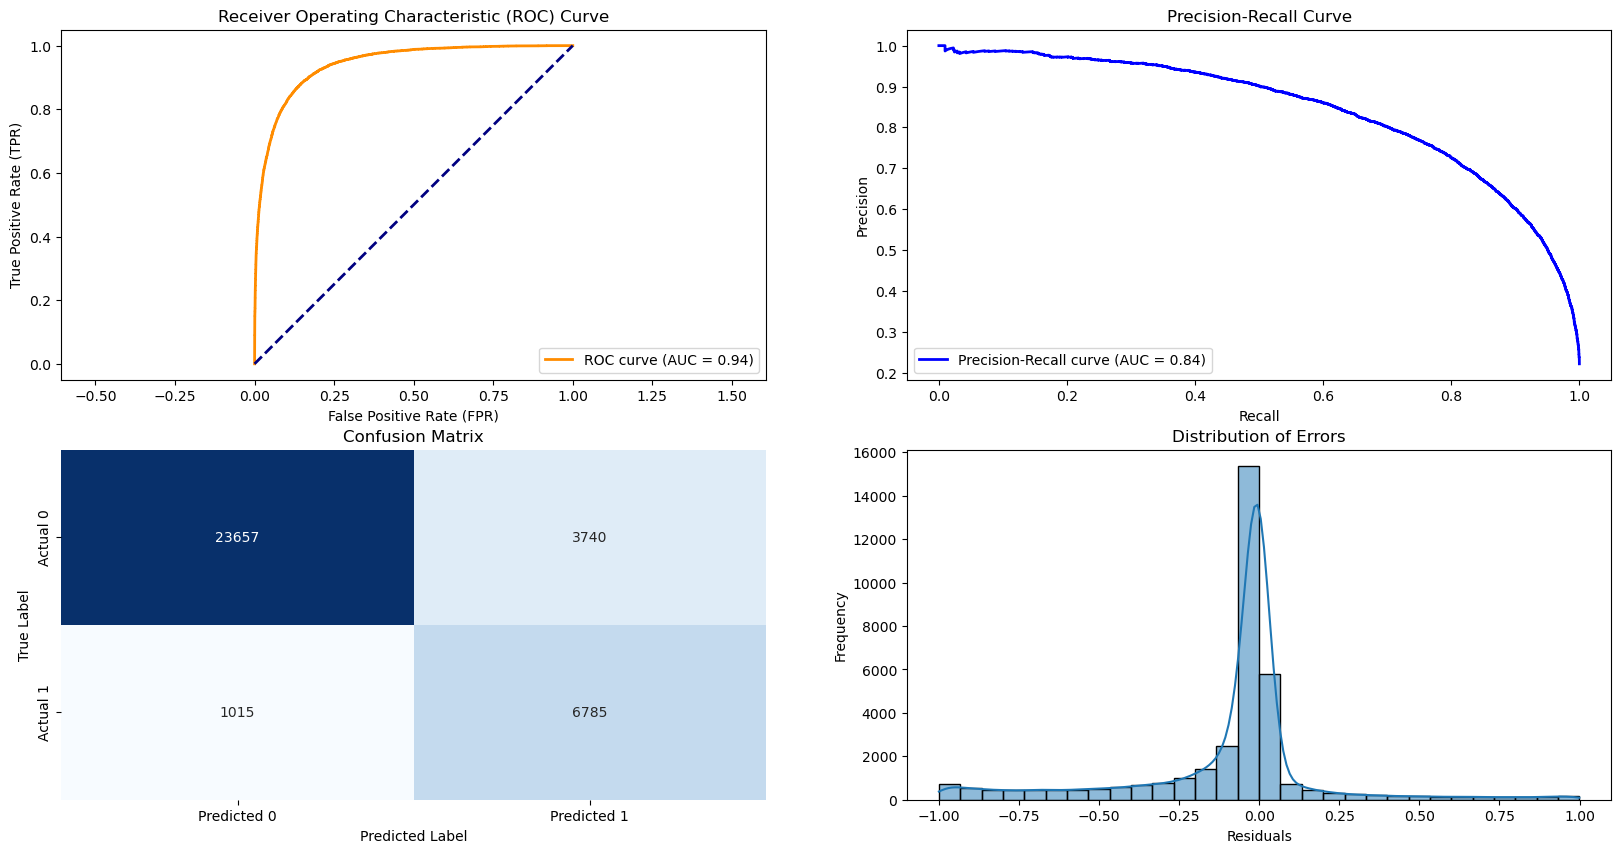

In [ ]:
model = Model(best_model_lgb, 
              name='Ligth GBM Under', scaled=True, resample='under')
model.fit()
model.visualize_metrics()

In [ ]:
metrics_lgb_under = model.get_metrics()
models_df_under = pd.concat([models_df_under, metrics_lgb_under.to_frame().T])
print(metrics_lgb_under)

Accuracy                                 0.864903
Precision                                0.644656
Recall                                   0.869872
F1-Score                                 0.740518
ROC AUC                                  0.941262
Confusion Matrix    [[23657, 3740], [1015, 6785]]
PR AUC                                   0.842884
Name                              Ligth GBM Under
dtype: object


## Neural Network

### No Resample

In [ ]:
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Input(shape=[X_train.shape[1]]),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(96, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'), 
    Dense(1, activation='sigmoid'),
])
optimizer = Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Model training
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    batch_size=100,
    epochs=200,
    shuffle = True,
    callbacks=[early_stopping]
)

Epoch 1/200
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - binary_accuracy: 0.7702 - loss: 0.4694 - val_binary_accuracy: 0.8561 - val_loss: 0.3354
Epoch 2/200
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - binary_accuracy: 0.8476 - loss: 0.3473 - val_binary_accuracy: 0.8590 - val_loss: 0.3278
Epoch 3/200
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - binary_accuracy: 0.8516 - loss: 0.3414 - val_binary_accuracy: 0.8610 - val_loss: 0.3238
Epoch 4/200
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - binary_accuracy: 0.8537 - loss: 0.3370 - val_binary_accuracy: 0.8621 - val_loss: 0.3220
Epoch 5/200
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - binary_accuracy: 0.8545 - loss: 0.3339 - val_binary_accuracy: 0.8631 - val_loss: 0.3201
Epoch 6/200
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - binary_accuracy: 0.8567 - loss: 0.3315 - val_binary_accuracy: 0.8638 - val_loss: 0.3189
Epoch 7/200
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - binary_accuracy: 0.8564 - loss: 0.3302 - val_binary_accuracy: 0.8650 - va

Best Validation Loss: 0.2140
Best Validation Accuracy: 0.9104


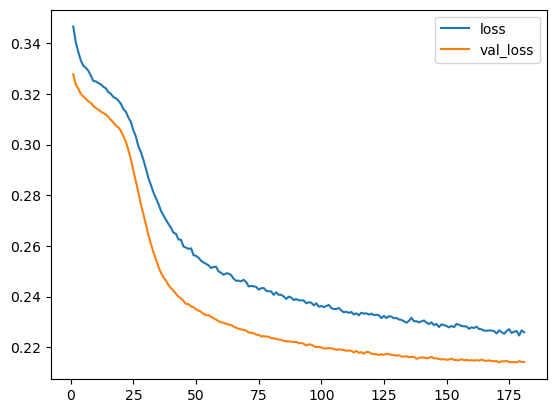

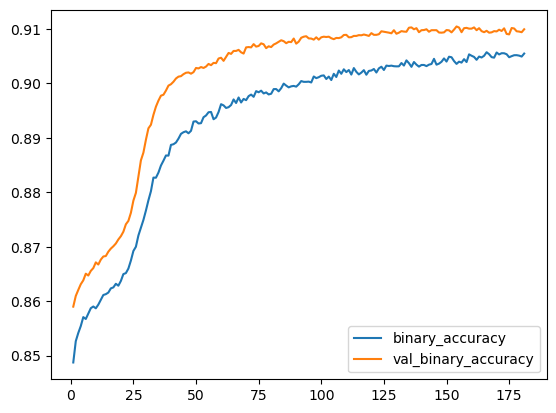

In [ ]:
history_df = pd.DataFrame(history.history)

history_df.loc[1:, ['loss', 'val_loss']].plot()
history_df.loc[1:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))

In [ ]:
y_pred_prob_test = model.predict(X_test_scaled)
y_pred_test = np.where(y_pred_prob_test.squeeze() < 0.5, 0, 1)
acc_test = metrics.accuracy_score(y_test, y_pred_test)
print(acc_test)

1100/1100 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
0.9098218598175981


In [ ]:
accuracy = metrics.accuracy_score(y_test, y_pred_test)
precision = metrics.precision_score(y_test, y_pred_test)
recall = metrics.recall_score(y_test, y_pred_test)
f1 = metrics.f1_score(y_test, y_pred_test)
roc_auc = metrics.roc_auc_score(y_test, y_pred_prob_test)
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
pr_auc = metrics.average_precision_score(y_test, y_pred_prob_test)
metrics_TF = pd.Series({
'Accuracy': accuracy,
'Precision': precision,
'Recall': recall,
'F1-Score': f1,
'ROC AUC': roc_auc,
'PR AUC': pr_auc,
'Confusion Matrix': conf_mat,
'Name':'NN No Resample'
})
print(metrics_TF)
models_df = pd.concat([models_df, metrics_TF.to_frame().T])

Accuracy                                 0.909822
Precision                                0.831091
Recall                                   0.744359
F1-Score                                 0.785337
ROC AUC                                  0.955522
PR AUC                                   0.885739
Confusion Matrix    [[26217, 1180], [1994, 5806]]
Name                               NN No Resample
dtype: object


## SMOTE

In [ ]:
from tensorflow.keras.regularizers import l2

model = Sequential([
    Input(shape=[X_train.shape[1]]),
    BatchNormalization(),
    Dense(256, activation='relu',  kernel_regularizer=l2(0.001)),
    Dropout(0.05),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.05),
    Dense(96, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'), 
    Dense(1, activation='sigmoid'),
])
optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Model training
history = model.fit(
    X_train_smote_scaled, y_train_smote,
    validation_data=(X_test_smote_scaled, y_test),
    batch_size=1800,
    epochs=300,
    shuffle = True,
    callbacks=[early_stopping]
)

Epoch 1/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - binary_accuracy: 0.6733 - loss: 0.9387 - val_binary_accuracy: 0.8025 - val_loss: 0.7677
Epoch 2/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.7937 - loss: 0.7296 - val_binary_accuracy: 0.8103 - val_loss: 0.6850
Epoch 3/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.8083 - loss: 0.6728 - val_binary_accuracy: 0.8161 - val_loss: 0.6493
Epoch 4/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.8168 - loss: 0.6382 - val_binary_accuracy: 0.8211 - val_loss: 0.6176
Epoch 5/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.8204 - loss: 0.6111 - val_binary_accuracy: 0.8235 - val_loss: 0.5957
Epoch 6/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.8241 - loss: 0.5883 - val_binary_accuracy: 0.8267 - val_loss: 0.5749
Epoch 7/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.8276 - loss: 0.5681 - val_binary_accuracy: 0.8296 - val_loss: 0.5560
Epoch 8/300


Best Validation Loss: 0.2779
Best Validation Accuracy: 0.8949


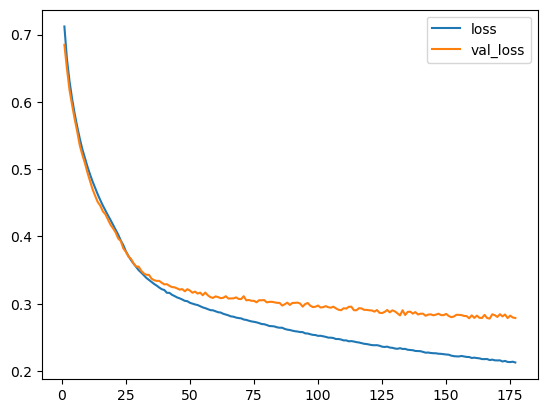

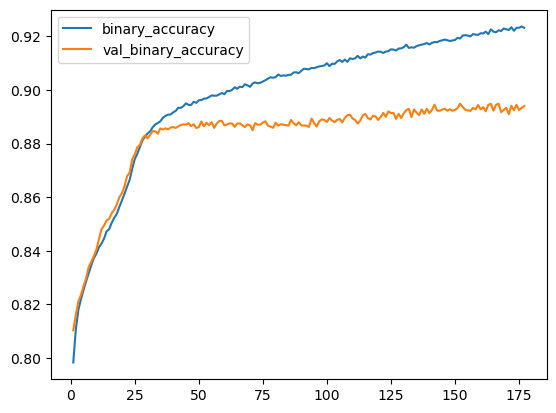

In [ ]:
history_df = pd.DataFrame(history.history)

history_df.loc[1:, ['loss', 'val_loss']].plot()
history_df.loc[1:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))

In [ ]:
y_pred_prob_test = model.predict(X_test_smote_scaled)
y_pred_test = np.where(y_pred_prob_test.squeeze() < 0.5, 0, 1)
acc_test = metrics.accuracy_score(y_test, y_pred_test)
print(acc_test)

1100/1100 ━━━━━━━━━━━━━━━━━━━━ 1s 793us/step
0.894905815836577


In [ ]:
accuracy = metrics.accuracy_score(y_test, y_pred_test)
precision = metrics.precision_score(y_test, y_pred_test)
recall = metrics.recall_score(y_test, y_pred_test)
f1 = metrics.f1_score(y_test, y_pred_test)
roc_auc = metrics.roc_auc_score(y_test, y_pred_prob_test)
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
pr_auc = metrics.average_precision_score(y_test, y_pred_prob_test)
metrics_TF = pd.Series({
'Accuracy': accuracy,
'Precision': precision,
'Recall': recall,
'F1-Score': f1,
'ROC AUC': roc_auc,
'PR AUC': pr_auc,
'Confusion Matrix': conf_mat,
'Name':'NN Smote'
})
print(metrics_TF)
models_df_smote = pd.concat([models_df_smote, metrics_TF.to_frame().T])

Accuracy                                 0.894906
Precision                                0.733888
Recall                                   0.824872
F1-Score                                 0.776725
ROC AUC                                  0.950912
PR AUC                                   0.873912
Confusion Matrix    [[25064, 2333], [1366, 6434]]
Name                                     NN Smote
dtype: object


## Undersample

In [ ]:
model = Sequential([
    Input(shape=[X_train.shape[1]]),
    BatchNormalization(),
    Dense(96, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)), 
    Dropout(0.2),
    Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(1, activation='sigmoid'),
])
optimizer = Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Model training
history = model.fit(
    X_train_under_scaled, y_train_under,
    validation_data=(X_test_under_scaled, y_test),
    batch_size=30,
    epochs=200,
    callbacks=[early_stopping]
)

Epoch 1/200
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - binary_accuracy: 0.6991 - loss: 0.7345 - val_binary_accuracy: 0.8047 - val_loss: 0.5575
Epoch 2/200
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - binary_accuracy: 0.7851 - loss: 0.5967 - val_binary_accuracy: 0.8079 - val_loss: 0.5204
Epoch 3/200
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - binary_accuracy: 0.7912 - loss: 0.5629 - val_binary_accuracy: 0.8098 - val_loss: 0.5001
Epoch 4/200
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - binary_accuracy: 0.7930 - loss: 0.5404 - val_binary_accuracy: 0.8107 - val_loss: 0.4813
Epoch 5/200
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - binary_accuracy: 0.7981 - loss: 0.5235 - val_binary_accuracy: 0.8154 - val_loss: 0.4653
Epoch 6/200
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - binary_accuracy: 0.7979 - loss: 0.5095 - val_binary_accuracy: 0.8159 - val_loss: 0.4574
Epoch 7/200
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - binary_accuracy: 0.8010 - loss: 0.4983 - val_binary_accuracy: 0.8184 - va

Best Validation Loss: 0.3054
Best Validation Accuracy: 0.8796


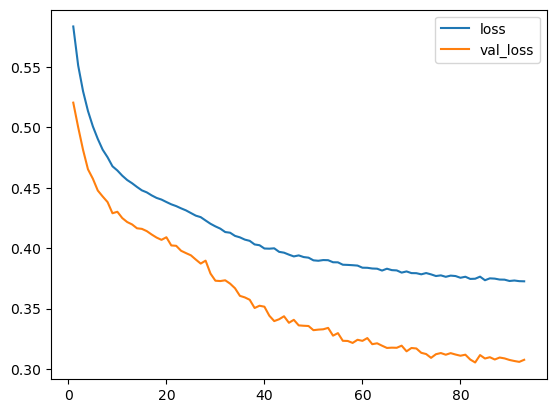

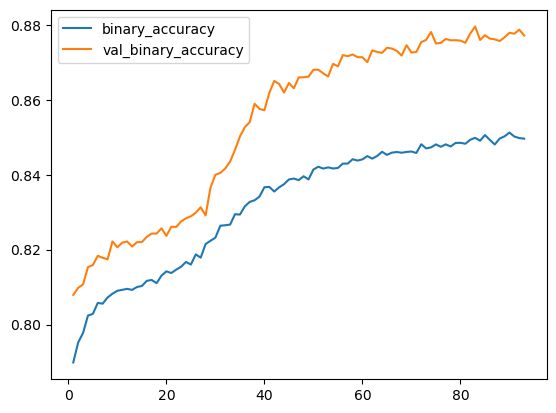

In [ ]:
history_df = pd.DataFrame(history.history)

history_df.loc[1:, ['loss', 'val_loss']].plot()
history_df.loc[1:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))

In [ ]:
y_pred_prob_test = model.predict(X_test_under_scaled)
y_pred_test = np.where(y_pred_prob_test.squeeze() < 0.5, 0, 1)
acc_test = metrics.accuracy_score(y_test, y_pred_test)
print(acc_test)

1100/1100 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
0.8795920106827286


In [ ]:
accuracy = metrics.accuracy_score(y_test, y_pred_test)
precision = metrics.precision_score(y_test, y_pred_test)
recall = metrics.recall_score(y_test, y_pred_test)
f1 = metrics.f1_score(y_test, y_pred_test)
roc_auc = metrics.roc_auc_score(y_test, y_pred_prob_test)
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
pr_auc = metrics.average_precision_score(y_test, y_pred_prob_test)
metrics_TF = pd.Series({
'Accuracy': accuracy,
'Precision': precision,
'Recall': recall,
'F1-Score': f1,
'ROC AUC': roc_auc,
'PR AUC': pr_auc,
'Confusion Matrix': conf_mat,
'Name':'NN Undersample'
})
print(metrics_TF)
models_df_under = pd.concat([models_df_under, metrics_TF.to_frame().T])

Accuracy                                 0.879592
Precision                                0.684904
Recall                                   0.845769
F1-Score                                 0.756884
ROC AUC                                  0.943716
PR AUC                                   0.846761
Confusion Matrix    [[24362, 3035], [1203, 6597]]
Name                               NN Undersample
dtype: object


# Conclusion
Now for each type of work (No Resample, SMOTE and Undersample) and for each metric we find the best method

## No Resample

In [ ]:
models_df

Name  Accuracy Precision    Recall  F1-Score  \
0                  LDA No Resample    0.8578  0.719906  0.586538  0.646415   
0  Logistic Regression No Resample  0.859221  0.738634  0.564487  0.639924   
0                   DT No Resample  0.857971  0.729477  0.570769  0.640437   
0                   RF No Resample  0.887689  0.827516  0.623077   0.71089   
0                  KNN No Resample  0.855613  0.720117      0.57  0.636325   
0    Gradient Boosting No Resample  0.899991  0.816568  0.707692  0.758242   
0                  XGB No Resample  0.904026  0.834392  0.707308  0.765612   
0             CatBoost No Resample  0.900276  0.822945  0.700769  0.756959   
0             LightGBM No Resample  0.902833  0.827942  0.708846   0.76378   
0                   NN No Resample  0.909822  0.831091  0.744359  0.785337   

    ROC AUC               Confusion Matrix    PR AUC  
0  0.888577  [[25617, 1780], [3225, 4575]]  0.727093  
0  0.889739  [[25839, 1558], [3397, 4403]]  0.729967  
0   0.88525  [[25746, 1651], [3348, 4452]]  0.726767  
0  0.928375  [[26384, 1013], [2940, 4860]]  0.817843  
0  0.861607  [[25669, 1728], [3354, 4446]]  0.656541  
0   0.94288  [[26157, 1240], [2280, 5520]]  0.856161  
0  0.948367  [[26302, 1095], [2283, 5517]]  0.867472  
0  0.944194  [[26221, 1176], [2334, 5466]]  0.857553  
0  0.945983  [[26248, 1149], [2271, 5529]]  0.862739  
0  0.955522  [[26217, 1180], [1994, 5806]]  0.885739

In [ ]:
models_df.index = models_df.Name
models_df = models_df.drop('Name',axis=1)

<Axes: xlabel='Name'>

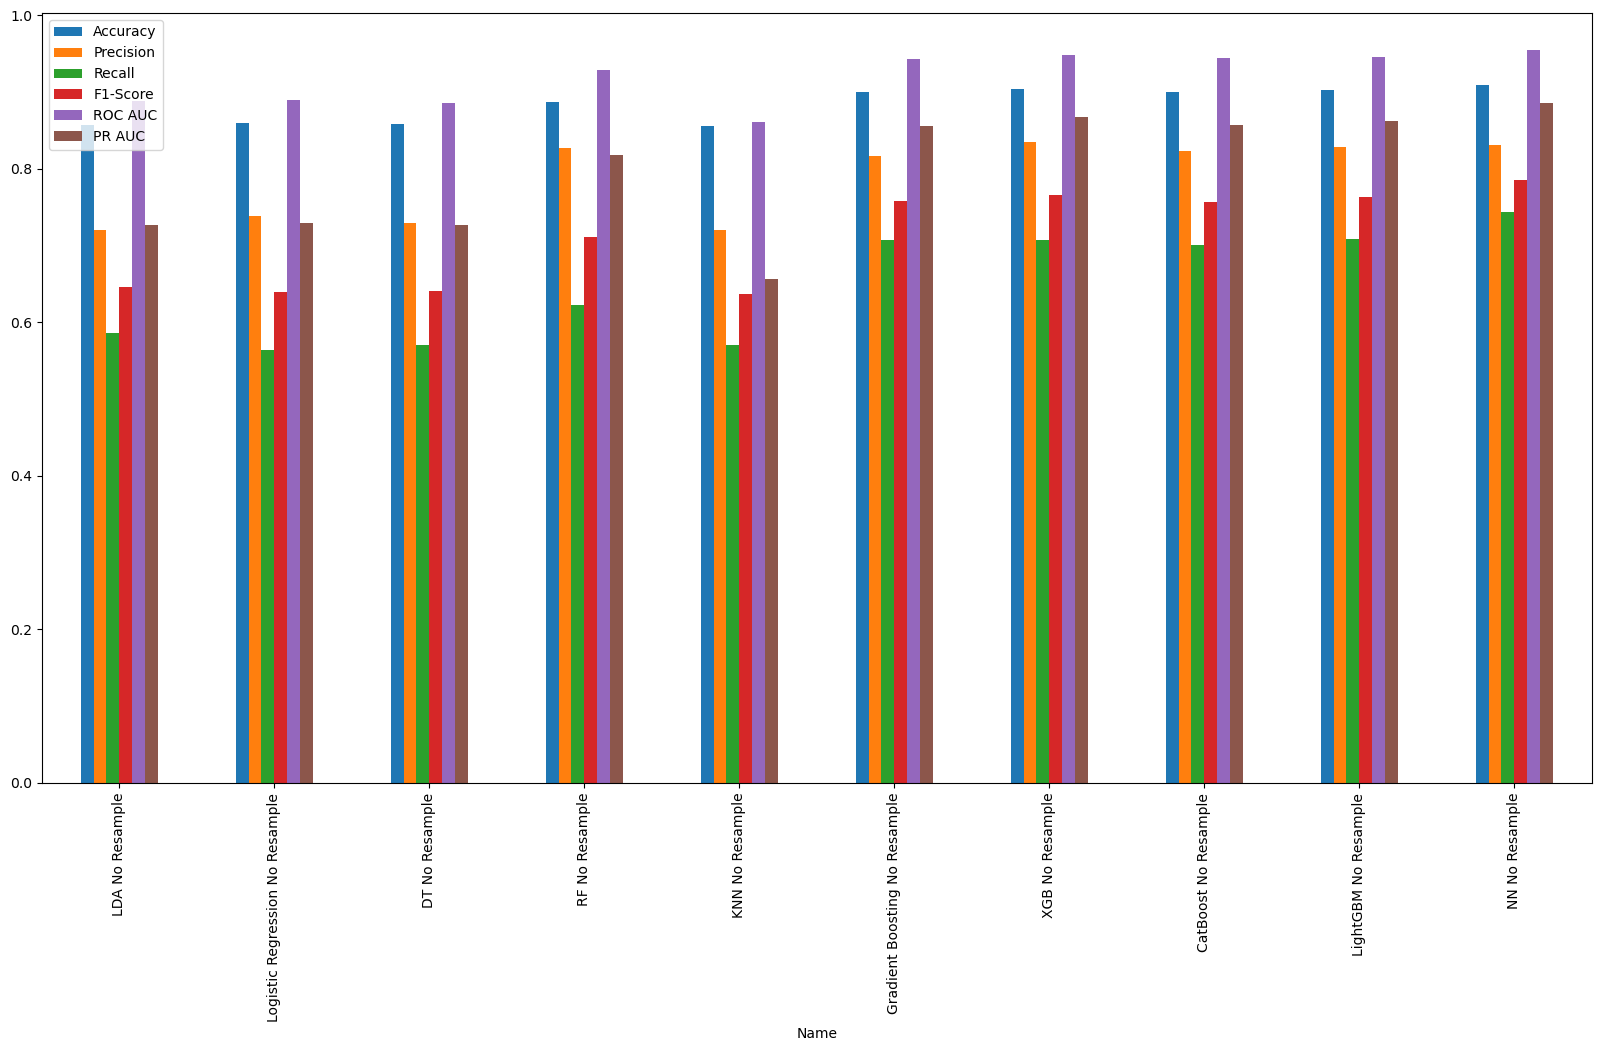

In [ ]:
df = models_df[[x for x in models_df.columns if x != 'Confusion Matrix']]
df.plot.bar(figsize=(20,10))

In [ ]:
best_values_no_resample = pd.DataFrame(columns=['Metric', 'Best Value', 'Method'])

for col in models_df.columns:
    if col != 'Confusion Matrix':
        best_value_row = models_df.sort_values(by=col, ascending=False).head(1)
        best_value = best_value_row[col].values[0]
        method_name = best_value_row.index[0]  
        new_row = pd.DataFrame({'Metric': [col], 'Best Value': [best_value], 'Method': [method_name]})
        best_values_no_resample = pd.concat([best_values_no_resample, new_row], ignore_index=True)

pd.DataFrame(best_values_no_resample)

Metric  Best Value           Method
0   Accuracy    0.909822   NN No Resample
1  Precision    0.834392  XGB No Resample
2     Recall    0.744359   NN No Resample
3   F1-Score    0.785337   NN No Resample
4    ROC AUC    0.955522   NN No Resample
5     PR AUC    0.885739   NN No Resample

## SMOTE

In [ ]:
models_df_smote

Name  Accuracy Precision    Recall  F1-Score  \
0                  LDA SMOTE  0.815666  0.559291  0.793333  0.656064   
0  Logistic Regression Smote   0.81166  0.551718  0.800769  0.653313   
0                   DT Smote  0.830923  0.599957   0.71141  0.650947   
0                   RF SMOTE  0.884905    0.7499  0.721154  0.735246   
0                  KNN SMOTE  0.800494  0.533826  0.787051  0.636166   
0    Gradient Boosting SMOTE  0.897576  0.802976  0.712692  0.755145   
0                  XGB Smote  0.903628  0.823832  0.718846  0.767767   
0             CatBoost SMOTE  0.899196  0.810728  0.711154  0.757683   
0            Ligth GBM SMOTE  0.901725  0.819238  0.714103  0.763066   
0                   NN Smote  0.894906  0.733888  0.824872  0.776725   

    ROC AUC               Confusion Matrix    PR AUC  
0   0.88886  [[22521, 4876], [1612, 6188]]  0.726089  
0  0.889469  [[22322, 5075], [1554, 6246]]  0.726918  
0  0.826767  [[23697, 3700], [2251, 5549]]  0.582073  
0  0.926936  [[25521, 1876], [2175, 5625]]   0.81416  
0  0.860175  [[22036, 5361], [1661, 6139]]   0.60457  
0  0.938996  [[26033, 1364], [2241, 5559]]  0.848645  
0  0.946324  [[26198, 1199], [2193, 5607]]   0.86356  
0  0.940174  [[26102, 1295], [2253, 5547]]  0.849674  
0  0.944573  [[26168, 1229], [2230, 5570]]  0.860649  
0  0.950912  [[25064, 2333], [1366, 6434]]  0.873912

In [ ]:
models_df_smote.index = models_df_smote.Name
models_df_smote = models_df_smote.drop('Name',axis=1)

<Axes: xlabel='Name'>

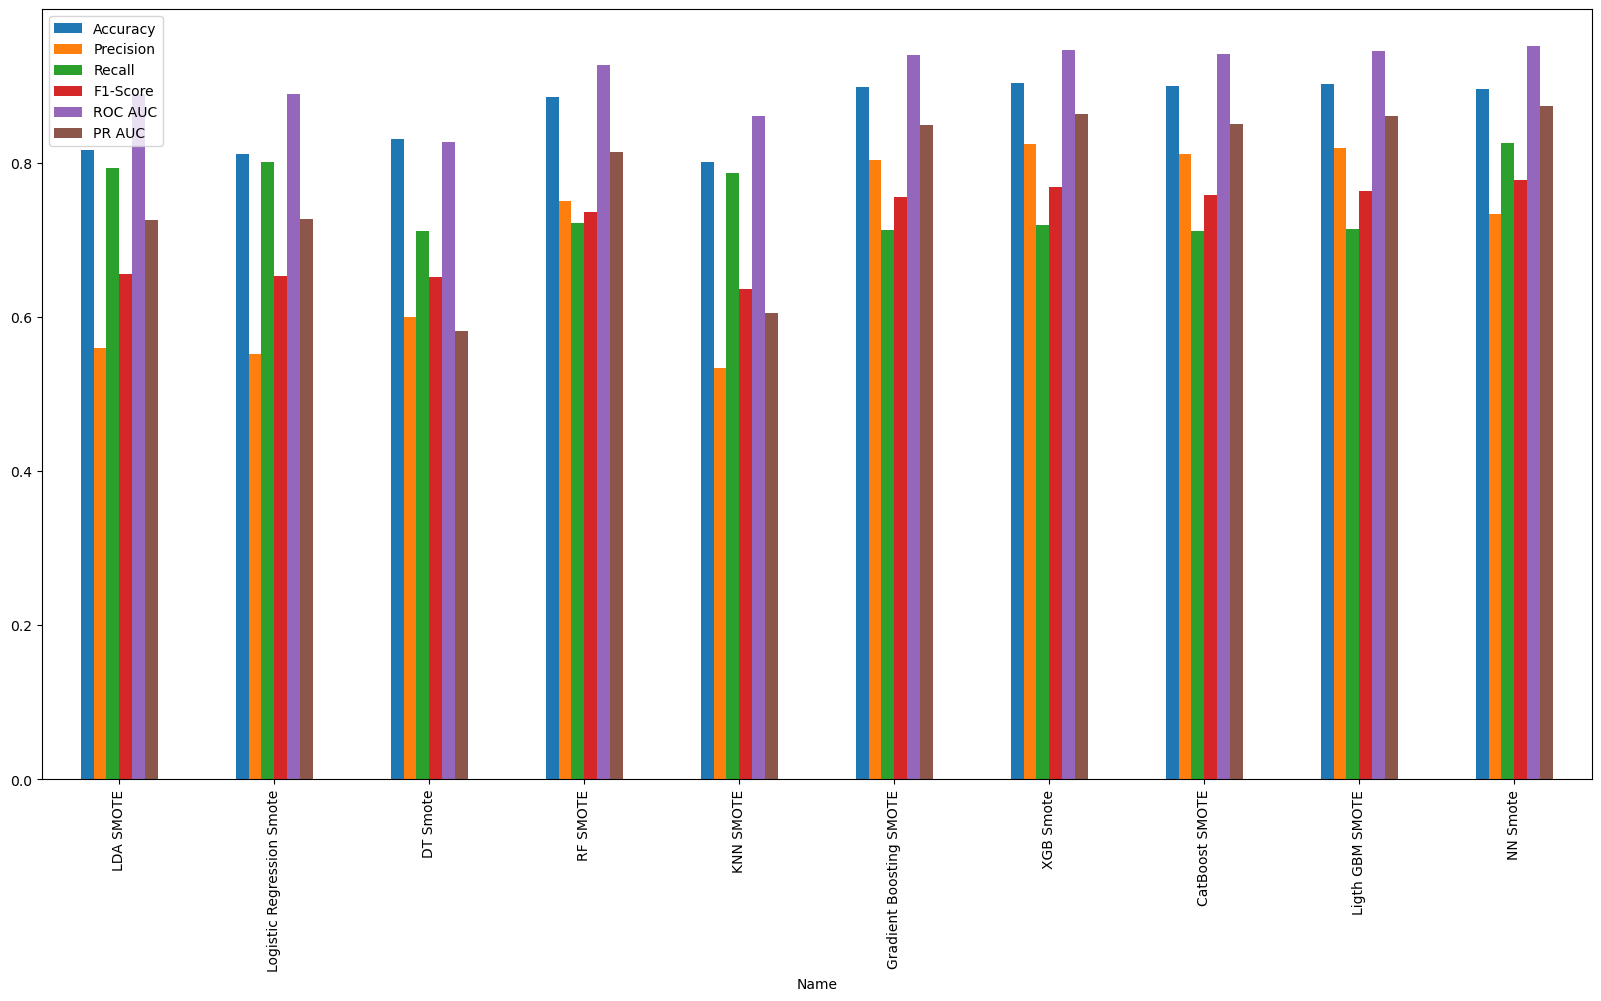

In [ ]:
df_smote = models_df_smote[[x for x in models_df_smote.columns if x != 'Confusion Matrix']]
df_smote.plot.bar(figsize=(20,10))

In [ ]:
best_values_smote = pd.DataFrame(columns=['Metric', 'Best Value', 'Method'])

for col in models_df_smote.columns:
    if col != 'Confusion Matrix':
        best_value_row = models_df_smote.sort_values(by=col, ascending=False).head(1)
        best_value = best_value_row[col].values[0]
        method_name = best_value_row.index[0]  
        new_row = pd.DataFrame({'Metric': [col], 'Best Value': [best_value], 'Method': [method_name]})
        best_values_smote = pd.concat([best_values_smote, new_row], ignore_index=True)

pd.DataFrame(best_values_smote)

Metric  Best Value     Method
0   Accuracy    0.903628  XGB Smote
1  Precision    0.823832  XGB Smote
2     Recall    0.824872   NN Smote
3   F1-Score    0.776725   NN Smote
4    ROC AUC    0.950912   NN Smote
5     PR AUC    0.873912   NN Smote

## Undersample

In [ ]:
models_df_under

Name  Accuracy Precision    Recall  F1-Score  \
0                  LDA undersample  0.815354  0.558757  0.793077  0.655609   
0  Logistic Regression Undersample  0.811461   0.55135  0.801154  0.653183   
0                   DT Undersample    0.8045  0.539257  0.809231  0.647219   
0                   RF Undersample  0.843225   0.60443  0.846667  0.705329   
0                  KNN Undersample  0.796545  0.526865  0.803333  0.636368   
0    Gradient Boosting Undersample  0.862914  0.640715  0.868333  0.737358   
0                  XGB Undersample  0.863341  0.640587  0.873333  0.739069   
0             CatBoost Undersample  0.862261  0.638905  0.870385  0.736894   
0                  Ligth GBM Under  0.864903  0.644656  0.869872  0.740518   
0                   NN Undersample  0.879592  0.684904  0.845769  0.756884   

    ROC AUC               Confusion Matrix    PR AUC  
0  0.889342  [[22512, 4885], [1614, 6186]]  0.727967  
0  0.889934  [[22312, 5085], [1551, 6249]]   0.72871  
0  0.883556  [[22004, 5393], [1488, 6312]]  0.692408  
0   0.92317  [[23075, 4322], [1196, 6604]]  0.797058  
0  0.866511  [[21770, 5627], [1534, 6266]]  0.614456  
0  0.936746  [[23599, 3798], [1027, 6773]]  0.830312  
0  0.943007   [[23575, 3822], [988, 6812]]  0.847361  
0  0.939948  [[23560, 3837], [1011, 6789]]  0.837157  
0  0.941262  [[23657, 3740], [1015, 6785]]  0.842884  
0  0.943716  [[24362, 3035], [1203, 6597]]  0.846761

In [ ]:
models_df_under.index = models_df_under.Name
models_df_under = models_df_under.drop('Name',axis=1)

<Axes: xlabel='Name'>

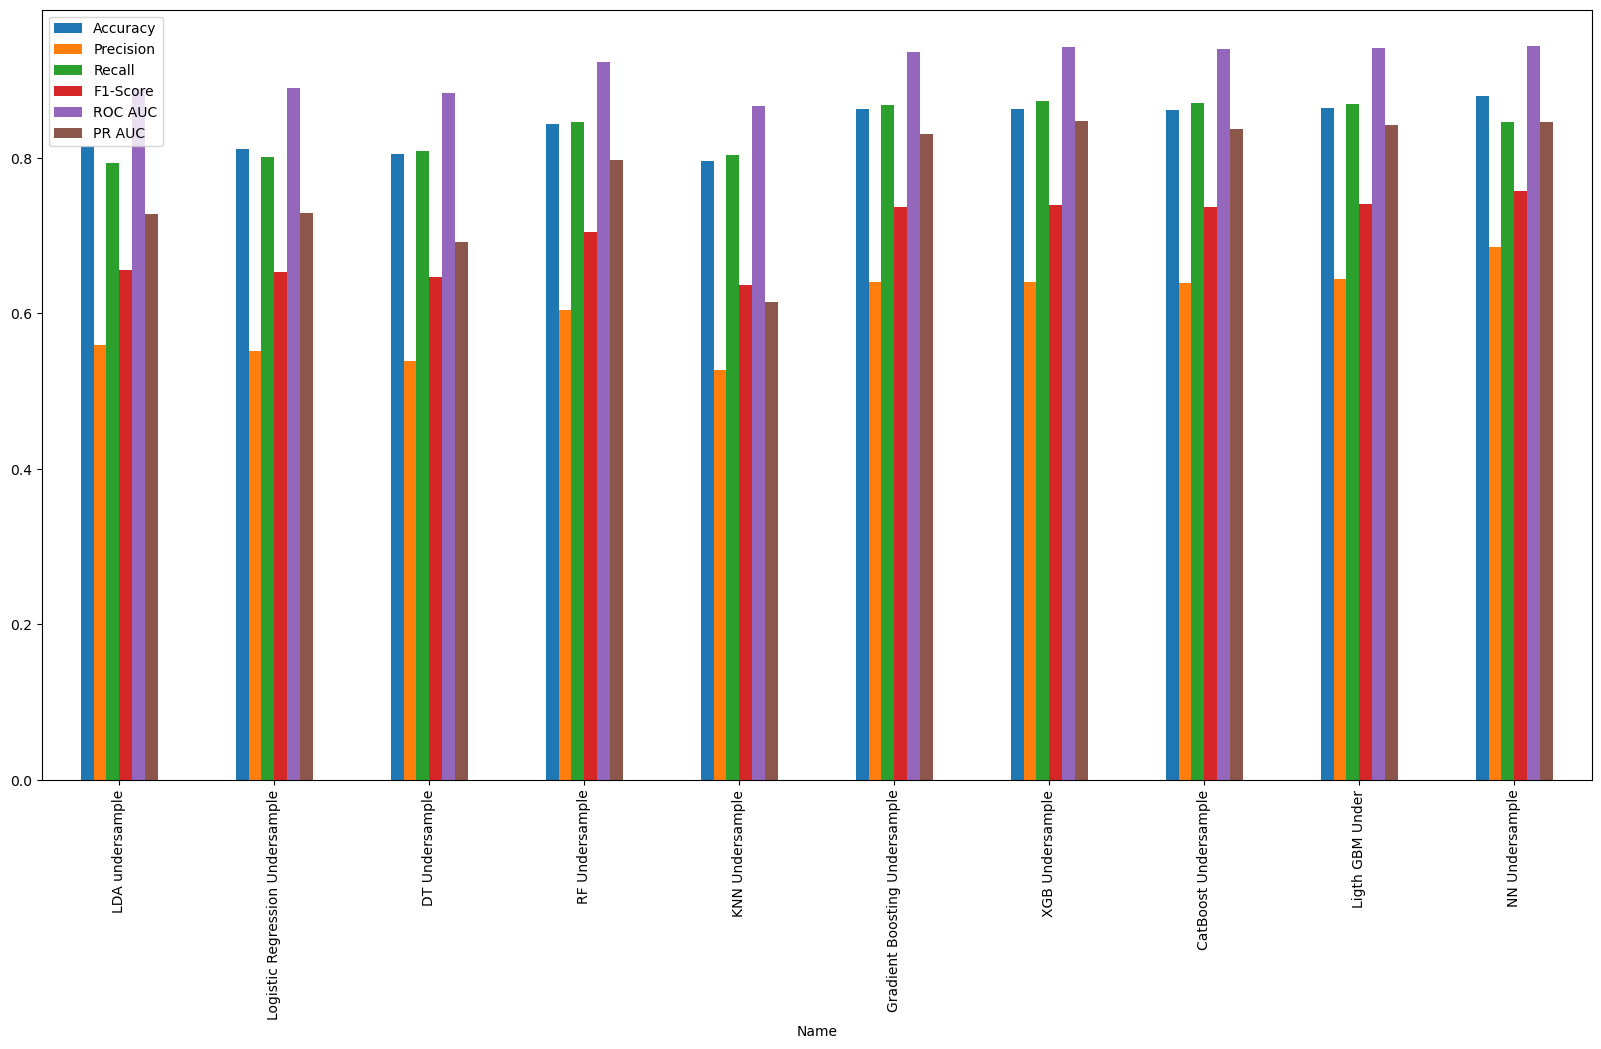

In [ ]:
df_under = models_df_under[[x for x in models_df_under.columns if x != 'Confusion Matrix']]
df_under.plot.bar(figsize=(20,10))

In [ ]:
best_values_under = pd.DataFrame(columns=['Metric', 'Best Value', 'Method'])

for col in models_df_under.columns:
    if col != 'Confusion Matrix':
        best_value_row = models_df_under.sort_values(by=col, ascending=False).head(1)
        best_value = best_value_row[col].values[0]
        method_name = best_value_row.index[0]  
        new_row = pd.DataFrame({'Metric': [col], 'Best Value': [best_value], 'Method': [method_name]})
        best_values_under = pd.concat([best_values_under, new_row], ignore_index=True)

pd.DataFrame(best_values_under)


Metric  Best Value           Method
0   Accuracy    0.879592   NN Undersample
1  Precision    0.684904   NN Undersample
2     Recall    0.873333  XGB Undersample
3   F1-Score    0.756884   NN Undersample
4    ROC AUC    0.943716   NN Undersample
5     PR AUC    0.847361  XGB Undersample

## Best method for each metrics
We can establish, for each metric, the best method among all runned. So, here I merged the three datasets and I don't make any differences between the three type of approach (No Resample, SMOTE, Undersample).

In [ ]:

all_best_values = pd.concat([best_values_no_resample,
                             best_values_smote,
                             best_values_under],
                            ignore_index=True)

best_method_per_metric = all_best_values.loc[all_best_values.groupby('Metric')['Best Value'].idxmax()]

pd.DataFrame(best_method_per_metric)


Metric  Best Value           Method
0    Accuracy    0.909822   NN No Resample
3    F1-Score    0.785337   NN No Resample
5      PR AUC    0.885739   NN No Resample
1   Precision    0.834392  XGB No Resample
4     ROC AUC    0.955522   NN No Resample
14     Recall    0.873333  XGB Undersample

## Comparison of metrics for different sampling methods

In [ ]:
recall_mean = [models_df['Recall'].mean(), models_df_smote['Recall'].mean(), models_df_under['Recall'].mean()]
precision_mean = [models_df['Precision'].mean(), models_df_smote['Precision'].mean(), models_df_under['Precision'].mean()]
pr_auc_mean = [models_df['PR AUC'].mean(), models_df_smote['PR AUC'].mean(), models_df_under['PR AUC'].mean()]
accuracy_mean = [models_df['Accuracy'].mean(), models_df_smote['Accuracy'].mean(), models_df_under['Accuracy'].mean()]
f1_mean = [models_df['F1-Score'].mean(), models_df_smote['F1-Score'].mean(), models_df_under['F1-Score'].mean()]

metrics_df = pd.DataFrame({
    'Method': ['Original', 'SMOTE', 'Under-sampling'],
    'Accuracy': accuracy_mean,
    'Recall': recall_mean,
    'Precision': precision_mean,
    'F1-Score': f1_mean,
    'PR AUC': pr_auc_mean
})

metrics_df

Method  Accuracy    Recall  Precision  F1-Score    PR AUC
0        Original  0.883524  0.648385   0.786859  0.710392  0.798787
1           SMOTE  0.864068  0.749538   0.698535  0.715212  0.775025
2  Under-sampling  0.840410  0.838115   0.603042  0.700843  0.776507

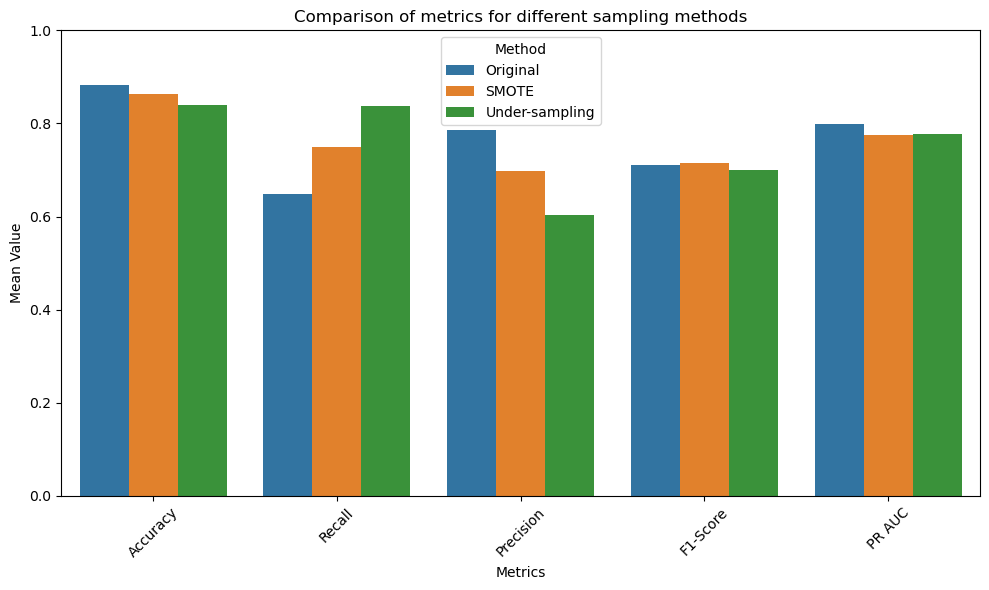

In [ ]:

metrics_long_df = metrics_df.melt(id_vars='Method', var_name='Metric', value_name='Value')


plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Value', hue='Method', data=metrics_long_df)


plt.title('Comparison of metrics for different sampling methods')
plt.ylabel('Mean Value')
plt.xlabel('Metrics')
plt.ylim(0, 1) 
plt.legend(title='Method')
plt.xticks(rotation=45)


plt.tight_layout()
plt.show()